Unified for all the PT regions

In [1]:
from categoriesDef import categories
cat = categories['low']
version = 'v9'
mB_var = 'mass_candB'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [6]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_200622*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
if not lumi_tot:
    expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
    lumi_tot = expectedLumi[cat.name]
    print 'Total lumi (estimated): {:.1f} fb^-1'.format(lumi_tot)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


In [7]:
dsetRD_loc = '../data/cmsRD/skimmed/B2JpsiKst_200622_{}_corr.root'.format(cat.name)

fRD_skimmed = rt.TFile.Open(dsetRD_loc, 'READ')
tRD_skimmed = fRD_skimmed.Get('Tevts')

N_sel_per_fb = tRD_skimmed.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 4088


# Analyze data

### Fit the whole dataset

In [8]:
width = 0.003 #GeV
m_min = 5.201
m_max = 5.36
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=np.arange(start=m_min, stop=m_max, step=width)
               )
tRD_skimmed.Project('h', mB_var)
h.Sumw2()

In [9]:
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar(mB_var, 'm_{#mu#mu#piK}', m_min, m_max, 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.01, 0.0005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.03, 0.005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [10]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [11]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
dN_sig_per_fb = nsig.getError()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

chi2: 41.9/46 0.646
Total: Nsig = 16608, Nbkg = 2612
Signal events per fb: 2599


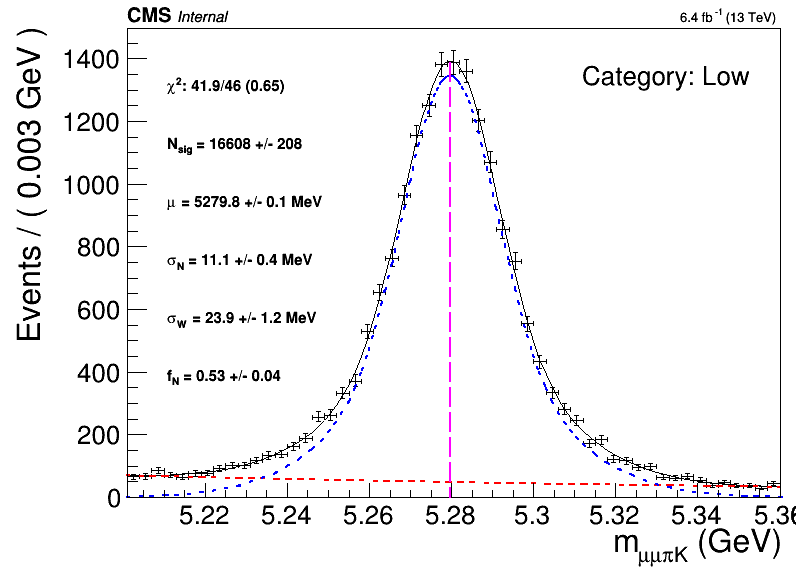

In [12]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/MassMuMuPiK_data_' + cat.name + '_' + version + '.png')

### Make sDataset

In [13]:
v_trgMu_pt = rt.RooRealVar('trgMu_pt', 'trg #mu p_{T}', 0, 500, 'GeV')
v_trgMu_eta = rt.RooRealVar('trgMu_eta', 'trg #mu #eta', -3, 3, '')
v_Jpsi_pt = rt.RooRealVar('Jpsi_pt', 'J/#psi p_{T}', 0, 500, 'GeV')
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_trgMu_pt = rt.RooRealVar('trgMu_pt', '#mu_{trg} p_{T}', 0, 1000, 'GeV')
v_N_vtx = rt.RooRealVar('N_vtx', 'N_{vtx}', 0, 1e3)

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', tRD_skimmed, rt.RooArgSet(mass, 
                                                         v_trgMu_pt, v_trgMu_eta, v_Jpsi_pt, 
                                                         v_B_eta, v_B_pt, v_trgMu_pt, 
                                                         v_N_vtx))
ds.convertToTreeStore()

In [14]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

16615.05977267831

In [15]:
f_sw = rt.TFile(dsetRD_loc.replace('.root', '_sw.root'), 'RECREATE')
ds.convertToTreeStore()
auxTree = ds.tree()
auxTree.Write()
f_sw.Close()

In [16]:
dfRD = pd.DataFrame(rtnp.root2array(dsetRD_loc.replace('.root', '_sw.root')))
dfRD['sigSW'] = dfRD['L_nsig']/(dfRD['L_nsig']+dfRD['L_nbkg'])

# Load MC

In [17]:
mcSample = DSetLoader('B0_JpsiKst_PUc0', candDir='ntuples_B2JpsiKst')
# dsetMC_loc = mcSample.skimmed_dir + '/{}_corr.root'.format(cat.name)
dsetMC_loc = mcSample.skimmed_dir + '/{}_bare.root'.format(cat.name)

dfMC = pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [18]:
effMCgen = mcSample.effMCgen
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))['JPsiKst']
effCAND = mcSample.effCand['effCAND']
effSkim = mcSample.getSkimEff(cat.name+'_corr')

xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND, effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'


Expected evts/fb: 446 +/- 12




In [19]:
from pileup_utilities import pileupReweighter
puRew = pileupReweighter(dsetMC_loc, cat)
dfMC['wPU'] = puRew.weightsPileupMC[dfMC['N_vtx'].astype(np.int)]

# Compare

### Closure variables

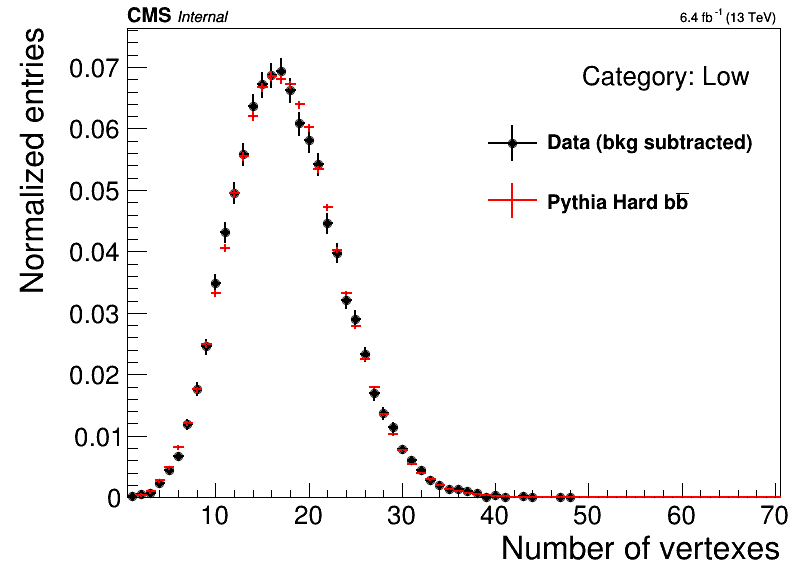

In [20]:
hRD = create_TH1D(dfRD['N_vtx'], name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=[70, 0.5, 70.5],
                weights=dfRD['sigSW'],
                scale_histo='norm'
               )
hRD.SetMarkerStyle(15)

hMC = create_TH1D(dfMC['N_vtx'], name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning,
                  weights=dfMC['wPU'],
                  scale_histo='norm' 
                 )
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.6, 0.6, 0.95,0.8)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.integrated_lumi = lumi_tot
m = SetMaxToMaxHist([hRD, hMC])
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name));

### Load MC corrections

In [21]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v7.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
        
nX = hTriggerSF.GetNbinsX()
ptWeight = [[] for k in range(nX+2)]

dfMC['trgSF'] = np.ones(dfMC.shape[0])
for i, (pt, eta, ip) in enumerate(dfMC[['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
    iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
    iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
    dfMC.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)
    if np.abs(dfMC.at[i, 'trgSF'] - 1) > 0.1:
        print (4*'{:.2f} ').format(pt, eta, ip, hTriggerSF.GetBinContent(ix, iy, iz))
    ptWeight[ix].append(hTriggerSF.GetBinContent(ix, iy, iz))

7.37 0.59 11.75 0.81 
7.87 0.07 8.08 0.85 
7.26 -0.53 13.33 0.78 
7.51 0.31 22.32 0.76 
7.34 -0.59 16.94 0.81 
7.55 0.44 12.80 0.81 
7.71 -0.75 20.05 0.87 
7.71 0.63 27.77 0.87 
7.21 0.04 44.54 0.71 
7.85 0.10 16.82 0.84 
7.93 -0.55 27.67 0.87 
7.57 0.70 18.76 0.81 
7.48 0.31 24.26 0.76 
7.24 -0.16 20.77 0.71 
7.67 -0.16 21.35 0.84 
7.89 0.30 20.63 0.84 
7.74 0.25 34.90 0.84 
7.86 -0.18 15.10 0.84 
7.40 0.12 17.88 0.77 
7.59 0.03 5.34 0.76 
7.54 -0.10 19.17 0.77 
7.35 -0.63 7.20 0.82 
7.45 -0.51 10.35 0.81 
7.96 -0.69 13.31 0.89 
7.88 0.75 6.10 0.88 
7.29 -0.05 9.72 0.73 
7.61 0.26 79.23 0.84 
7.51 0.43 33.88 0.81 
7.54 -0.77 5.02 0.84 
7.77 0.33 51.96 0.84 
7.39 -0.25 20.26 0.76 
7.50 0.25 12.39 0.77 
7.26 -0.67 8.99 0.77 
7.81 -0.39 25.58 0.84 
7.34 0.47 6.60 0.82 
7.27 -0.19 10.94 0.70 
7.89 -0.52 6.50 0.88 
7.22 0.76 14.43 0.78 
7.48 0.35 9.03 0.77 
7.77 -0.07 33.99 0.84 
7.63 0.17 41.32 0.84 
7.74 -0.64 114.93 0.87 
7.48 -0.32 11.50 0.77 
7.64 -0.09 18.22 0.84 
7.74 0.59 38.76 0.8

7.54 0.10 130.86 0.76 
7.33 0.24 16.37 0.77 
7.37 -0.47 26.26 0.81 
7.30 -0.40 8.80 0.82 
7.95 -0.23 7.68 0.85 
7.33 0.40 59.77 0.81 
7.50 -0.19 38.88 0.76 
7.99 -0.09 12.02 0.84 
7.23 0.70 94.30 0.76 
7.37 -0.56 13.91 0.81 
7.20 -0.41 53.08 0.76 
7.57 0.19 64.90 0.76 
7.77 0.69 9.93 0.88 
7.22 -0.45 12.87 0.78 
7.73 -0.37 17.11 0.84 
7.96 -0.67 27.43 0.87 
7.59 0.57 29.92 0.81 
7.28 -0.58 10.49 0.78 
7.50 0.44 13.72 0.81 
7.39 -0.59 13.65 0.81 
7.80 -0.46 37.74 0.87 
7.97 0.62 10.55 0.89 
7.80 0.43 9.21 0.88 
7.46 -0.21 18.06 0.77 
7.71 -0.07 22.02 0.84 
7.79 -0.10 18.78 0.84 
7.38 -0.57 8.38 0.82 
7.68 0.22 30.24 0.84 
7.46 0.74 7.61 0.82 
7.68 -0.50 55.30 0.87 
7.65 0.61 26.76 0.87 
7.30 -0.30 22.08 0.76 
7.79 0.43 8.69 0.88 
7.22 -0.15 35.13 0.71 
7.73 -0.56 7.03 0.88 
7.61 0.07 24.42 0.84 
7.59 -0.40 36.59 0.76 
7.25 -0.15 17.21 0.70 
7.78 0.55 17.82 0.89 
7.62 0.51 15.58 0.89 
7.36 -0.04 9.48 0.77 
7.69 0.38 14.46 0.84 
7.21 -0.27 7.84 0.73 
7.49 0.73 156.22 0.81 
7.66 0.11 8.58 

7.27 -0.29 15.82 0.70 
7.90 -0.72 29.40 0.87 
7.72 -0.07 8.26 0.85 
7.86 0.29 5.39 0.90 
7.63 0.71 20.00 0.89 
7.87 0.23 8.09 0.85 
7.98 -0.14 14.21 0.84 
7.33 0.59 54.97 0.81 
7.43 0.05 27.60 0.76 
7.22 -0.31 6.73 0.73 
7.32 -0.69 51.32 0.81 
7.85 0.23 89.18 0.84 
7.52 -0.14 9.86 0.77 
7.44 0.03 6.57 0.77 
7.62 0.05 26.79 0.84 
7.41 0.04 12.11 0.77 
7.28 -0.13 38.14 0.71 
7.86 0.16 24.97 0.84 
7.92 0.16 25.76 0.84 
7.74 0.53 41.88 0.87 
7.28 -0.35 20.05 0.71 
7.92 -0.76 6.02 0.88 
7.87 -0.39 13.33 0.84 
7.74 0.42 28.35 0.87 
7.55 -0.25 45.29 0.76 
7.94 0.05 68.05 0.84 
7.70 0.77 54.25 0.87 
7.60 -0.25 14.48 0.77 
7.65 -0.61 25.85 0.87 
7.66 -0.14 15.11 0.84 
7.37 0.30 19.12 0.77 
7.21 -0.76 61.32 0.76 
7.33 -0.34 6.32 0.77 
7.38 0.42 25.78 0.81 
7.55 -0.04 66.82 0.76 
7.46 0.45 30.11 0.81 
7.24 -0.04 13.36 0.70 
7.76 0.11 21.90 0.84 
7.60 -0.20 36.62 0.76 
7.72 0.20 25.80 0.84 
7.20 -0.25 19.29 0.70 
7.60 0.44 9.93 0.88 
7.63 0.58 28.60 0.87 
7.40 0.05 14.13 0.77 
7.39 0.79 32.53 0.81

7.32 -0.24 17.27 0.77 
7.65 -0.46 75.13 0.87 
7.66 -0.42 9.24 0.88 
7.28 -0.35 13.76 0.70 
7.38 0.17 7.21 0.77 
7.28 -0.75 28.22 0.76 
7.64 0.61 25.33 0.87 
7.42 -0.46 8.27 0.82 
7.85 0.39 5.37 0.90 
7.77 -0.25 6.12 0.85 
7.91 -0.22 11.79 0.84 
7.53 -0.29 7.58 0.77 
7.93 -0.11 14.48 0.84 
7.33 0.07 13.54 0.77 
7.61 0.36 14.96 0.84 
7.22 -0.63 5.47 0.76 
7.75 0.53 14.31 0.89 
7.65 0.20 19.61 0.84 
7.34 0.74 25.02 0.81 
7.55 -0.09 21.97 0.76 
7.49 0.58 13.25 0.81 
7.98 -0.40 58.36 0.84 
7.21 0.40 16.78 0.78 
7.36 0.05 12.68 0.77 
7.86 -0.61 8.50 0.88 
7.86 -0.61 70.15 0.87 
7.58 0.00 17.70 0.77 
7.64 0.61 11.88 0.89 
7.20 -0.12 24.87 0.71 
7.65 0.05 8.97 0.85 
7.31 -0.16 7.52 0.77 
7.43 0.28 48.14 0.76 
7.37 0.14 8.24 0.77 
7.50 -0.59 24.55 0.81 
7.49 0.06 66.27 0.76 
7.64 -0.56 25.86 0.87 
7.78 0.69 41.73 0.87 
7.51 0.16 44.51 0.76 
7.37 -0.50 9.15 0.82 
7.24 0.76 61.62 0.76 
7.62 -0.29 24.60 0.84 
7.70 0.22 6.69 0.85 
7.92 0.17 30.51 0.84 
7.24 0.30 6.68 0.73 
7.85 0.02 50.02 0.84 
7.3

7.43 0.41 23.10 0.81 
7.84 -0.06 10.88 0.84 
7.76 0.30 16.69 0.84 
7.37 -0.34 58.88 0.76 
7.74 0.41 33.08 0.87 
7.31 0.34 6.18 0.77 
7.54 0.15 16.44 0.77 
7.66 0.24 5.71 0.88 
7.78 -0.24 20.85 0.84 
7.73 -0.14 22.61 0.84 
7.53 -0.08 21.51 0.76 
7.82 0.42 10.83 0.89 
7.56 -0.40 17.76 0.81 
7.26 -0.39 27.79 0.71 
7.73 -0.67 30.69 0.87 
7.69 0.62 11.27 0.89 
7.52 -0.52 10.77 0.81 
7.69 -0.55 50.90 0.87 
7.31 -0.18 6.78 0.77 
7.82 0.78 10.22 0.89 
7.90 -0.69 36.34 0.87 
7.33 0.68 64.58 0.81 
7.47 0.56 13.88 0.81 
7.46 -0.38 27.94 0.76 
7.22 0.64 8.71 0.77 
7.67 -0.12 33.45 0.84 
7.90 -0.12 10.74 0.84 
7.72 0.39 10.12 0.84 
7.96 -0.47 47.86 0.87 
7.88 0.07 14.90 0.84 
7.73 0.78 20.90 0.87 
7.38 -0.36 32.67 0.76 
7.93 -0.38 36.95 0.84 
7.24 -0.20 22.87 0.71 
7.66 -0.18 12.94 0.84 
7.98 0.24 13.28 0.84 
7.24 -0.59 17.38 0.78 
7.54 -0.60 9.74 0.82 
8.00 -0.27 12.62 0.84 
7.85 -0.54 43.18 0.87 
7.67 0.28 53.96 0.84 
7.67 -0.50 13.78 0.89 
7.59 0.69 26.29 0.81 
7.69 0.60 43.19 0.87 
7.73 -0.05 2

7.39 0.19 22.32 0.76 
7.97 0.18 18.49 0.84 
7.26 0.22 8.96 0.73 
7.76 0.57 7.56 0.88 
7.35 -0.43 23.04 0.81 
7.83 -0.07 9.77 0.85 
7.40 0.15 15.60 0.77 
7.74 -0.25 23.52 0.84 
7.24 0.52 26.05 0.76 
7.84 -0.14 15.75 0.84 
7.65 0.73 7.47 0.88 
7.32 -0.36 20.54 0.76 
7.74 -0.41 7.43 0.88 
7.44 0.17 15.89 0.77 
7.37 0.36 7.46 0.77 
7.63 0.10 22.76 0.84 
7.89 0.23 7.15 0.85 
7.66 -0.05 5.54 0.88 
7.84 -0.35 10.56 0.84 
7.31 -0.41 50.68 0.81 
7.71 0.70 25.99 0.87 
7.57 0.62 10.35 0.81 
7.62 -0.05 39.04 0.84 
7.31 -0.33 10.60 0.77 
7.51 0.34 28.72 0.76 
7.82 0.69 18.59 0.89 
7.84 0.60 34.76 0.87 
7.75 0.44 26.53 0.87 
7.49 -0.18 59.37 0.76 
7.88 0.63 13.99 0.89 
7.20 -0.10 24.94 0.71 
7.22 0.60 29.96 0.76 
7.86 0.40 14.46 0.89 
7.24 -0.11 52.26 0.71 
7.37 -0.60 47.08 0.81 
7.53 -0.44 7.25 0.82 
7.48 0.76 23.28 0.81 
7.44 -0.08 23.53 0.76 
7.74 0.43 21.93 0.87 
7.56 0.10 35.64 0.76 
7.75 -0.35 14.39 0.84 
7.34 0.77 10.02 0.81 
7.93 0.32 21.53 0.84 
7.75 0.29 17.65 0.84 
7.65 -0.26 9.17 0.85 
7

7.26 -0.43 14.18 0.78 
7.82 0.75 7.85 0.88 
7.27 0.47 18.29 0.78 
7.55 -0.11 7.24 0.77 
7.64 -0.63 14.74 0.89 
7.29 0.07 49.69 0.71 
7.60 -0.68 7.57 0.88 
7.88 0.63 41.01 0.87 
7.68 0.25 28.92 0.84 
7.27 -0.39 9.60 0.73 
7.75 -0.56 51.14 0.87 
7.75 0.68 40.91 0.87 
7.50 -0.09 25.07 0.76 
7.53 0.52 44.36 0.81 
7.65 -0.41 9.10 0.88 
7.63 0.33 19.74 0.84 
7.39 -0.21 16.96 0.77 
7.46 -0.53 8.46 0.82 
7.36 0.06 72.76 0.76 
7.30 -0.66 72.51 0.76 
7.41 0.53 21.31 0.81 
7.85 -0.63 6.38 0.88 
7.85 0.58 17.67 0.89 
7.47 0.46 6.93 0.82 
7.91 -0.01 13.86 0.84 
7.21 -0.46 13.08 0.78 
7.28 -0.12 38.43 0.71 
7.95 -0.33 40.49 0.84 
7.20 -0.72 56.99 0.76 
7.37 0.58 21.20 0.81 
7.61 0.40 17.56 0.89 
7.62 -0.22 5.96 0.88 
7.70 0.27 40.48 0.84 
7.83 -0.56 102.18 0.87 
7.97 0.46 12.06 0.89 
7.97 -0.41 13.55 0.89 
7.36 -0.36 30.46 0.76 
7.34 0.69 58.93 0.81 
7.45 -0.41 20.11 0.81 
7.42 0.36 13.81 0.77 
7.88 -0.61 33.80 0.87 
7.33 -0.22 18.75 0.77 
7.23 0.13 35.19 0.71 
7.68 -0.45 10.43 0.89 
7.87 -0.19 25.1

7.43 -0.22 9.69 0.77 
7.51 0.75 14.75 0.81 
7.70 0.56 25.03 0.87 
7.89 0.36 10.40 0.84 
7.66 -0.31 47.46 0.84 
7.46 -0.10 23.63 0.76 
7.72 -0.23 40.67 0.84 
7.31 0.07 20.70 0.76 
7.84 0.12 17.44 0.84 
7.62 0.34 28.45 0.84 
7.62 0.72 17.04 0.89 
7.22 -0.38 58.75 0.71 
7.51 -0.03 14.26 0.77 
7.66 0.02 16.88 0.84 
7.40 -0.57 10.49 0.81 
7.40 -0.67 22.77 0.81 
7.70 0.17 5.69 0.88 
7.41 -0.15 46.82 0.76 
7.26 -0.14 7.83 0.73 
7.71 0.74 42.64 0.87 
7.31 0.68 10.82 0.81 
7.42 -0.37 26.98 0.76 
7.45 0.60 15.23 0.81 
7.49 -0.00 11.70 0.77 
7.37 -0.10 21.41 0.76 
7.67 -0.29 33.76 0.84 
7.79 -0.01 55.54 0.84 
7.90 0.59 16.90 0.89 
7.27 0.47 13.68 0.78 
7.67 -0.54 76.37 0.87 
7.58 -0.12 9.28 0.77 
8.00 -0.79 31.15 0.87 
7.95 -0.09 20.07 0.84 
7.46 0.36 24.02 0.76 
7.30 0.30 9.53 0.77 
7.24 -0.56 18.02 0.78 
7.87 0.40 29.07 0.87 
7.55 0.19 94.11 0.76 
7.76 -0.06 15.97 0.84 
7.22 -0.35 142.30 0.71 
7.41 -0.62 103.67 0.81 
7.26 -0.73 15.03 0.78 
7.51 -0.73 16.39 0.81 
7.53 0.39 35.28 0.76 
7.60 -0.54

7.59 0.57 40.85 0.81 
7.93 -0.04 22.08 0.84 
7.80 0.21 18.42 0.84 
7.65 -0.59 22.83 0.87 
8.00 -0.73 14.83 0.89 
7.81 -0.42 23.24 0.87 
7.65 -0.39 15.40 0.84 
7.30 -0.51 21.56 0.81 
7.93 -0.48 23.23 0.87 
7.77 -0.05 10.02 0.84 
7.61 -0.15 52.82 0.84 
7.53 0.79 58.52 0.81 
7.35 -0.55 30.96 0.81 
7.96 0.36 6.07 0.85 
7.68 0.24 28.70 0.84 
7.86 -0.19 8.68 0.85 
7.92 -0.45 28.13 0.87 
7.54 -0.18 22.79 0.76 
7.86 -0.74 28.84 0.87 
7.96 0.43 39.30 0.87 
7.42 -0.58 53.13 0.81 
7.68 0.55 16.45 0.89 
7.30 -0.72 17.04 0.78 
7.50 -0.72 5.78 0.84 
7.27 0.15 22.97 0.71 
7.59 0.65 35.60 0.81 
7.52 -0.38 35.37 0.76 
7.95 -0.03 61.81 0.84 
7.44 -0.44 85.29 0.81 
7.31 0.27 12.58 0.77 
7.23 -0.06 17.75 0.70 
7.21 0.58 8.10 0.77 
7.67 -0.22 23.56 0.84 
7.54 0.06 20.78 0.76 
7.51 0.69 18.94 0.81 
7.77 0.73 50.15 0.87 
7.87 0.65 54.12 0.87 
7.75 0.67 6.28 0.88 
7.64 0.08 25.77 0.84 
7.63 -0.58 50.22 0.87 
7.53 -0.03 7.51 0.77 
7.53 -0.68 23.23 0.81 
7.88 0.09 20.41 0.84 
7.89 0.07 18.32 0.84 
7.90 0.49 89.

7.90 0.12 5.06 0.90 
7.89 -0.44 34.80 0.87 
7.25 0.60 114.67 0.76 
7.25 -0.29 35.13 0.71 
7.89 0.23 60.33 0.84 
7.44 -0.53 16.12 0.81 
7.68 -0.63 68.24 0.87 
7.41 0.13 37.35 0.76 
7.80 -0.38 19.88 0.84 
7.25 0.29 30.80 0.71 
7.79 0.49 48.32 0.87 
7.32 0.73 11.72 0.81 
7.50 -0.05 67.01 0.76 
7.71 -0.71 8.78 0.88 
7.52 0.68 30.70 0.81 
7.37 0.65 24.94 0.81 
7.87 0.44 74.26 0.87 
7.86 -0.35 38.98 0.84 
7.80 -0.42 43.95 0.87 
7.86 0.64 17.20 0.89 
7.73 0.12 9.50 0.85 
7.43 0.49 30.82 0.81 
7.24 -0.73 30.49 0.76 
7.40 -0.62 23.53 0.81 
7.40 0.44 42.54 0.81 
7.60 0.23 54.02 0.84 
7.34 0.32 31.63 0.76 
7.41 -0.11 6.57 0.77 
7.21 0.04 18.76 0.70 
7.66 0.09 54.58 0.84 
7.87 0.17 25.08 0.84 
7.74 -0.27 6.70 0.85 
7.80 0.18 36.76 0.84 
7.99 0.45 28.40 0.87 
7.48 0.69 15.97 0.81 
7.29 -0.46 14.64 0.78 
7.54 -0.34 15.98 0.77 
7.74 -0.31 12.44 0.84 
7.34 -0.80 13.93 0.81 
7.31 0.13 26.82 0.76 
7.21 0.12 6.75 0.73 
7.49 -0.80 12.92 0.81 
7.48 -0.15 142.32 0.76 
7.30 0.06 14.24 0.70 
7.47 0.47 13.51 0

7.64 0.00 14.42 0.84 
7.75 0.07 12.34 0.84 
7.68 0.54 30.63 0.87 
7.70 0.10 46.17 0.84 
7.73 0.24 13.75 0.84 
7.41 0.29 35.72 0.76 
7.96 -0.58 74.18 0.87 
7.73 -0.78 6.39 0.88 
7.33 -0.40 7.80 0.77 
7.44 -0.57 19.91 0.81 
7.49 -0.25 11.49 0.77 
7.49 -0.18 45.07 0.76 
7.50 0.65 13.02 0.81 
7.91 -0.58 12.73 0.89 
7.80 -0.30 38.73 0.84 
7.60 -0.12 10.68 0.84 
7.87 -0.07 7.09 0.85 
7.30 -0.65 64.59 0.81 
7.41 -0.68 24.04 0.81 
7.84 -0.32 9.23 0.85 
7.99 0.12 7.06 0.85 
7.28 -0.77 61.66 0.76 
7.89 0.80 21.58 0.87 
7.74 -0.73 66.94 0.87 
7.84 -0.07 6.28 0.85 
7.40 0.00 20.04 0.76 
7.38 0.65 79.11 0.81 
7.27 0.34 16.86 0.70 
7.42 -0.69 6.35 0.82 
7.27 -0.25 126.33 0.71 
7.44 -0.24 10.63 0.77 
7.71 0.70 15.74 0.89 
7.72 -0.09 6.27 0.85 
7.94 -0.45 10.69 0.89 
7.68 0.71 6.11 0.88 
7.40 -0.33 12.12 0.77 
7.63 0.80 28.00 0.87 
7.36 0.34 53.59 0.76 
7.33 0.25 12.17 0.77 
7.21 -0.58 13.69 0.78 
7.20 -0.78 10.76 0.78 
7.72 0.41 12.13 0.89 
7.26 -0.61 5.96 0.82 
7.43 0.02 28.97 0.76 
7.27 -0.29 40.20

7.72 -0.50 23.51 0.87 
7.83 -0.42 34.62 0.87 
7.21 0.02 13.74 0.70 
8.00 0.64 14.75 0.89 
7.68 0.34 23.07 0.84 
7.92 0.42 12.55 0.89 
7.56 -0.36 11.68 0.77 
7.99 0.29 138.30 0.84 
7.65 0.80 14.51 0.89 
7.29 0.58 37.70 0.76 
7.69 -0.65 34.89 0.87 
7.43 0.01 36.25 0.76 
7.72 -0.28 41.78 0.84 
7.40 -0.14 25.46 0.76 
7.87 -0.64 30.45 0.87 
7.61 0.69 14.47 0.89 
7.30 0.06 16.02 0.70 
7.32 0.39 5.01 0.76 
7.77 0.22 39.89 0.84 
7.67 -0.34 20.02 0.84 
7.86 0.10 13.90 0.84 
7.75 0.18 27.78 0.84 
7.68 -0.32 10.13 0.84 
7.46 -0.51 5.72 0.84 
7.99 0.44 23.49 0.87 
7.96 0.12 34.58 0.84 
7.68 -0.49 10.44 0.89 
7.56 -0.45 56.13 0.81 
7.62 0.66 24.28 0.87 
7.63 -0.57 27.88 0.87 
7.93 -0.70 9.53 0.88 
7.87 0.72 10.85 0.89 
7.81 0.25 17.56 0.84 
7.60 0.00 17.04 0.84 
7.29 0.08 17.71 0.70 
7.56 -0.38 15.08 0.77 
7.70 -0.68 57.13 0.87 
7.66 -0.37 7.72 0.85 
7.82 -0.73 9.10 0.88 
7.85 0.78 8.85 0.88 
7.89 -0.59 18.96 0.89 
7.85 0.68 49.68 0.87 
7.83 -0.41 69.10 0.87 
7.85 -0.42 9.98 0.88 
7.44 0.69 11.65 0

7.35 -0.48 26.58 0.81 
7.69 -0.48 11.56 0.89 
7.50 -0.02 18.36 0.77 
7.67 0.55 14.19 0.89 
7.69 0.53 57.59 0.87 
7.51 -0.19 5.98 0.77 
7.40 -0.67 37.72 0.81 
7.97 0.59 39.46 0.87 
7.82 0.63 8.43 0.88 
7.68 -0.76 15.04 0.89 
7.81 -0.77 10.32 0.89 
7.28 -0.38 35.54 0.71 
7.70 -0.19 29.89 0.84 
7.60 0.35 15.08 0.77 
7.84 0.62 29.13 0.87 
7.50 -0.49 37.62 0.81 
7.89 -0.03 20.12 0.84 
7.30 -0.50 57.68 0.81 
7.72 -0.02 25.33 0.84 
7.94 -0.39 38.89 0.84 
7.99 0.09 18.80 0.84 
7.57 0.39 9.09 0.77 
7.67 0.32 5.93 0.88 
7.68 -0.45 114.38 0.87 
7.45 -0.04 5.93 0.77 
7.90 0.20 18.07 0.84 
7.84 -0.15 5.17 0.90 
7.33 0.27 5.06 0.76 
7.72 -0.80 11.68 0.89 
7.84 0.31 7.25 0.85 
7.80 -0.77 7.75 0.88 
7.38 -0.30 19.93 0.77 
7.34 0.30 55.16 0.76 
7.81 -0.41 19.91 0.89 
7.58 0.57 19.12 0.81 
7.43 0.36 14.44 0.77 
7.69 0.47 35.47 0.87 
7.66 -0.75 25.23 0.87 
7.76 0.49 15.14 0.89 
7.87 0.41 15.74 0.89 
7.29 0.56 29.44 0.76 
7.39 -0.76 12.72 0.81 
7.55 -0.71 12.49 0.81 
7.46 -0.11 64.72 0.76 
7.51 -0.19 27.5

7.88 0.73 8.91 0.88 
7.54 -0.02 22.42 0.76 
7.97 -0.22 31.14 0.84 
7.78 -0.77 12.45 0.89 
7.47 0.39 34.36 0.76 
7.43 -0.09 66.83 0.76 
7.54 0.06 6.29 0.77 
7.81 0.40 11.62 0.89 
7.86 -0.32 29.17 0.84 
7.86 0.35 10.59 0.84 
7.70 0.19 55.53 0.84 
7.63 -0.38 45.07 0.84 
7.43 -0.74 8.36 0.82 
7.67 -0.02 14.94 0.84 
7.32 0.59 5.47 0.84 
7.35 -0.08 12.37 0.77 
7.50 0.70 9.32 0.82 
7.91 -0.55 21.80 0.87 
7.55 0.38 7.92 0.77 
7.83 0.70 8.97 0.88 
7.55 -0.16 49.85 0.76 
8.00 0.17 33.93 0.84 
7.46 -0.62 26.85 0.81 
7.73 0.40 18.75 0.89 
7.81 -0.67 23.27 0.87 
7.86 0.58 12.57 0.89 
7.32 0.02 17.14 0.77 
7.47 0.28 64.79 0.76 
7.26 -0.29 5.49 0.73 
7.30 0.63 27.07 0.81 
7.25 -0.52 54.42 0.76 
7.25 -0.28 9.39 0.73 
7.98 -0.17 20.73 0.84 
7.36 0.26 13.57 0.77 
7.87 0.58 41.90 0.87 
7.75 0.20 6.07 0.85 
7.91 0.69 29.19 0.87 
7.70 -0.33 131.41 0.84 
7.43 -0.28 41.10 0.76 
7.41 0.00 15.63 0.77 
7.61 0.42 75.18 0.87 
7.53 -0.40 9.88 0.77 
7.63 -0.21 13.52 0.84 
7.36 0.63 74.16 0.81 
7.55 -0.28 8.41 0.77 

7.94 -0.58 59.67 0.87 
7.91 -0.32 16.94 0.84 
7.46 -0.27 20.56 0.76 
7.50 0.57 46.70 0.81 
7.73 0.54 14.61 0.89 
7.73 -0.07 48.27 0.84 
7.43 -0.62 6.37 0.82 
7.97 -0.76 10.49 0.89 
7.25 -0.03 13.34 0.70 
7.88 -0.40 26.90 0.84 
7.85 0.45 43.72 0.87 
7.53 0.46 20.35 0.81 
7.79 0.56 10.21 0.89 
7.91 0.25 32.34 0.84 
7.97 0.46 8.62 0.88 
7.51 0.39 59.96 0.76 
7.82 -0.10 12.84 0.84 
7.55 -0.70 101.28 0.81 
7.94 -0.13 7.43 0.85 
7.45 0.19 21.35 0.76 
7.54 -0.40 20.98 0.81 
7.65 0.06 5.98 0.88 
7.49 0.38 38.09 0.76 
7.41 -0.01 6.81 0.77 
7.44 -0.03 36.47 0.76 
7.68 0.30 8.79 0.85 
7.35 -0.66 11.39 0.81 
7.58 -0.67 28.49 0.81 
7.90 -0.19 53.80 0.84 
7.77 -0.43 60.52 0.87 
7.75 0.37 6.82 0.85 
7.38 -0.29 8.98 0.77 
7.71 0.69 31.28 0.87 
7.76 -0.67 20.32 0.87 
7.27 -0.48 5.02 0.76 
7.27 -0.13 5.71 0.71 
7.41 -0.52 6.75 0.82 
7.37 -0.71 7.55 0.82 
7.22 0.50 12.48 0.78 
7.53 0.37 18.54 0.77 
7.63 0.05 11.72 0.84 
7.91 0.22 9.69 0.85 
7.91 -0.05 49.95 0.84 
7.82 -0.50 18.80 0.89 
7.70 -0.06 13.00 0

7.65 0.02 9.85 0.85 
7.22 -0.51 40.51 0.76 
7.36 0.07 7.78 0.77 
7.83 0.43 16.27 0.89 
7.34 -0.11 19.00 0.77 
7.64 -0.24 32.83 0.84 
7.93 -0.16 21.12 0.84 
7.51 0.59 15.33 0.81 
7.29 0.36 16.91 0.70 
7.80 -0.38 9.39 0.85 
7.60 0.71 22.27 0.81 
7.31 -0.48 35.49 0.81 
7.23 -0.03 29.61 0.71 
7.25 -0.36 7.67 0.73 
7.78 0.53 12.31 0.89 
7.64 0.41 17.64 0.89 
7.91 0.63 55.20 0.87 
7.81 0.41 15.12 0.89 
7.31 -0.18 24.06 0.76 
7.37 -0.42 17.40 0.81 
7.55 -0.08 45.62 0.76 
7.28 -0.79 29.32 0.76 
7.66 0.44 10.88 0.89 
7.52 -0.47 6.88 0.82 
7.47 -0.22 9.04 0.77 
7.95 0.64 11.65 0.89 
7.34 0.13 33.16 0.76 
7.89 0.13 8.60 0.85 
7.39 0.65 20.62 0.81 
7.59 0.11 81.00 0.76 
7.91 -0.79 13.36 0.89 
7.40 -0.58 55.63 0.81 
7.89 0.20 31.72 0.84 
7.75 0.53 7.21 0.88 
7.68 -0.07 30.56 0.84 
8.00 0.43 24.65 0.87 
7.80 -0.22 15.95 0.84 
7.28 -0.49 45.86 0.76 
7.23 0.70 15.07 0.78 
7.29 -0.72 38.35 0.76 
7.57 0.59 11.67 0.81 
7.80 0.52 6.05 0.88 
7.37 -0.62 9.58 0.82 
7.51 0.26 31.06 0.76 
7.67 0.38 23.42 0.84 

7.36 -0.36 11.21 0.77 
7.35 0.80 7.47 0.82 
7.94 -0.04 26.13 0.84 
7.67 -0.02 8.29 0.85 
7.94 -0.42 12.96 0.89 
7.24 -0.56 28.34 0.76 
7.81 -0.35 128.12 0.84 
7.48 0.22 43.73 0.76 
7.42 0.75 11.73 0.81 
7.85 0.77 13.66 0.89 
7.36 -0.21 11.62 0.77 
7.53 0.03 16.94 0.77 
7.35 0.04 16.40 0.77 
7.58 0.80 10.61 0.81 
7.42 -0.19 11.54 0.77 
7.29 0.12 5.45 0.73 
7.39 0.10 26.59 0.76 
7.30 -0.30 23.08 0.71 
7.33 0.66 26.10 0.81 
7.72 -0.39 12.02 0.84 
7.40 -0.70 70.44 0.81 
7.70 -0.08 7.17 0.85 
7.38 -0.22 13.68 0.77 
7.37 0.08 15.04 0.77 
7.45 0.22 22.62 0.76 
7.68 -0.50 14.93 0.89 
7.49 0.76 8.57 0.82 
7.54 0.65 106.96 0.81 
7.32 -0.61 19.19 0.81 
7.30 0.59 26.37 0.76 
7.89 0.11 8.38 0.85 
7.27 -0.41 14.53 0.78 
7.96 0.10 14.06 0.84 
7.21 0.02 46.74 0.71 
7.28 0.02 12.63 0.70 
7.76 -0.46 145.55 0.87 
7.32 -0.44 39.33 0.81 
7.56 -0.70 36.67 0.81 
7.30 0.36 39.23 0.76 
7.25 -0.35 43.73 0.71 
7.74 -0.02 9.36 0.85 
7.51 0.10 42.05 0.76 
7.79 0.61 18.58 0.89 
7.22 0.33 129.89 0.71 
7.50 0.63 6.24

7.34 0.55 7.28 0.82 
7.96 -0.18 88.63 0.84 
7.63 -0.62 14.99 0.89 
7.84 -0.54 23.22 0.87 
7.30 0.09 10.82 0.70 
7.20 -0.05 41.28 0.71 
7.70 -0.36 7.23 0.85 
7.94 -0.70 18.19 0.89 
7.54 -0.48 17.21 0.81 
7.26 0.11 26.00 0.71 
7.27 0.45 39.89 0.76 
7.45 0.40 6.65 0.82 
7.30 -0.36 66.62 0.71 
7.74 -0.06 29.91 0.84 
7.97 0.13 10.28 0.84 
7.56 -0.17 13.27 0.77 
7.42 0.10 9.37 0.77 
7.73 -0.79 26.71 0.87 
7.34 -0.21 26.18 0.76 
7.21 -0.13 8.68 0.73 
7.31 -0.13 6.29 0.77 
7.33 -0.05 16.25 0.77 
7.49 0.72 35.37 0.81 
7.26 -0.61 5.84 0.82 
7.25 -0.63 19.03 0.78 
7.97 0.17 15.07 0.84 
7.26 0.52 36.67 0.76 
7.85 0.06 7.92 0.85 
7.81 0.74 8.32 0.88 
7.86 -0.53 34.99 0.87 
7.55 -0.38 43.77 0.76 
7.62 -0.20 20.78 0.84 
7.74 -0.80 10.10 0.89 
7.38 0.66 10.46 0.81 
7.91 0.40 41.08 0.87 
7.49 0.33 31.65 0.76 
7.55 -0.02 54.59 0.76 
7.72 -0.54 7.90 0.88 
7.98 -0.69 65.45 0.87 
7.60 0.10 21.24 0.84 
7.66 -0.24 55.37 0.84 
7.66 0.78 13.48 0.89 
7.63 -0.39 26.56 0.84 
7.37 -0.63 7.15 0.82 
7.51 -0.62 31.22

7.92 -0.11 17.85 0.84 
7.98 -0.51 9.71 0.88 
7.31 0.73 17.23 0.81 
7.90 0.59 60.01 0.87 
7.33 0.42 50.17 0.81 
7.77 0.28 7.71 0.85 
7.22 -0.07 15.08 0.70 
7.27 0.36 7.90 0.73 
7.34 -0.01 24.31 0.76 
7.28 0.47 47.07 0.76 
7.83 0.26 5.06 0.90 
7.28 0.65 6.96 0.77 
7.64 -0.71 22.65 0.87 
7.60 0.54 30.82 0.87 
7.32 -0.14 32.11 0.76 
7.74 0.59 6.56 0.88 
7.66 0.44 26.40 0.87 
7.66 0.47 37.73 0.87 
7.99 0.02 28.49 0.84 
7.90 -0.48 11.06 0.89 
7.59 -0.76 23.42 0.81 
7.87 0.50 25.47 0.87 
7.39 -0.36 15.40 0.77 
7.74 -0.49 7.86 0.88 
7.29 -0.55 11.50 0.78 
7.44 0.25 26.81 0.76 
7.26 -0.04 53.10 0.71 
7.83 0.57 47.18 0.87 
7.31 -0.34 19.04 0.77 
7.25 0.58 23.34 0.76 
7.87 0.13 17.97 0.84 
7.75 -0.02 23.15 0.84 
7.26 0.53 15.62 0.78 
7.35 -0.43 13.87 0.81 
7.28 0.57 42.71 0.76 
7.96 -0.07 7.45 0.85 
7.70 0.02 16.93 0.84 
7.21 0.31 10.29 0.70 
7.82 -0.06 5.06 0.90 
7.52 -0.41 6.66 0.82 
7.31 0.62 131.49 0.81 
7.88 -0.42 25.81 0.87 
7.25 0.67 27.37 0.76 
7.76 -0.78 22.89 0.87 
7.88 -0.48 16.31 0.89

7.58 0.03 43.10 0.76 
7.24 -0.59 6.39 0.77 
7.97 0.01 39.88 0.84 
7.29 0.74 7.66 0.77 
7.74 0.31 14.69 0.84 
7.21 0.31 42.23 0.71 
7.86 -0.16 19.64 0.84 
7.42 -0.61 42.49 0.81 
7.82 0.33 53.06 0.84 
7.36 0.30 31.25 0.76 
7.60 0.53 28.60 0.87 
7.52 -0.14 80.03 0.76 
7.41 0.01 23.34 0.76 
7.62 0.40 30.04 0.84 
7.88 0.72 54.18 0.87 
7.85 -0.31 30.61 0.84 
7.50 -0.44 6.09 0.82 
7.40 -0.63 15.36 0.81 
7.77 0.67 37.51 0.87 
7.78 0.36 26.46 0.84 
7.81 -0.39 23.29 0.84 
8.00 -0.22 10.49 0.84 
7.75 0.54 24.87 0.87 
7.95 -0.46 21.60 0.87 
7.89 -0.78 17.33 0.89 
7.25 -0.07 54.09 0.71 
7.56 -0.50 7.55 0.82 
7.63 0.16 19.69 0.84 
7.29 -0.12 6.71 0.73 
7.74 -0.41 30.52 0.87 
7.86 -0.02 26.86 0.84 
7.86 0.26 51.68 0.84 
7.52 -0.52 90.62 0.81 
7.79 -0.30 11.17 0.84 
7.31 -0.33 52.00 0.76 
7.50 -0.71 47.09 0.81 
7.32 -0.14 8.66 0.77 
7.82 -0.12 18.91 0.84 
7.30 0.20 12.38 0.77 
7.53 -0.08 20.59 0.76 
7.21 0.45 6.81 0.77 
7.48 0.63 6.94 0.82 
7.50 -0.70 6.43 0.82 
7.47 0.67 22.72 0.81 
7.20 0.75 19.05 0

7.91 0.73 31.04 0.87 
7.28 -0.42 47.08 0.76 
7.65 -0.75 52.26 0.87 
7.55 0.09 29.46 0.76 
7.80 -0.49 18.61 0.89 
7.97 -0.62 12.74 0.89 
7.95 -0.65 11.44 0.89 
7.42 0.41 7.78 0.82 
7.92 0.07 12.13 0.84 
7.94 0.21 41.97 0.84 
7.52 -0.32 23.67 0.76 
7.63 0.72 56.14 0.87 
7.45 -0.53 7.70 0.82 
7.23 -0.45 38.54 0.76 
7.30 -0.10 20.84 0.76 
7.23 -0.41 20.09 0.76 
7.60 -0.12 30.36 0.76 
7.26 0.68 17.86 0.78 
7.67 -0.48 10.24 0.89 
7.47 0.02 83.48 0.76 
7.63 0.40 27.82 0.84 
7.51 0.37 30.41 0.76 
7.69 0.00 22.31 0.84 
7.97 0.33 29.78 0.84 
7.53 -0.13 39.41 0.76 
7.26 0.43 58.75 0.76 
7.66 0.40 48.25 0.87 
7.49 -0.60 46.37 0.81 
7.80 -0.67 40.86 0.87 
7.57 0.68 10.89 0.81 
7.58 0.35 12.85 0.77 
7.49 -0.18 24.62 0.76 
7.79 0.04 28.18 0.84 
7.51 -0.61 9.46 0.82 
7.27 0.41 10.55 0.78 
7.86 -0.68 19.46 0.89 
7.58 0.23 45.04 0.76 
7.35 -0.04 8.26 0.77 
7.89 -0.17 15.89 0.84 
7.64 -0.71 13.99 0.89 
7.82 -0.53 25.47 0.87 
7.72 -0.27 43.54 0.84 
7.92 -0.12 12.67 0.84 
7.42 0.60 59.82 0.81 
7.96 -0.08 2

7.44 -0.13 15.15 0.77 
7.54 0.68 8.20 0.82 
7.84 -0.45 34.90 0.87 
7.95 -0.61 8.60 0.88 
7.60 0.54 15.84 0.89 
7.48 0.74 20.54 0.81 
7.82 -0.28 13.62 0.84 
7.30 0.06 15.73 0.70 
7.93 -0.36 23.23 0.84 
7.46 0.10 23.01 0.76 
7.33 -0.60 19.78 0.81 
7.44 -0.34 15.59 0.77 
7.20 0.47 29.12 0.76 
7.35 0.13 5.28 0.76 
7.47 -0.41 89.48 0.81 
7.37 -0.59 14.26 0.81 
7.75 0.23 7.22 0.85 
7.94 0.60 23.17 0.87 
7.76 0.21 24.77 0.84 
7.37 0.78 14.62 0.81 
7.25 -0.74 17.59 0.78 
7.24 -0.58 20.69 0.76 
7.66 -0.07 52.28 0.84 
7.57 -0.75 39.16 0.81 
7.23 0.08 13.20 0.70 
7.73 -0.26 40.38 0.84 
7.84 0.20 20.59 0.84 
7.72 0.37 6.12 0.85 
7.79 0.67 42.41 0.87 
7.32 0.17 34.30 0.76 
7.24 -0.26 7.91 0.73 
7.39 0.67 10.60 0.81 
7.72 0.44 19.24 0.89 
7.59 -0.13 5.43 0.76 
7.76 -0.47 54.73 0.87 
7.40 -0.12 10.94 0.77 
7.55 0.53 83.81 0.81 
7.76 0.27 29.42 0.84 
7.60 0.60 19.50 0.81 
7.52 0.67 73.22 0.81 
7.27 -0.65 24.48 0.76 
7.69 -0.24 15.23 0.84 
7.39 -0.36 6.37 0.77 
7.33 -0.74 11.63 0.81 
7.38 -0.64 9.33 0.

7.32 -0.41 28.88 0.81 
7.44 0.22 23.58 0.76 
7.28 -0.38 13.91 0.70 
7.42 -0.79 7.94 0.82 
7.73 -0.09 7.63 0.85 
7.81 0.29 36.26 0.84 
7.73 -0.58 10.89 0.89 
7.65 0.44 14.38 0.89 
7.44 -0.13 54.67 0.76 
7.42 0.51 51.42 0.81 
7.28 0.12 10.93 0.70 
7.62 0.61 27.38 0.87 
7.34 0.68 32.74 0.81 
7.37 0.07 38.72 0.76 
7.29 0.14 14.20 0.70 
7.74 -0.24 17.19 0.84 
8.00 -0.44 13.51 0.89 
7.50 -0.02 14.74 0.77 
7.43 -0.44 17.57 0.81 
7.31 -0.30 44.33 0.76 
7.45 -0.54 39.02 0.81 
7.70 0.51 96.16 0.87 
7.42 0.22 6.71 0.77 
7.31 0.58 34.63 0.81 
7.21 0.09 14.35 0.70 
7.29 0.51 46.52 0.76 
7.55 -0.46 24.07 0.81 
7.48 0.79 25.38 0.81 
7.89 0.76 108.63 0.87 
7.46 0.53 31.73 0.81 
7.73 0.76 125.71 0.87 
7.35 0.27 10.51 0.77 
7.48 -0.52 15.38 0.81 
7.95 0.08 16.77 0.84 
7.49 -0.57 8.83 0.82 
7.59 0.00 7.33 0.77 
7.32 -0.06 58.44 0.76 
7.56 -0.31 36.18 0.76 
7.62 -0.06 62.25 0.84 
7.48 -0.31 16.79 0.77 
7.67 -0.49 40.96 0.87 
7.45 0.43 7.09 0.82 
7.45 0.00 41.16 0.76 
7.54 -0.62 21.52 0.81 
7.33 0.71 21.78

7.99 -0.64 29.13 0.87 
7.78 -0.61 7.95 0.88 
7.81 -0.80 10.54 0.89 
7.89 0.77 26.39 0.87 
7.54 -0.65 40.11 0.81 
7.21 -0.74 5.73 0.82 
7.28 0.46 10.52 0.78 
7.79 -0.38 9.73 0.85 
7.84 -0.70 15.20 0.89 
7.24 -0.44 7.39 0.77 
7.97 0.66 16.46 0.89 
7.44 0.58 16.17 0.81 
7.44 -0.10 17.29 0.77 
7.45 0.03 19.31 0.77 
7.84 -0.15 25.23 0.84 
7.49 0.34 6.72 0.77 
7.29 -0.05 29.76 0.71 
7.60 0.48 34.82 0.81 
7.40 0.32 33.37 0.76 
7.83 -0.16 32.55 0.84 
7.43 0.49 10.50 0.81 
7.55 0.43 7.72 0.82 
7.84 -0.54 11.26 0.89 
7.83 0.39 82.42 0.84 
7.52 -0.51 15.63 0.81 
7.79 0.52 20.74 0.87 
7.95 -0.17 66.77 0.84 
7.87 -0.80 7.86 0.88 
7.34 -0.45 9.35 0.82 
7.20 0.14 66.17 0.71 
7.52 -0.15 8.91 0.77 
7.41 -0.64 29.15 0.81 
7.70 -0.18 29.09 0.84 
7.39 -0.10 14.30 0.77 
7.65 -0.04 26.56 0.84 
7.77 -0.16 6.86 0.85 
7.77 0.35 6.39 0.85 
7.99 -0.11 63.97 0.84 
7.88 -0.10 65.93 0.84 
7.74 0.38 7.12 0.85 
7.92 -0.35 46.77 0.84 
7.37 -0.48 18.22 0.81 
7.65 -0.45 20.43 0.87 
7.64 -0.34 18.86 0.84 
7.32 -0.09 25.4

7.47 -0.08 18.22 0.77 
7.40 -0.32 22.14 0.76 
7.38 0.14 25.18 0.76 
7.49 -0.46 15.25 0.81 
7.86 -0.57 19.54 0.89 
7.79 0.36 13.76 0.84 
7.53 -0.41 30.16 0.81 
7.29 -0.28 110.16 0.71 
7.46 0.69 38.22 0.81 
7.51 0.00 5.23 0.76 
7.37 -0.55 21.55 0.81 
7.72 0.10 6.28 0.85 
7.59 -0.44 8.91 0.82 
7.83 0.44 9.06 0.88 
7.82 -0.12 13.36 0.84 
7.66 0.65 11.54 0.89 
7.55 -0.18 32.93 0.76 
7.95 0.79 23.40 0.87 
7.49 -0.31 33.48 0.76 
7.86 -0.65 60.00 0.87 
7.95 0.23 7.83 0.85 
7.22 -0.73 41.08 0.76 
7.38 -0.26 31.04 0.76 
7.62 0.65 33.75 0.87 
7.42 -0.61 71.31 0.81 
7.89 0.25 11.22 0.84 
7.59 -0.48 39.73 0.81 
7.26 0.63 31.38 0.76 
7.51 0.10 26.78 0.76 
7.36 0.15 12.72 0.77 
7.72 0.05 8.55 0.85 
7.93 -0.31 11.88 0.84 
7.61 0.56 46.29 0.87 
7.23 0.04 7.02 0.73 
7.89 -0.01 34.98 0.84 
7.37 -0.61 10.48 0.81 
7.84 0.39 24.62 0.84 
7.95 -0.12 23.30 0.84 
7.62 -0.49 22.77 0.87 
7.76 0.39 6.75 0.85 
7.32 0.35 6.82 0.77 
7.94 0.51 6.86 0.88 
7.96 0.51 48.06 0.87 
7.93 0.46 50.04 0.87 
7.46 -0.23 39.51 0.7

7.66 0.25 6.16 0.85 
7.29 -0.20 15.78 0.70 
8.00 0.45 38.14 0.87 
7.79 0.47 88.26 0.87 
7.85 -0.53 55.16 0.87 
7.47 0.66 6.51 0.82 
7.56 -0.29 14.30 0.77 
7.45 0.50 44.03 0.81 
7.94 0.10 8.84 0.85 
7.66 0.59 28.76 0.87 
7.90 -0.74 22.04 0.87 
7.76 0.41 29.08 0.87 
7.66 0.24 10.74 0.84 
7.56 -0.58 40.33 0.81 
7.62 0.71 67.96 0.87 
7.46 0.71 17.01 0.81 
7.80 0.09 15.64 0.84 
7.26 -0.25 11.89 0.70 
7.64 0.63 34.79 0.87 
7.29 -0.77 43.17 0.76 
7.93 0.42 8.63 0.88 
7.67 0.06 17.82 0.84 
7.38 -0.14 18.21 0.77 
7.63 0.04 10.76 0.84 
7.24 -0.66 57.17 0.76 
7.26 0.07 62.71 0.71 
7.48 0.06 42.66 0.76 
7.81 -0.26 47.08 0.84 
7.54 -0.65 12.17 0.81 
7.21 -0.51 41.84 0.76 
7.50 0.17 6.51 0.77 
7.41 -0.54 6.10 0.82 
7.43 0.12 24.71 0.76 
7.42 -0.41 12.26 0.81 
7.26 0.43 9.89 0.77 
7.27 0.20 10.17 0.70 
7.65 -0.00 25.93 0.84 
7.51 0.71 30.08 0.81 
7.91 0.64 30.58 0.87 
7.53 0.15 46.69 0.76 
7.49 0.46 80.43 0.81 
7.57 -0.11 11.61 0.77 
7.99 -0.56 21.87 0.87 
7.27 0.38 62.55 0.71 
7.97 -0.69 127.00 0.87

7.64 -0.33 10.25 0.84 
7.35 -0.41 37.39 0.81 
7.22 -0.20 14.49 0.70 
7.28 -0.35 59.87 0.71 
7.50 0.20 54.62 0.76 
7.44 0.14 6.21 0.77 
7.84 -0.46 37.70 0.87 
7.55 0.49 11.57 0.81 
7.93 0.21 5.19 0.90 
7.57 -0.40 6.14 0.77 
7.77 -0.65 78.34 0.87 
7.27 -0.05 25.29 0.71 
7.92 -0.53 8.89 0.88 
7.76 0.37 24.78 0.84 
7.92 0.22 18.31 0.84 
7.63 -0.03 24.62 0.84 
7.34 0.80 14.65 0.81 
7.54 -0.78 22.47 0.81 
7.48 -0.00 23.17 0.76 
7.42 0.28 19.05 0.77 
7.60 -0.17 7.28 0.77 
7.39 0.72 57.26 0.81 
7.21 0.71 38.57 0.76 
7.87 0.74 18.83 0.89 
7.82 -0.46 28.22 0.87 
7.67 -0.51 33.76 0.87 
7.92 -0.14 32.32 0.84 
7.61 -0.52 28.51 0.87 
7.50 -0.18 55.86 0.76 
7.83 -0.60 11.35 0.89 
7.62 -0.59 91.86 0.87 
7.96 -0.34 7.52 0.85 
7.81 -0.48 57.08 0.87 
7.31 0.11 14.18 0.77 
7.54 0.29 24.04 0.76 
7.41 0.26 34.65 0.76 
7.39 0.59 19.47 0.81 
7.88 -0.41 12.14 0.89 
7.60 -0.14 95.83 0.76 
7.60 -0.07 10.65 0.77 
7.44 0.56 84.62 0.81 
7.97 0.59 7.22 0.88 
7.79 -0.67 23.80 0.87 
7.74 0.05 26.63 0.84 
7.40 -0.07 10

7.41 -0.07 22.38 0.76 
7.45 -0.56 15.12 0.81 
7.32 -0.38 15.09 0.77 
7.60 0.10 32.48 0.84 
7.20 0.72 16.95 0.78 
7.25 -0.02 13.83 0.70 
7.73 -0.32 21.07 0.84 
7.78 0.31 13.23 0.84 
7.55 -0.45 13.21 0.81 
7.72 -0.12 12.86 0.84 
7.23 0.41 20.56 0.76 
7.69 -0.30 12.88 0.84 
7.20 -0.31 17.25 0.70 
7.95 0.33 46.84 0.84 
7.57 -0.35 40.93 0.76 
7.70 -0.26 53.22 0.84 
7.20 -0.75 5.33 0.76 
7.70 -0.23 11.98 0.84 
7.82 -0.02 10.19 0.84 
7.57 -0.41 47.29 0.81 
7.47 0.16 34.77 0.76 
7.76 0.66 6.93 0.88 
8.00 0.54 9.57 0.88 
7.93 -0.27 18.44 0.84 
7.49 0.70 12.45 0.81 
7.97 0.41 8.75 0.88 
7.73 0.30 18.62 0.84 
7.25 -0.23 70.71 0.71 
7.90 0.74 12.67 0.89 
7.78 -0.70 32.55 0.87 
7.88 -0.39 62.67 0.84 
7.38 0.48 7.42 0.82 
7.70 -0.38 21.17 0.84 
7.55 -0.65 15.59 0.81 
7.75 -0.74 20.13 0.87 
7.87 0.07 16.50 0.84 
7.77 0.33 20.05 0.84 
7.91 0.56 16.37 0.89 
7.51 -0.49 19.29 0.81 
7.44 -0.45 72.60 0.81 
7.34 0.06 41.27 0.76 
7.60 -0.43 9.65 0.88 
7.34 0.12 22.66 0.76 
7.86 -0.56 31.17 0.87 
7.81 0.02 17

7.48 0.41 14.07 0.81 
7.66 0.13 9.61 0.85 
7.25 -0.10 16.27 0.70 
7.53 0.75 8.10 0.82 
7.95 0.35 20.31 0.84 
7.48 -0.67 13.59 0.81 
7.93 -0.55 32.17 0.87 
7.90 0.58 48.73 0.87 
7.60 -0.59 30.57 0.81 
7.95 -0.19 9.93 0.85 
7.55 -0.15 6.94 0.77 
7.93 -0.09 6.73 0.85 
7.25 0.47 17.11 0.78 
7.47 0.11 43.56 0.76 
7.55 -0.16 44.10 0.76 
7.63 -0.22 12.99 0.84 
7.74 -0.22 57.25 0.84 
7.84 -0.74 52.24 0.87 
7.64 -0.37 17.51 0.84 
7.62 0.65 8.74 0.88 
7.79 -0.39 110.83 0.84 
7.35 0.49 12.31 0.81 
7.34 0.15 23.10 0.76 
7.40 0.68 15.21 0.81 
7.45 0.33 13.84 0.77 
7.46 -0.43 6.59 0.82 
7.43 0.28 5.17 0.76 
7.81 -0.23 34.53 0.84 
7.65 -0.22 16.13 0.84 
7.71 -0.71 39.37 0.87 
7.28 0.21 34.22 0.71 
7.76 -0.34 17.57 0.84 
7.21 0.08 16.92 0.70 
7.27 0.70 14.90 0.78 
7.65 0.13 82.99 0.84 
7.88 -0.12 10.27 0.84 
7.32 0.10 36.02 0.76 
7.56 0.61 12.05 0.81 
7.80 0.00 13.46 0.84 
7.93 0.37 11.55 0.84 
7.65 -0.41 20.97 0.87 
7.88 0.59 23.10 0.87 
7.72 0.78 42.16 0.87 
7.37 -0.44 49.02 0.81 
7.68 0.38 12.54 0.

7.30 0.35 22.81 0.76 
7.51 0.19 9.60 0.77 
7.93 0.26 26.18 0.84 
7.27 0.01 31.84 0.71 
7.26 0.05 6.87 0.73 
7.37 -0.26 54.04 0.76 
7.89 0.50 11.48 0.89 
7.24 0.58 28.02 0.76 
7.28 -0.52 65.99 0.76 
7.98 -0.05 36.19 0.84 
7.78 -0.30 6.91 0.85 
7.76 0.16 30.61 0.84 
7.96 0.27 8.36 0.85 
7.65 0.68 50.47 0.87 
7.94 0.53 14.42 0.89 
7.97 -0.44 29.55 0.87 
7.80 -0.70 43.05 0.87 
7.30 -0.42 45.67 0.76 
7.44 -0.26 48.05 0.76 
7.50 0.32 11.40 0.77 
7.54 -0.07 5.62 0.77 
7.76 0.37 37.20 0.84 
7.31 0.45 44.25 0.81 
7.39 0.28 9.22 0.77 
7.52 -0.25 10.63 0.77 
7.46 -0.68 37.89 0.81 
7.93 -0.73 9.68 0.88 
7.59 -0.52 22.05 0.81 
7.53 0.43 22.75 0.81 
7.53 0.73 12.03 0.81 
7.54 0.43 9.70 0.82 
7.82 -0.66 7.69 0.88 
7.35 0.76 7.15 0.82 
7.31 0.45 29.46 0.81 
7.68 0.13 16.47 0.84 
7.56 -0.60 9.11 0.82 
7.46 -0.30 18.07 0.77 
7.49 0.71 7.97 0.82 
7.51 -0.25 5.14 0.76 
7.42 0.78 15.25 0.81 
7.46 -0.31 7.82 0.77 
7.37 -0.12 11.71 0.77 
7.97 -0.69 14.76 0.89 
7.77 0.25 39.15 0.84 
7.35 0.03 70.68 0.76 
7.45

7.73 0.10 9.63 0.85 
7.54 -0.71 31.39 0.81 
7.40 -0.63 6.44 0.82 
7.82 0.67 25.76 0.87 
7.76 -0.07 13.06 0.84 
7.61 0.22 55.47 0.84 
7.37 -0.79 9.73 0.82 
7.94 -0.17 15.99 0.84 
7.70 0.23 13.49 0.84 
7.71 -0.53 34.84 0.87 
7.73 -0.14 60.72 0.84 
7.46 -0.76 9.02 0.82 
7.91 0.40 42.57 0.84 
7.50 -0.06 14.50 0.77 
7.59 0.76 11.63 0.81 
7.63 -0.02 10.11 0.84 
7.67 -0.11 13.85 0.84 
7.68 0.04 27.73 0.84 
7.77 0.73 48.97 0.87 
7.34 0.24 5.17 0.76 
7.97 0.53 9.72 0.88 
7.46 -0.50 28.81 0.81 
7.38 -0.05 11.14 0.77 
7.48 -0.55 92.82 0.81 
7.49 0.10 25.27 0.76 
7.44 -0.53 9.00 0.82 
7.22 -0.39 13.01 0.70 
7.24 -0.28 10.93 0.70 
7.95 0.55 51.79 0.87 
7.76 0.26 11.64 0.84 
7.56 0.51 30.76 0.81 
7.58 -0.14 5.79 0.77 
7.52 0.55 10.55 0.81 
7.33 -0.80 20.48 0.81 
7.39 -0.27 44.25 0.76 
7.26 -0.32 28.86 0.71 
7.64 0.06 28.61 0.84 
7.50 0.19 7.42 0.77 
7.79 0.20 101.73 0.84 
7.55 0.41 8.95 0.82 
7.65 -0.59 49.66 0.87 
7.88 -0.78 27.96 0.87 
7.42 -0.35 43.36 0.76 
7.41 -0.05 22.01 0.76 
7.39 -0.07 13.26

7.33 -0.16 30.91 0.76 
7.74 -0.59 34.91 0.87 
7.52 -0.09 11.87 0.77 
7.30 -0.24 14.57 0.70 
7.55 -0.02 5.82 0.77 
7.77 0.13 63.67 0.84 
7.24 0.31 5.31 0.73 
7.67 0.32 23.04 0.84 
7.34 -0.61 43.76 0.81 
7.42 -0.72 55.98 0.81 
7.99 0.61 25.94 0.87 
7.96 0.30 46.19 0.84 
7.45 -0.59 21.91 0.81 
7.30 0.20 5.63 0.71 
7.55 0.45 24.76 0.81 
7.77 0.56 12.84 0.89 
7.73 0.34 21.45 0.84 
7.33 0.45 99.25 0.81 
7.94 -0.14 19.41 0.84 
7.45 -0.04 8.38 0.77 
7.81 0.16 14.32 0.84 
7.62 -0.63 8.33 0.88 
7.68 -0.30 46.90 0.84 
7.52 0.44 5.02 0.84 
7.79 -0.47 43.12 0.87 
7.48 0.28 7.62 0.77 
7.85 0.48 28.09 0.87 
7.84 -0.64 37.78 0.87 
7.53 -0.11 21.98 0.76 
7.32 0.54 26.69 0.81 
7.40 -0.76 15.57 0.81 
7.31 0.17 35.77 0.76 
7.47 0.44 38.12 0.81 
7.71 -0.40 6.10 0.85 
7.81 0.24 51.68 0.84 
7.57 -0.36 29.55 0.76 
7.39 0.80 7.32 0.82 
7.72 0.78 14.16 0.89 
7.52 -0.13 71.59 0.76 
7.49 -0.75 25.25 0.81 
7.47 -0.66 61.09 0.81 
7.33 -0.49 121.79 0.81 
7.38 -0.20 48.15 0.76 
7.57 -0.13 21.77 0.76 
7.68 -0.52 16.56

7.90 0.73 34.14 0.87 
7.83 -0.18 11.67 0.84 
7.65 -0.13 58.22 0.84 
7.88 0.10 65.91 0.84 
7.70 -0.03 8.44 0.85 
7.80 0.52 14.49 0.89 
7.49 -0.13 16.67 0.77 
7.90 0.49 20.14 0.87 
7.81 0.01 23.75 0.84 
7.88 -0.63 35.82 0.87 
7.42 0.23 27.43 0.76 
7.74 0.14 18.02 0.84 
7.58 -0.47 18.54 0.81 
7.65 -0.03 10.92 0.84 
7.59 -0.02 35.24 0.76 
7.95 0.66 20.34 0.87 
7.63 -0.76 14.90 0.89 
7.89 0.60 51.60 0.87 
7.55 -0.59 11.59 0.81 
7.31 -0.79 8.46 0.82 
7.28 0.55 14.63 0.78 
7.73 -0.58 43.97 0.87 
7.84 0.13 5.39 0.90 
7.31 -0.48 17.83 0.81 
7.51 0.44 10.81 0.81 
7.36 -0.17 13.61 0.77 
7.28 0.08 9.62 0.73 
7.29 0.66 31.34 0.76 
7.71 -0.55 8.11 0.88 
7.51 -0.03 59.71 0.76 
7.23 -0.56 14.89 0.78 
7.73 0.28 9.51 0.85 
7.48 -0.22 13.66 0.77 
7.49 -0.10 22.01 0.76 
7.89 0.04 34.33 0.84 
7.85 0.38 32.11 0.84 
7.81 0.79 53.77 0.87 
7.93 -0.05 19.45 0.84 
7.49 0.65 30.10 0.81 
7.86 0.36 23.74 0.84 
7.51 0.53 21.07 0.81 
7.82 0.33 42.25 0.84 
7.25 -0.73 43.75 0.76 
7.21 -0.43 21.44 0.76 
7.76 0.67 38.99 

7.75 0.02 16.53 0.84 
7.77 0.09 33.98 0.84 
7.38 0.49 74.08 0.81 
7.49 -0.47 10.73 0.81 
7.31 -0.74 17.88 0.81 
7.30 -0.75 38.52 0.81 
7.70 -0.44 32.60 0.87 
7.67 -0.80 30.70 0.87 
7.79 0.44 19.40 0.89 
7.68 -0.25 18.90 0.84 
7.92 0.47 52.64 0.87 
7.90 -0.72 52.68 0.87 
7.95 0.02 24.59 0.84 
7.56 -0.57 43.63 0.81 
7.27 0.29 11.08 0.70 
7.98 -0.13 5.30 0.90 
7.66 -0.45 19.72 0.89 
7.55 -0.36 121.91 0.76 
7.34 -0.11 14.58 0.77 
7.88 -0.31 10.46 0.84 
7.33 -0.22 7.96 0.77 
7.75 0.32 31.98 0.84 
7.55 -0.46 42.09 0.81 
7.32 -0.03 82.17 0.76 
7.34 0.52 110.02 0.81 
7.99 0.20 15.47 0.84 
7.52 -0.09 21.72 0.76 
7.82 0.17 14.55 0.84 
7.23 -0.28 13.18 0.70 
7.20 0.38 41.62 0.71 
7.35 0.10 18.59 0.77 
7.45 -0.53 12.24 0.81 
7.97 0.22 52.08 0.84 
7.67 0.41 10.33 0.89 
7.66 0.11 9.06 0.85 
7.41 -0.63 21.07 0.81 
7.60 -0.33 32.55 0.76 
7.31 -0.76 12.10 0.81 
7.95 0.70 49.79 0.87 
7.31 0.39 10.62 0.77 
7.73 0.78 9.31 0.88 
7.35 -0.24 11.12 0.77 
7.22 -0.38 63.11 0.71 
7.88 -0.40 13.09 0.89 
7.59 -0.6

7.81 -0.54 80.75 0.87 
7.20 0.44 15.91 0.78 
7.75 0.43 36.58 0.87 
7.73 -0.06 9.58 0.85 
7.69 0.23 20.19 0.84 
7.57 -0.06 6.75 0.77 
7.87 -0.20 15.88 0.84 
7.49 0.53 6.10 0.82 
7.71 -0.52 16.66 0.89 
7.20 -0.79 8.77 0.77 
7.67 -0.29 37.10 0.84 
7.69 0.72 7.74 0.88 
7.28 0.48 10.23 0.78 
7.24 0.28 10.92 0.70 
7.45 0.32 24.43 0.76 
7.96 -0.50 13.36 0.89 
7.95 -0.66 33.77 0.87 
7.23 -0.67 14.28 0.78 
7.53 -0.30 5.82 0.77 
7.76 0.11 48.20 0.84 
7.63 -0.72 13.51 0.89 
7.29 0.32 17.65 0.70 
7.30 0.20 9.61 0.77 
7.62 -0.71 43.16 0.87 
7.83 -0.61 21.06 0.87 
7.64 0.46 25.87 0.87 
7.45 -0.60 5.36 0.84 
7.66 0.10 47.16 0.84 
7.91 -0.52 15.50 0.89 
7.88 0.64 26.99 0.87 
7.77 -0.43 27.34 0.87 
7.49 -0.63 19.01 0.81 
7.97 0.31 11.11 0.84 
7.54 0.15 12.45 0.77 
7.38 -0.05 11.09 0.77 
7.62 0.15 13.29 0.84 
7.36 0.18 55.93 0.76 
7.36 0.04 9.11 0.77 
7.51 -0.33 17.25 0.77 
7.29 -0.72 65.49 0.76 
7.68 -0.07 40.11 0.84 
7.48 -0.05 22.51 0.76 
7.32 0.43 7.99 0.82 
7.90 -0.38 5.33 0.90 
7.52 -0.15 42.47 0.

7.58 -0.65 29.27 0.81 
7.70 0.60 23.50 0.87 
7.86 -0.46 32.05 0.87 
7.75 0.62 13.14 0.89 
7.86 -0.77 37.55 0.87 
7.27 0.11 7.44 0.73 
7.36 -0.46 15.77 0.81 
7.21 0.07 21.69 0.71 
7.38 0.48 40.12 0.81 
7.91 -0.41 9.27 0.88 
7.95 -0.43 45.26 0.87 
7.86 -0.26 27.25 0.84 
7.22 0.45 25.17 0.76 
7.22 0.21 23.79 0.71 
7.57 0.10 16.55 0.77 
7.68 -0.52 19.39 0.89 
7.93 -0.74 6.44 0.88 
7.91 -0.39 13.88 0.84 
7.53 -0.75 12.69 0.81 
7.39 0.34 29.53 0.76 
7.76 -0.46 43.02 0.87 
7.60 -0.49 14.23 0.81 
7.65 0.09 15.51 0.84 
7.25 0.12 23.45 0.71 
7.98 -0.17 40.04 0.84 
7.25 -0.09 9.44 0.73 
7.97 0.18 7.03 0.85 
7.56 -0.01 52.07 0.76 
7.71 -0.44 12.11 0.89 
7.65 -0.20 16.35 0.84 
7.26 -0.47 44.69 0.76 
7.89 -0.38 6.06 0.85 
7.83 0.62 28.49 0.87 
7.87 0.65 26.82 0.87 
7.35 -0.71 12.09 0.81 
7.85 0.41 12.56 0.89 
7.90 -0.44 47.07 0.87 
7.80 -0.52 28.50 0.87 
7.43 -0.67 19.67 0.81 
7.48 -0.40 5.45 0.76 
7.68 -0.35 31.43 0.84 
7.40 -0.13 19.92 0.77 
7.93 -0.59 15.48 0.89 
7.75 0.19 8.17 0.85 
7.39 -0.78 2

7.91 -0.03 12.30 0.84 
7.53 -0.46 15.88 0.81 
7.79 0.09 13.61 0.84 
7.33 -0.44 61.65 0.81 
7.76 -0.63 13.63 0.89 
7.73 0.05 8.56 0.85 
7.62 0.66 7.83 0.88 
7.52 0.15 34.02 0.76 
7.94 0.55 37.44 0.87 
7.77 0.76 41.89 0.87 
7.80 -0.70 10.55 0.89 
7.62 -0.36 54.88 0.84 
7.41 0.56 6.96 0.82 
7.22 0.19 7.34 0.73 
7.59 -0.60 11.37 0.81 
7.29 -0.35 32.49 0.71 
7.96 -0.39 5.78 0.88 
7.38 -0.14 80.21 0.76 
7.67 -0.71 14.08 0.89 
7.76 -0.51 57.18 0.87 
7.41 0.71 12.14 0.81 
7.30 0.77 6.69 0.77 
7.32 0.25 26.20 0.76 
7.39 -0.12 128.30 0.76 
7.46 0.16 9.27 0.77 
7.55 0.71 15.26 0.81 
7.37 0.75 6.10 0.82 
7.84 -0.35 8.67 0.85 
7.78 0.65 14.89 0.89 
7.75 0.60 12.84 0.89 
7.41 -0.71 43.56 0.81 
7.60 -0.45 35.17 0.87 
7.68 0.24 10.53 0.84 
7.26 -0.49 47.18 0.76 
7.49 -0.65 9.80 0.82 
7.58 0.04 23.80 0.76 
7.76 -0.57 25.88 0.87 
7.47 0.55 13.33 0.81 
7.36 -0.65 36.36 0.81 
7.85 -0.22 5.37 0.90 
7.97 0.46 29.51 0.87 
7.35 -0.12 5.27 0.76 
7.54 0.36 25.09 0.76 
7.49 0.17 8.34 0.77 
7.21 0.20 23.63 0.71 


7.80 0.18 47.65 0.84 
7.38 -0.22 6.06 0.77 
7.74 -0.32 13.96 0.84 
7.31 -0.22 70.69 0.76 
7.71 -0.01 29.56 0.84 
7.45 -0.57 5.15 0.84 
7.66 -0.41 12.50 0.89 
7.44 -0.20 6.69 0.77 
7.42 0.18 12.13 0.77 
7.40 -0.53 7.84 0.82 
7.27 -0.55 31.78 0.76 
7.74 0.07 57.14 0.84 
7.21 0.70 13.50 0.78 
7.44 -0.74 24.20 0.81 
7.29 0.12 14.23 0.70 
7.36 -0.20 15.47 0.77 
7.34 -0.70 7.22 0.82 
7.24 0.35 24.53 0.71 
7.70 0.54 48.59 0.87 
7.62 -0.48 14.57 0.89 
7.94 0.20 7.77 0.85 
7.40 -0.06 12.72 0.77 
7.87 0.79 11.15 0.89 
7.84 0.64 7.91 0.88 
7.65 0.67 80.27 0.87 
7.83 -0.02 8.30 0.85 
7.83 -0.23 21.22 0.84 
7.74 -0.09 35.48 0.84 
7.22 -0.38 7.61 0.73 
7.62 -0.43 6.33 0.88 
7.62 0.69 13.11 0.89 
7.32 0.06 61.03 0.76 
7.79 0.41 27.92 0.87 
7.45 -0.16 36.81 0.76 
7.33 -0.26 46.15 0.76 
7.91 0.48 10.56 0.89 
7.41 0.25 50.22 0.76 
7.61 -0.26 6.68 0.85 
7.63 0.79 33.23 0.87 
7.71 0.19 47.17 0.84 
7.35 0.23 10.38 0.77 
7.30 -0.49 20.02 0.76 
7.33 0.11 38.82 0.76 
7.53 -0.29 10.22 0.77 
7.22 0.77 9.95 0.77

7.78 -0.18 23.30 0.84 
7.45 0.59 8.78 0.82 
7.72 0.44 11.04 0.89 
7.46 -0.76 9.89 0.82 
7.40 -0.32 32.82 0.76 
7.81 -0.34 21.09 0.84 
7.98 0.09 56.45 0.84 
7.93 0.26 25.09 0.84 
7.95 -0.37 24.04 0.84 
7.56 0.13 86.07 0.76 
7.20 -0.80 9.86 0.77 
7.94 0.75 115.85 0.87 
7.74 -0.54 34.15 0.87 
7.77 0.07 12.24 0.84 
7.26 -0.64 24.11 0.76 
7.85 -0.15 16.19 0.84 
7.74 0.01 6.68 0.85 
7.61 0.52 73.45 0.87 
7.89 0.16 15.57 0.84 
7.45 -0.02 15.71 0.77 
7.25 0.52 5.64 0.82 
7.29 0.48 23.40 0.76 
7.45 0.01 33.64 0.76 
7.47 0.67 88.96 0.81 
7.26 -0.40 15.09 0.78 
7.60 0.22 36.19 0.76 
7.29 -0.43 5.10 0.76 
7.23 0.14 124.37 0.71 
7.33 0.14 8.11 0.77 
7.86 0.20 16.19 0.84 
7.31 -0.36 31.19 0.76 
7.70 -0.12 23.38 0.84 
7.48 -0.53 24.98 0.81 
7.20 0.04 16.19 0.70 
7.51 0.63 39.57 0.81 
7.49 -0.05 7.56 0.77 
7.24 0.29 27.58 0.71 
7.92 0.50 32.34 0.87 
7.40 0.04 9.59 0.77 
7.61 -0.66 11.97 0.89 
7.98 0.14 5.92 0.88 
7.30 0.29 10.34 0.77 
7.24 0.29 7.32 0.73 
7.85 0.36 27.68 0.84 
7.90 -0.66 14.87 0.89 
7

7.22 -0.74 6.00 0.82 
7.90 0.60 20.10 0.87 
7.92 0.43 27.62 0.87 
7.64 0.32 16.00 0.84 
7.90 -0.32 34.19 0.84 
7.45 -0.37 5.69 0.77 
7.86 0.44 61.35 0.87 
7.29 -0.19 10.18 0.70 
7.78 0.30 22.00 0.84 
7.61 0.64 7.58 0.88 
7.83 -0.11 27.90 0.84 
7.82 0.45 11.81 0.89 
7.69 -0.43 20.21 0.87 
7.40 -0.10 18.17 0.77 
7.70 0.06 33.85 0.84 
7.53 0.60 5.58 0.84 
7.68 0.51 45.06 0.87 
7.28 0.79 39.68 0.76 
7.95 -0.58 9.94 0.88 
7.91 0.14 59.79 0.84 
7.74 -0.08 12.58 0.84 
7.75 0.04 13.29 0.84 
7.76 -0.42 9.39 0.88 
7.58 -0.38 83.76 0.76 
7.97 -0.68 8.01 0.88 
7.70 -0.51 39.47 0.87 
7.88 0.33 9.20 0.85 
7.21 -0.10 14.66 0.70 
7.30 -0.59 9.76 0.77 
7.94 0.14 5.51 0.88 
7.47 0.11 32.60 0.76 
7.56 0.65 7.25 0.82 
7.32 0.77 11.84 0.81 
7.64 -0.53 26.18 0.87 
7.50 0.06 27.07 0.76 
7.23 0.18 21.25 0.71 
7.75 -0.66 20.24 0.87 
7.86 0.13 24.49 0.84 
7.31 0.69 16.22 0.81 
7.34 0.29 22.91 0.76 
7.55 -0.27 32.51 0.76 
7.40 0.75 27.22 0.81 
7.97 -0.78 49.23 0.87 
7.33 -0.35 42.68 0.76 
7.71 0.30 6.90 0.85 
7.

7.74 -0.06 51.24 0.84 
7.37 0.66 16.92 0.81 
7.46 -0.34 11.94 0.77 
7.46 -0.46 29.24 0.81 
7.26 0.04 50.65 0.71 
7.76 -0.12 8.20 0.85 
7.56 -0.49 8.11 0.82 
7.69 -0.17 54.04 0.84 
7.21 0.03 34.43 0.71 
7.59 0.21 5.79 0.77 
7.45 -0.46 28.46 0.81 
7.23 -0.15 114.73 0.71 
7.98 -0.49 9.81 0.88 
7.53 0.16 9.13 0.77 
7.90 -0.59 23.49 0.87 
7.92 0.14 20.78 0.84 
7.24 0.35 23.28 0.71 
7.74 0.14 15.52 0.84 
7.82 0.02 14.24 0.84 
7.25 -0.79 29.20 0.76 
7.57 -0.63 7.48 0.82 
7.77 -0.32 41.53 0.84 
7.73 -0.35 15.56 0.84 
7.43 -0.05 15.01 0.77 
7.37 -0.31 6.45 0.77 
7.56 0.73 69.52 0.81 
7.75 -0.27 11.74 0.84 
7.31 0.68 21.59 0.81 
7.77 -0.73 12.40 0.89 
7.41 0.23 117.96 0.76 
7.44 -0.48 26.85 0.81 
7.55 0.37 22.47 0.76 
7.88 -0.18 9.05 0.85 
7.46 0.17 6.58 0.77 
7.54 -0.18 26.86 0.76 
7.73 -0.69 19.29 0.89 
7.66 0.58 20.57 0.87 
7.96 0.60 88.94 0.87 
7.37 0.47 11.21 0.81 
7.25 -0.72 42.40 0.76 
7.69 -0.30 19.61 0.84 
7.34 0.22 67.04 0.76 
7.76 0.38 6.86 0.85 
7.91 0.58 15.00 0.89 
7.41 -0.16 38.13

7.93 0.10 17.10 0.84 
7.26 0.71 34.98 0.76 
7.84 0.01 55.23 0.84 
7.83 -0.76 29.87 0.87 
7.30 -0.40 14.61 0.77 
7.22 0.03 28.72 0.71 
7.21 0.24 18.51 0.70 
7.84 -0.02 30.53 0.84 
7.30 -0.33 13.07 0.77 
7.62 0.32 41.70 0.84 
7.70 -0.05 42.57 0.84 
7.90 0.15 14.54 0.84 
7.56 -0.78 12.24 0.81 
7.58 -0.67 31.88 0.81 
7.90 -0.31 26.81 0.84 
7.71 -0.76 7.92 0.88 
8.00 0.06 53.07 0.84 
7.97 0.47 42.66 0.87 
7.99 -0.25 18.01 0.84 
7.72 0.09 12.10 0.84 
7.33 -0.79 18.92 0.81 
7.36 -0.46 48.38 0.81 
7.43 -0.57 69.80 0.81 
7.66 0.20 15.75 0.84 
7.81 0.09 20.17 0.84 
7.89 -0.46 38.45 0.87 
7.26 -0.32 8.93 0.73 
7.91 -0.55 20.43 0.87 
7.96 -0.06 6.88 0.85 
7.49 0.02 47.96 0.76 
7.66 0.66 12.03 0.89 
7.31 0.47 40.12 0.81 
7.67 -0.61 29.85 0.87 
7.27 0.44 14.76 0.78 
7.63 -0.16 6.54 0.85 
7.47 0.31 9.45 0.77 
7.99 0.25 31.60 0.84 
7.76 0.50 21.42 0.87 
7.86 -0.76 8.73 0.88 
7.24 -0.18 9.13 0.73 
7.30 0.07 15.44 0.70 
7.25 -0.60 27.28 0.76 
7.33 0.23 30.57 0.76 
7.46 -0.08 75.16 0.76 
7.31 0.42 57.84 

7.73 -0.46 45.36 0.87 
7.43 -0.61 53.71 0.81 
7.80 -0.22 9.10 0.85 
7.55 -0.09 40.14 0.76 
7.40 -0.73 33.14 0.81 
7.46 0.23 6.41 0.77 
7.76 0.23 13.38 0.84 
7.55 -0.56 48.73 0.81 
7.33 0.62 58.03 0.81 
7.92 -0.30 18.63 0.84 
7.33 -0.50 11.61 0.81 
7.40 0.03 7.06 0.77 
7.33 -0.64 20.16 0.81 
7.52 -0.75 6.71 0.82 
7.55 -0.71 31.41 0.81 
7.95 0.14 17.72 0.84 
7.55 -0.52 69.74 0.81 
7.99 -0.78 36.62 0.87 
7.80 0.77 16.63 0.89 
7.95 0.01 29.73 0.84 
7.24 0.42 18.65 0.78 
7.22 -0.60 43.93 0.76 
7.44 0.76 20.15 0.81 
7.30 -0.41 37.31 0.76 
7.86 -0.37 16.26 0.84 
7.79 -0.34 34.05 0.84 
7.63 -0.77 39.01 0.87 
7.24 -0.76 5.14 0.76 
7.42 0.37 34.38 0.76 
7.22 -0.18 19.57 0.70 
7.97 0.41 11.15 0.89 
7.49 -0.14 21.06 0.76 
7.39 -0.55 31.73 0.81 
7.42 0.45 16.80 0.81 
7.66 -0.43 37.11 0.87 
7.84 0.56 64.84 0.87 
7.64 -0.44 26.04 0.87 
7.96 0.56 22.34 0.87 
7.40 -0.10 91.30 0.76 
7.46 0.76 54.00 0.81 
7.87 -0.73 13.41 0.89 
7.39 -0.52 9.79 0.82 
7.96 -0.50 38.16 0.87 
7.71 -0.43 16.28 0.89 
7.71 0.41

7.30 -0.10 12.93 0.70 
7.72 -0.78 17.97 0.89 
7.97 0.31 31.29 0.84 
7.96 0.39 17.31 0.84 
7.97 -0.40 28.26 0.84 
7.89 0.60 29.12 0.87 
7.38 -0.36 24.69 0.76 
7.55 0.36 23.55 0.76 
7.52 -0.58 23.64 0.81 
7.70 0.22 9.44 0.85 
7.82 -0.66 46.14 0.87 
7.48 0.06 31.38 0.76 
7.85 -0.09 71.13 0.84 
7.60 -0.26 62.39 0.84 
7.97 -0.66 24.15 0.87 
7.92 0.37 6.65 0.85 
7.75 -0.22 12.40 0.84 
7.78 -0.32 10.61 0.84 
7.73 0.09 7.53 0.85 
7.40 0.02 48.92 0.76 
7.79 0.21 78.87 0.84 
7.50 0.17 39.57 0.76 
7.80 -0.57 54.60 0.87 
7.96 0.57 9.36 0.88 
7.43 -0.41 9.26 0.82 
7.57 0.32 106.99 0.76 
7.29 -0.54 17.19 0.78 
7.34 -0.15 24.70 0.76 
7.59 0.11 44.50 0.76 
7.54 0.64 25.59 0.81 
7.79 0.15 21.99 0.84 
7.97 0.45 16.32 0.89 
7.21 0.46 15.08 0.78 
7.78 0.16 16.91 0.84 
7.23 -0.76 21.44 0.76 
7.88 0.76 14.15 0.89 
7.74 -0.64 10.77 0.89 
7.59 -0.80 22.27 0.81 
7.58 0.02 19.00 0.77 
7.24 0.76 35.53 0.76 
7.75 0.46 6.22 0.88 
7.91 0.56 14.00 0.89 
7.52 -0.30 67.88 0.76 
7.63 0.24 21.13 0.84 
7.87 -0.37 31.51 0

7.88 0.08 14.01 0.84 
7.38 0.56 12.06 0.81 
7.87 0.01 85.52 0.84 
7.65 -0.28 15.37 0.84 
7.63 0.71 10.64 0.89 
7.75 -0.40 33.98 0.87 
7.91 -0.77 15.21 0.89 
7.34 -0.63 31.91 0.81 
7.57 -0.06 14.41 0.77 
7.61 -0.09 29.76 0.84 
7.91 -0.64 10.94 0.89 
7.71 0.33 8.45 0.85 
7.32 0.30 13.98 0.77 
7.22 0.71 47.00 0.76 
7.38 -0.17 10.08 0.77 
7.37 -0.21 13.77 0.77 
7.61 -0.12 20.73 0.84 
7.95 -0.15 30.37 0.84 
7.93 0.61 66.91 0.87 
7.42 -0.58 39.78 0.81 
7.56 0.33 59.31 0.76 
7.78 0.54 51.53 0.87 
7.45 -0.52 10.64 0.81 
7.58 -0.46 31.68 0.81 
7.74 0.50 19.93 0.89 
7.66 0.18 10.89 0.84 
7.48 0.37 19.94 0.77 
7.52 0.72 13.48 0.81 
7.20 0.39 32.35 0.71 
7.49 -0.32 7.45 0.77 
7.92 0.15 11.60 0.84 
7.37 -0.65 92.36 0.81 
7.61 -0.09 9.46 0.85 
7.43 -0.04 6.24 0.77 
7.78 -0.77 37.72 0.87 
7.31 -0.43 167.94 0.81 
7.56 0.53 8.76 0.82 
7.53 -0.64 54.10 0.81 
7.94 -0.09 33.68 0.84 
7.30 0.68 10.81 0.78 
7.28 -0.11 19.72 0.70 
7.42 -0.23 52.65 0.76 
7.72 -0.13 34.55 0.84 
7.88 -0.68 15.74 0.89 
7.93 0.50 

7.93 0.05 40.41 0.84 
7.54 -0.17 56.28 0.76 
7.76 -0.25 7.40 0.85 
7.76 0.21 8.65 0.85 
7.34 -0.79 172.66 0.81 
7.57 -0.49 11.16 0.81 
7.90 0.39 7.67 0.85 
7.53 0.51 11.21 0.81 
7.68 0.25 27.05 0.84 
7.82 -0.67 37.72 0.87 
7.43 0.21 7.09 0.77 
7.26 0.09 21.77 0.71 
7.86 -0.78 19.13 0.89 
7.32 -0.12 48.60 0.76 
7.70 -0.67 9.73 0.88 
7.81 -0.41 30.07 0.87 
7.21 -0.02 35.06 0.71 
7.60 0.21 13.87 0.77 
7.55 0.70 45.63 0.81 
7.58 -0.75 7.67 0.82 
7.48 0.42 24.49 0.81 
7.95 -0.36 33.38 0.84 
7.83 -0.47 14.78 0.89 
7.68 -0.38 48.24 0.84 
7.64 0.53 48.99 0.87 
7.57 -0.17 45.35 0.76 
7.52 -0.05 6.82 0.77 
7.67 -0.17 48.22 0.84 
7.68 -0.30 17.95 0.84 
7.83 0.20 13.87 0.84 
7.30 -0.10 54.32 0.71 
7.85 -0.30 82.58 0.84 
7.24 0.43 16.08 0.78 
7.49 -0.76 40.75 0.81 
7.42 0.40 13.75 0.77 
7.49 -0.42 15.04 0.81 
7.37 0.12 29.07 0.76 
7.24 -0.09 8.78 0.73 
7.36 -0.74 44.54 0.81 
7.55 0.11 8.32 0.77 
7.44 -0.13 34.10 0.76 
7.31 0.27 11.11 0.77 
7.94 0.47 39.82 0.87 
7.33 -0.04 70.91 0.76 
7.73 -0.02 60.

7.30 -0.68 33.90 0.81 
7.67 0.11 7.53 0.85 
7.96 -0.02 21.36 0.84 
7.66 -0.71 11.69 0.89 
7.46 0.44 52.05 0.81 
7.41 0.02 5.19 0.76 
7.89 0.45 6.89 0.88 
7.42 -0.62 13.31 0.81 
7.83 0.67 19.13 0.89 
7.85 -0.72 9.77 0.88 
7.93 -0.52 13.11 0.89 
7.34 0.05 9.69 0.77 
7.32 -0.47 9.93 0.82 
7.25 0.40 11.24 0.78 
7.88 0.60 24.49 0.87 
7.48 0.25 63.80 0.76 
7.27 0.72 18.85 0.78 
7.59 0.28 18.92 0.77 
7.97 0.51 21.09 0.87 
7.54 0.34 8.34 0.77 
7.47 -0.44 7.53 0.82 
7.55 -0.06 66.69 0.76 
7.61 0.25 70.57 0.84 
7.45 0.09 12.38 0.77 
7.76 -0.21 24.45 0.84 
7.59 -0.09 29.03 0.76 
7.98 -0.01 35.93 0.84 
7.97 -0.26 20.16 0.84 
7.78 -0.49 32.57 0.87 
7.34 -0.66 7.81 0.82 
7.29 -0.65 7.79 0.77 
7.70 0.72 10.74 0.89 
7.34 -0.11 72.72 0.76 
7.60 -0.70 32.80 0.87 
7.84 0.18 18.81 0.84 
7.30 0.47 172.46 0.81 
7.86 0.29 24.37 0.84 
7.61 0.21 6.54 0.85 
7.59 0.76 24.43 0.81 
7.29 -0.04 29.12 0.71 
7.69 0.65 73.23 0.87 
7.41 0.61 22.10 0.81 
7.73 0.53 81.69 0.87 
7.99 -0.47 12.64 0.89 
7.82 -0.07 14.02 0.84 

7.53 0.18 166.86 0.76 
7.27 0.19 37.14 0.71 
7.90 -0.31 6.83 0.85 
7.72 0.49 33.34 0.87 
7.64 0.14 23.58 0.84 
7.99 -0.79 18.04 0.89 
7.36 -0.47 97.14 0.81 
7.76 0.67 6.93 0.88 
7.58 0.74 8.57 0.82 
7.62 0.12 12.62 0.84 
7.21 0.21 22.66 0.71 
7.26 -0.20 15.08 0.70 
7.53 -0.02 17.24 0.77 
7.78 -0.24 8.34 0.85 
7.67 -0.14 6.35 0.85 
7.96 -0.31 19.58 0.84 
7.64 -0.64 12.26 0.89 
7.64 0.57 7.74 0.88 
7.26 -0.26 14.60 0.70 
7.76 0.41 22.83 0.87 
7.59 0.40 5.18 0.76 
7.89 0.27 36.30 0.84 
7.35 -0.07 56.95 0.76 
7.95 0.22 23.74 0.84 
7.69 -0.23 11.24 0.84 
7.34 -0.34 34.17 0.76 
7.43 -0.51 7.49 0.82 
7.43 0.53 6.83 0.82 
7.65 -0.39 63.05 0.84 
7.83 -0.61 61.39 0.87 
7.22 0.50 40.96 0.76 
7.58 -0.30 27.00 0.76 
7.77 0.65 26.96 0.87 
7.48 0.57 21.93 0.81 
7.88 -0.50 18.37 0.89 
7.65 -0.45 8.30 0.88 
7.21 -0.52 21.45 0.76 
7.84 0.68 6.51 0.88 
7.70 -0.74 31.73 0.87 
7.39 0.13 10.14 0.77 
7.69 0.66 7.34 0.88 
7.92 -0.19 16.66 0.84 
7.28 0.52 40.16 0.76 
7.49 -0.21 37.85 0.76 
7.78 0.79 13.33 0.89

7.60 0.21 7.53 0.77 
7.77 -0.72 15.70 0.89 
7.86 0.16 16.65 0.84 
7.32 -0.27 9.06 0.77 
7.25 -0.66 17.32 0.78 
7.78 0.49 23.82 0.87 
7.97 -0.27 22.91 0.84 
7.44 0.71 29.01 0.81 
7.95 -0.77 17.96 0.89 
7.41 -0.65 5.76 0.84 
7.56 -0.36 6.16 0.77 
7.41 -0.53 6.19 0.82 
7.58 -0.60 7.86 0.82 
7.29 -0.47 47.36 0.76 
7.91 0.78 112.73 0.87 
7.61 0.45 19.51 0.89 
7.41 0.20 10.12 0.77 
7.79 0.48 7.08 0.88 
7.51 -0.13 5.56 0.77 
7.79 -0.07 62.18 0.84 
7.86 0.49 55.90 0.87 
7.92 -0.36 40.05 0.84 
7.95 -0.06 7.60 0.85 
7.80 -0.18 5.63 0.88 
7.98 -0.64 11.68 0.89 
7.41 -0.13 19.72 0.77 
7.71 0.39 8.81 0.85 
7.29 0.58 6.54 0.77 
7.25 0.25 11.29 0.70 
7.51 0.67 69.55 0.81 
7.36 0.40 49.34 0.81 
7.36 -0.46 21.07 0.81 
7.98 -0.18 10.22 0.84 
7.24 -0.48 51.22 0.76 
7.97 0.25 22.93 0.84 
7.25 0.07 21.70 0.71 
7.22 0.71 37.56 0.76 
7.39 -0.68 11.39 0.81 
7.70 0.50 54.90 0.87 
7.31 0.07 11.10 0.77 
7.85 0.61 11.49 0.89 
7.89 0.79 6.19 0.88 
7.35 0.08 48.94 0.76 
7.50 0.39 47.45 0.76 
7.84 0.49 8.74 0.88 
7.

7.41 0.20 52.72 0.76 
7.82 0.09 6.03 0.85 
7.79 -0.10 18.62 0.84 
7.79 -0.27 15.40 0.84 
7.75 -0.13 19.44 0.84 
7.96 -0.03 14.48 0.84 
7.60 -0.39 25.41 0.76 
7.82 -0.36 12.66 0.84 
7.36 0.20 9.54 0.77 
7.35 0.18 21.75 0.76 
7.49 0.58 8.18 0.82 
7.78 -0.55 53.73 0.87 
7.98 0.57 30.31 0.87 
7.87 -0.57 8.73 0.88 
7.89 0.43 61.95 0.87 
7.82 -0.00 46.85 0.84 
7.88 -0.50 21.22 0.87 
7.51 -0.61 16.62 0.81 
7.24 -0.54 16.54 0.78 
7.85 -0.67 42.68 0.87 
7.27 -0.27 34.13 0.71 
7.37 0.35 38.63 0.76 
7.53 0.48 17.34 0.81 
7.57 -0.25 8.58 0.77 
7.96 -0.29 43.82 0.84 
7.22 -0.30 34.53 0.71 
7.96 -0.09 14.50 0.84 
7.84 -0.35 5.32 0.90 
7.42 -0.42 14.05 0.81 
7.35 -0.26 28.05 0.76 
7.34 0.06 18.70 0.77 
7.52 -0.34 9.04 0.77 
7.79 0.51 8.89 0.88 
7.65 -0.52 8.46 0.88 
7.21 -0.03 22.00 0.71 
7.58 0.48 8.84 0.82 
7.45 -0.67 33.08 0.81 
7.60 -0.50 84.14 0.81 
7.61 -0.63 23.92 0.87 
7.76 0.08 24.67 0.84 
7.43 -0.71 13.88 0.81 
7.69 -0.56 13.89 0.89 
7.28 0.64 7.79 0.77 
7.35 -0.65 5.31 0.84 
7.53 0.03 45.4

7.42 -0.59 26.43 0.81 
7.36 0.44 8.30 0.82 
7.91 0.76 39.01 0.87 
7.77 0.59 9.85 0.88 
7.99 -0.42 44.37 0.87 
7.86 0.44 20.64 0.87 
7.92 -0.00 22.96 0.84 
7.72 0.45 25.23 0.87 
7.52 0.34 38.19 0.76 
7.48 0.57 74.24 0.81 
7.98 -0.33 11.76 0.84 
7.76 0.33 12.31 0.84 
7.81 0.53 74.87 0.87 
7.44 0.49 5.82 0.84 
7.40 0.67 52.06 0.81 
7.92 -0.79 10.51 0.89 
7.41 0.50 15.88 0.81 
7.21 0.11 15.75 0.70 
7.38 0.15 59.68 0.76 
7.77 0.52 60.66 0.87 
7.56 0.46 47.09 0.81 
7.81 0.65 22.77 0.87 
7.67 0.59 12.90 0.89 
7.50 -0.00 76.53 0.76 
7.85 -0.64 26.46 0.87 
7.99 -0.41 6.85 0.88 
7.32 -0.18 10.14 0.77 
7.78 0.39 12.99 0.84 
7.40 -0.14 43.65 0.76 
7.70 0.50 12.24 0.89 
7.44 -0.12 25.95 0.76 
7.68 -0.70 16.49 0.89 
7.95 -0.54 56.92 0.87 
7.93 0.26 11.46 0.84 
7.96 0.48 27.24 0.87 
7.62 0.17 55.95 0.84 
7.65 0.18 8.67 0.85 
7.24 -0.02 60.55 0.71 
7.22 -0.17 5.66 0.71 
7.97 -0.22 33.92 0.84 
7.35 0.25 20.44 0.76 
7.46 0.05 6.27 0.77 
7.68 -0.19 12.45 0.84 
7.83 -0.15 28.32 0.84 
7.82 0.43 14.12 0.89 

7.28 -0.23 21.18 0.71 
7.34 -0.02 29.66 0.76 
7.56 0.22 94.28 0.76 
7.88 0.58 10.35 0.89 
7.79 0.16 5.58 0.88 
7.97 -0.45 12.04 0.89 
7.87 0.25 23.65 0.84 
7.40 -0.61 7.27 0.82 
7.69 -0.43 76.39 0.87 
7.78 0.44 34.01 0.87 
7.31 -0.68 8.51 0.82 
7.40 -0.30 40.18 0.76 
7.78 -0.75 9.57 0.88 
7.34 0.44 51.12 0.81 
7.39 0.11 14.40 0.77 
7.72 0.38 21.66 0.84 
7.26 0.11 17.45 0.70 
7.28 -0.24 18.62 0.70 
7.42 0.41 8.81 0.82 
7.81 0.73 21.95 0.87 
7.81 -0.19 16.66 0.84 
7.24 -0.15 18.08 0.70 
7.83 0.07 24.59 0.84 
7.75 0.63 12.66 0.89 
7.31 -0.59 12.43 0.81 
7.30 -0.38 10.58 0.77 
7.76 0.29 8.84 0.85 
7.87 -0.24 14.64 0.84 
7.90 -0.05 18.09 0.84 
7.54 -0.02 9.24 0.77 
7.29 -0.23 11.23 0.70 
7.74 0.67 21.25 0.87 
7.80 -0.37 84.38 0.84 
7.30 0.08 20.02 0.71 
7.20 -0.63 8.86 0.77 
7.78 0.48 17.07 0.89 
7.97 0.53 47.80 0.87 
7.29 0.68 51.86 0.76 
7.97 -0.50 23.13 0.87 
7.31 -0.14 46.58 0.76 
7.45 -0.80 17.99 0.81 
7.90 0.51 36.69 0.87 
7.74 -0.03 17.15 0.84 
7.69 -0.49 15.94 0.89 
7.90 -0.56 8.21 

7.68 -0.04 20.67 0.84 
7.62 0.80 80.60 0.87 
7.97 0.14 18.09 0.84 
7.24 -0.10 22.20 0.71 
7.57 0.48 11.86 0.81 
7.66 -0.64 16.00 0.89 
7.48 -0.22 7.72 0.77 
7.52 -0.80 8.79 0.82 
7.29 0.45 104.44 0.76 
7.65 -0.39 5.35 0.90 
7.92 -0.76 12.77 0.89 
7.22 -0.52 44.23 0.76 
7.96 0.70 12.00 0.89 
7.36 0.04 58.85 0.76 
7.99 -0.16 10.46 0.84 
7.31 -0.55 21.57 0.81 
7.69 0.08 11.89 0.84 
7.95 0.12 15.72 0.84 
7.62 -0.15 13.45 0.84 
7.39 -0.74 6.13 0.82 
7.38 -0.62 33.13 0.81 
7.66 -0.11 19.85 0.84 
7.45 -0.37 28.43 0.76 
7.89 0.74 39.67 0.87 
7.68 0.74 16.96 0.89 
7.75 -0.43 16.38 0.89 
7.33 -0.44 15.08 0.81 
7.55 -0.39 8.57 0.77 
7.38 0.66 56.78 0.81 
7.46 0.44 12.51 0.81 
7.79 -0.76 27.38 0.87 
7.87 -0.13 5.51 0.88 
7.52 0.16 29.55 0.76 
7.22 0.16 7.88 0.73 
7.32 0.76 39.21 0.81 
7.42 0.78 9.99 0.82 
7.20 -0.38 6.60 0.73 
7.61 -0.12 19.12 0.84 
7.99 0.32 9.77 0.85 
7.22 0.00 10.62 0.70 
7.52 0.16 23.33 0.76 
7.45 0.40 7.62 0.77 
7.98 0.34 18.71 0.84 
7.82 0.02 21.12 0.84 
7.32 0.56 38.13 0.81

7.59 -0.12 108.71 0.76 
7.36 -0.61 25.97 0.81 
7.42 -0.66 38.71 0.81 
7.86 0.14 8.95 0.85 
7.69 -0.62 34.53 0.87 
7.83 -0.68 33.38 0.87 
7.33 0.33 20.57 0.76 
7.47 0.39 48.53 0.76 
7.46 -0.58 25.24 0.81 
7.57 0.62 49.85 0.81 
7.65 0.39 12.50 0.84 
7.45 0.50 6.05 0.82 
7.95 -0.63 14.21 0.89 
7.42 -0.36 6.90 0.77 
7.37 -0.29 18.44 0.77 
7.71 -0.47 25.65 0.87 
7.82 -0.04 17.12 0.84 
7.74 -0.58 17.54 0.89 
7.98 -0.02 40.40 0.84 
7.64 0.07 83.56 0.84 
7.38 0.17 16.04 0.77 
7.94 -0.31 21.73 0.84 
7.99 0.15 27.78 0.84 
7.82 0.41 12.04 0.89 
7.55 0.71 10.55 0.81 
7.94 0.54 17.93 0.89 
7.64 -0.15 7.75 0.85 
7.20 0.38 8.34 0.73 
7.50 0.77 31.09 0.81 
7.91 -0.54 13.46 0.89 
7.98 0.24 36.66 0.84 
7.94 0.08 12.28 0.84 
7.65 -0.49 45.87 0.87 
7.51 0.22 30.93 0.76 
7.78 0.72 84.86 0.87 
7.56 -0.78 14.30 0.81 
7.49 -0.65 98.02 0.81 
7.21 0.40 16.32 0.78 
7.26 -0.29 58.89 0.71 
7.55 -0.36 15.81 0.77 
7.69 0.62 36.95 0.87 
7.83 0.50 7.11 0.88 
7.97 -0.75 7.09 0.88 
7.40 0.08 47.53 0.76 
7.50 -0.70 11.37

7.56 -0.72 19.37 0.81 
7.90 0.36 67.04 0.84 
7.59 0.72 8.51 0.82 
7.91 -0.39 25.31 0.84 
7.40 0.11 31.68 0.76 
7.27 -0.57 11.59 0.78 
7.22 -0.04 12.41 0.70 
7.77 -0.70 10.61 0.89 
7.29 0.52 16.03 0.78 
7.57 0.72 31.89 0.81 
7.57 -0.51 21.09 0.81 
7.43 -0.64 10.04 0.81 
7.75 0.35 19.56 0.84 
7.96 -0.40 50.43 0.87 
7.85 0.19 25.11 0.84 
7.90 -0.04 33.24 0.84 
7.32 -0.68 105.69 0.81 
7.83 0.23 24.54 0.84 
7.43 -0.30 31.31 0.76 
7.95 0.05 7.46 0.85 
7.79 -0.67 26.71 0.87 
7.20 0.15 6.15 0.73 
7.39 0.01 42.24 0.76 
7.73 -0.76 9.51 0.88 
7.53 0.61 32.18 0.81 
7.83 -0.48 16.52 0.89 
7.94 -0.67 14.90 0.89 
7.86 0.56 16.85 0.89 
7.66 0.60 24.96 0.87 
7.77 -0.04 33.48 0.84 
7.96 0.11 27.91 0.84 
7.64 0.58 16.82 0.89 
7.40 0.01 78.73 0.76 
7.96 0.26 5.79 0.88 
7.48 0.46 71.64 0.81 
7.64 -0.17 57.44 0.84 
7.51 0.36 24.12 0.76 
7.81 0.54 28.52 0.87 
7.96 0.06 45.59 0.84 
7.44 -0.62 66.41 0.81 
7.88 0.59 24.01 0.87 
7.28 0.62 17.38 0.78 
7.40 -0.64 12.40 0.81 
7.45 -0.17 11.30 0.77 
8.00 0.23 28.63 

7.70 -0.07 8.22 0.85 
7.85 -0.41 23.24 0.87 
7.69 0.11 8.20 0.85 
7.79 0.37 9.54 0.85 
7.52 -0.29 46.49 0.76 
7.49 -0.05 19.65 0.77 
7.58 0.43 32.07 0.81 
7.31 -0.43 14.10 0.81 
7.59 0.18 21.10 0.76 
7.76 0.17 5.89 0.88 
7.31 -0.06 9.17 0.77 
7.42 -0.68 19.46 0.81 
7.60 -0.69 18.07 0.89 
7.96 -0.80 34.30 0.87 
7.92 0.50 15.51 0.89 
7.32 -0.45 10.33 0.81 
7.51 -0.44 53.19 0.81 
7.60 0.19 12.57 0.84 
7.31 0.01 9.14 0.77 
7.48 0.56 17.71 0.81 
7.47 -0.02 8.61 0.77 
7.31 0.40 5.87 0.84 
7.65 -0.70 30.50 0.87 
7.68 -0.30 6.06 0.85 
7.53 -0.62 9.02 0.82 
7.83 -0.19 39.20 0.84 
7.62 -0.45 32.38 0.87 
7.97 -0.32 90.95 0.84 
7.44 -0.03 12.65 0.77 
7.37 0.35 117.25 0.76 
7.84 0.16 15.49 0.84 
7.26 0.45 10.18 0.78 
7.56 -0.64 26.18 0.81 
7.68 -0.15 9.03 0.85 
7.35 0.48 51.33 0.81 
7.28 -0.14 60.01 0.71 
7.20 -0.25 14.67 0.70 
7.48 0.59 30.85 0.81 
7.43 -0.25 30.19 0.76 
7.45 0.42 95.35 0.81 
7.91 0.50 32.01 0.87 
7.44 -0.25 12.59 0.77 
7.45 -0.63 38.02 0.81 
7.51 0.56 12.09 0.81 
7.56 0.42 12.15 

7.36 0.02 17.14 0.77 
7.73 -0.30 13.27 0.84 
7.84 0.48 40.53 0.87 
7.24 0.32 23.13 0.71 
7.31 0.77 112.15 0.81 
7.50 -0.30 40.27 0.76 
7.95 0.32 14.60 0.84 
7.85 -0.10 30.37 0.84 
7.40 -0.43 19.67 0.81 
7.68 0.48 59.63 0.87 
7.66 -0.03 70.71 0.84 
7.26 -0.25 12.49 0.70 
7.33 -0.52 112.35 0.81 
7.90 0.53 22.74 0.87 
7.42 0.49 13.51 0.81 
7.23 -0.34 31.98 0.71 
7.98 -0.73 9.09 0.88 
7.38 -0.27 8.34 0.77 
7.65 -0.41 54.06 0.87 
7.48 0.75 51.44 0.81 
7.85 0.42 41.18 0.87 
7.39 -0.21 11.90 0.77 
7.37 -0.74 16.16 0.81 
7.35 -0.63 49.21 0.81 
7.63 0.50 14.31 0.89 
7.87 -0.79 49.60 0.87 
7.75 -0.42 16.98 0.89 
7.97 -0.23 69.75 0.84 
7.46 -0.39 36.50 0.76 
7.46 0.47 64.09 0.81 
7.35 0.49 115.98 0.81 
7.28 0.21 21.71 0.71 
7.25 0.06 8.02 0.73 
7.20 0.33 5.82 0.71 
7.57 -0.07 26.90 0.76 
7.22 0.70 38.84 0.76 
7.56 0.07 10.39 0.77 
7.20 0.23 65.88 0.71 
7.90 0.69 32.10 0.87 
7.83 -0.78 12.45 0.89 
7.84 0.57 34.27 0.87 
7.57 0.75 10.18 0.81 
7.68 -0.15 15.02 0.84 
7.93 0.14 48.47 0.84 
7.87 -0.49 1

7.67 -0.68 14.11 0.89 
7.74 -0.11 33.30 0.84 
7.22 -0.11 85.18 0.71 
7.41 0.53 5.50 0.84 
7.73 -0.70 7.79 0.88 
7.31 0.34 7.91 0.77 
7.62 0.56 18.38 0.89 
7.40 -0.52 23.75 0.81 
7.69 -0.74 8.51 0.88 
7.36 0.77 22.71 0.81 
7.26 0.32 13.47 0.70 
7.95 -0.31 10.42 0.84 
7.97 -0.01 5.36 0.90 
7.28 -0.29 29.71 0.71 
7.33 0.66 8.58 0.82 
7.51 -0.68 7.33 0.82 
7.38 0.46 13.40 0.81 
7.34 -0.71 18.62 0.81 
7.82 -0.03 41.89 0.84 
7.28 0.06 21.08 0.71 
7.43 -0.23 20.08 0.76 
7.43 0.04 22.47 0.76 
7.87 0.43 34.91 0.87 
7.56 -0.07 6.25 0.77 
7.62 -0.47 20.69 0.87 
7.79 -0.60 13.99 0.89 
7.25 0.76 11.13 0.78 
7.88 -0.24 22.70 0.84 
7.75 -0.66 33.46 0.87 
7.62 0.02 21.53 0.84 
7.91 0.41 68.71 0.87 
7.32 0.70 12.72 0.81 
7.80 -0.65 15.13 0.89 
7.24 -0.60 28.05 0.76 
7.56 0.11 7.08 0.77 
7.31 0.12 45.09 0.76 
7.32 0.43 61.19 0.81 
7.75 0.32 12.96 0.84 
7.80 0.03 11.10 0.84 
7.70 -0.37 30.60 0.84 
7.87 -0.54 17.22 0.89 
7.46 -0.01 33.35 0.76 
7.32 -0.69 11.94 0.81 
7.78 0.19 20.59 0.84 
7.61 -0.60 30.31 

7.51 -0.06 20.32 0.76 
7.35 0.56 18.25 0.81 
7.60 -0.29 15.32 0.84 
7.51 -0.76 19.13 0.81 
7.41 -0.56 73.01 0.81 
7.46 0.38 15.53 0.77 
7.90 -0.09 20.13 0.84 
7.26 -0.69 99.06 0.76 
7.61 -0.62 41.94 0.87 
7.77 0.06 44.82 0.84 
7.35 -0.77 5.62 0.84 
7.58 -0.58 9.86 0.82 
7.54 0.77 11.38 0.81 
7.72 0.21 137.21 0.84 
7.26 -0.43 6.08 0.77 
7.60 -0.37 40.66 0.76 
7.99 0.36 6.83 0.85 
7.76 0.29 38.41 0.84 
7.84 0.47 21.99 0.87 
7.82 0.51 16.42 0.89 
7.59 -0.38 14.18 0.77 
7.58 0.53 65.96 0.81 
7.27 -0.17 19.33 0.70 
7.61 -0.15 5.70 0.88 
7.57 -0.65 10.72 0.81 
7.45 0.79 46.66 0.81 
7.23 -0.01 10.17 0.70 
7.84 0.36 44.73 0.84 
7.24 -0.15 16.91 0.70 
7.71 0.34 17.00 0.84 
7.74 0.29 22.63 0.84 
7.62 -0.23 6.36 0.85 
7.92 -0.58 8.24 0.88 
7.38 0.18 6.02 0.77 
7.71 -0.04 6.16 0.85 
7.89 0.33 103.26 0.84 
7.55 0.06 14.74 0.77 
7.27 -0.47 20.74 0.76 
7.90 -0.73 7.73 0.88 
7.66 0.23 49.03 0.84 
7.93 -0.78 22.88 0.87 
7.49 -0.55 27.74 0.81 
7.27 0.08 36.51 0.71 
7.45 0.72 28.97 0.81 
7.37 -0.11 22.20

7.24 -0.00 16.50 0.70 
7.47 -0.74 15.04 0.81 
7.39 0.37 45.93 0.76 
7.74 0.03 6.39 0.85 
7.22 -0.60 28.53 0.76 
7.33 -0.27 30.49 0.76 
7.25 0.47 44.42 0.76 
7.71 -0.43 14.75 0.89 
7.75 0.62 6.77 0.88 
7.35 -0.38 6.72 0.77 
7.56 0.53 8.12 0.82 
7.42 0.78 33.21 0.81 
7.61 0.18 15.57 0.84 
7.98 0.71 7.37 0.88 
7.73 0.24 7.84 0.85 
7.98 -0.39 16.67 0.84 
7.26 -0.52 46.25 0.76 
7.87 -0.55 16.82 0.89 
7.67 -0.41 13.28 0.89 
7.31 0.14 13.85 0.77 
7.60 0.03 16.15 0.84 
7.87 0.62 13.04 0.89 
7.54 -0.59 21.16 0.81 
7.47 0.48 38.51 0.81 
7.63 -0.73 8.19 0.88 
7.84 -0.16 16.53 0.84 
7.84 -0.12 6.62 0.85 
7.39 0.72 24.12 0.81 
7.91 0.79 20.75 0.87 
7.23 0.07 7.51 0.73 
7.40 -0.73 10.52 0.81 
7.27 -0.65 6.81 0.77 
7.61 0.69 31.47 0.87 
7.94 -0.03 22.17 0.84 
7.44 -0.24 56.74 0.76 
7.59 -0.14 27.80 0.76 
7.60 -0.41 20.84 0.81 
7.67 -0.51 14.23 0.89 
7.77 -0.61 19.91 0.89 
7.84 0.30 25.99 0.84 
7.81 0.12 15.52 0.84 
7.34 -0.13 6.38 0.77 
7.88 0.66 23.97 0.87 
7.80 0.01 63.68 0.84 
7.67 -0.76 10.89 0.8

7.40 -0.53 45.34 0.81 
7.86 -0.49 14.97 0.89 
7.94 -0.68 13.64 0.89 
7.93 0.56 6.35 0.88 
7.31 0.56 7.61 0.82 
7.72 -0.69 6.10 0.88 
7.92 -0.34 54.40 0.84 
7.43 0.41 54.24 0.81 
7.45 0.10 10.85 0.77 
7.30 0.44 8.31 0.77 
7.97 -0.75 23.92 0.87 
7.62 0.30 7.30 0.85 
7.86 0.27 33.76 0.84 
7.43 -0.57 13.73 0.81 
7.55 0.61 40.82 0.81 
7.38 -0.53 35.18 0.81 
7.25 -0.22 18.85 0.70 
7.57 -0.74 61.89 0.81 
7.81 -0.52 37.68 0.87 
7.36 -0.54 19.54 0.81 
7.84 -0.65 21.84 0.87 
7.31 0.76 29.05 0.81 
7.77 -0.34 19.55 0.84 
7.36 -0.70 24.31 0.81 
7.69 0.07 7.32 0.85 
7.35 0.39 28.14 0.76 
7.85 -0.16 42.80 0.84 
7.94 -0.74 13.77 0.89 
7.70 -0.26 22.64 0.84 
7.68 0.28 77.99 0.84 
7.57 -0.53 30.80 0.81 
7.45 -0.08 9.34 0.77 
7.50 -0.55 23.37 0.81 
7.76 0.74 11.90 0.89 
7.77 0.64 31.24 0.87 
7.82 0.32 12.57 0.84 
7.45 0.31 11.99 0.77 
7.85 0.49 10.49 0.89 
7.86 -0.46 16.50 0.89 
7.69 -0.61 14.47 0.89 
7.70 -0.45 11.31 0.89 
7.78 0.59 15.93 0.89 
7.81 -0.11 96.28 0.84 
7.78 0.61 8.88 0.88 
7.37 -0.35 5.15

7.98 0.16 15.55 0.84 
7.99 0.68 14.02 0.89 
7.92 -0.10 6.29 0.85 
7.48 -0.23 16.31 0.77 
7.58 -0.16 49.76 0.76 
7.67 0.27 13.33 0.84 
7.66 0.23 20.07 0.84 
7.75 0.31 39.27 0.84 
7.36 0.53 43.27 0.81 
7.96 0.09 33.92 0.84 
7.48 -0.24 26.69 0.76 
7.52 -0.07 19.99 0.77 
7.66 0.03 5.08 0.90 
7.64 -0.33 8.15 0.85 
7.80 0.66 110.92 0.87 
7.47 -0.42 19.63 0.81 
8.00 -0.16 11.55 0.84 
7.62 0.15 24.17 0.84 
7.58 0.27 16.79 0.77 
7.95 0.52 9.66 0.88 
7.47 0.58 28.86 0.81 
7.40 0.26 19.54 0.77 
7.74 0.08 17.37 0.84 
7.96 0.51 94.45 0.87 
7.27 -0.43 79.16 0.76 
7.72 0.79 13.62 0.89 
7.90 -0.01 20.57 0.84 
7.55 0.16 58.43 0.76 
7.87 0.14 120.47 0.84 
7.60 0.16 15.65 0.77 
7.76 0.12 34.81 0.84 
7.93 -0.02 7.85 0.85 
7.66 0.29 91.95 0.84 
7.90 -0.60 42.69 0.87 
7.62 0.62 15.21 0.89 
7.95 -0.77 20.37 0.87 
7.25 -0.47 61.74 0.76 
7.36 -0.35 10.52 0.77 
7.28 0.72 39.85 0.76 
7.99 -0.01 93.31 0.84 
7.48 -0.52 37.97 0.81 
7.77 0.53 9.74 0.88 
7.87 -0.58 23.59 0.87 
7.95 0.11 15.81 0.84 
7.34 -0.42 14.77 0

7.74 0.04 20.07 0.84 
7.47 0.49 26.65 0.81 
7.98 -0.00 9.65 0.85 
7.83 0.11 131.24 0.84 
7.96 -0.15 5.23 0.90 
7.63 0.53 27.18 0.87 
7.54 -0.15 10.14 0.77 
7.40 -0.74 8.76 0.82 
7.66 -0.42 26.77 0.87 
7.29 -0.00 15.89 0.70 
7.88 -0.14 8.04 0.85 
7.85 0.30 11.38 0.84 
7.33 0.73 8.06 0.82 
7.31 -0.41 14.63 0.81 
7.99 0.46 9.09 0.88 
7.26 0.70 23.59 0.76 
7.96 -0.57 8.44 0.88 
7.82 0.57 9.68 0.88 
7.56 0.29 8.81 0.77 
7.95 0.76 64.38 0.87 
7.34 0.23 13.41 0.77 
7.97 0.16 19.27 0.84 
7.94 0.18 9.11 0.85 
7.95 0.04 26.24 0.84 
7.56 -0.36 21.41 0.76 
7.26 -0.76 28.34 0.76 
7.73 -0.35 31.87 0.84 
7.71 0.18 10.46 0.84 
7.51 0.53 10.89 0.81 
7.83 0.69 8.22 0.88 
7.85 0.02 10.45 0.84 
7.88 0.60 36.55 0.87 
7.48 -0.77 35.06 0.81 
7.35 0.72 30.11 0.81 
7.33 -0.70 33.52 0.81 
7.41 -0.42 48.78 0.81 
7.57 -0.01 8.43 0.77 
7.33 0.22 13.78 0.77 
7.74 0.31 15.74 0.84 
7.64 0.10 25.20 0.84 
7.58 0.19 8.48 0.77 
7.36 0.47 12.52 0.81 
7.49 -0.73 9.64 0.82 
7.71 0.49 7.53 0.88 
7.99 0.66 14.68 0.89 
7.82 0.

7.50 0.25 10.51 0.77 
7.74 -0.12 31.89 0.84 
7.66 0.18 8.24 0.85 
7.90 0.19 13.59 0.84 
7.77 0.52 13.94 0.89 
7.25 0.14 126.53 0.71 
7.74 0.51 11.68 0.89 
7.71 0.67 26.02 0.87 
7.23 0.57 24.58 0.76 
7.64 0.41 9.58 0.88 
7.76 0.58 16.84 0.89 
7.27 0.77 29.92 0.76 
7.83 0.10 23.78 0.84 
7.62 0.33 13.42 0.84 
7.32 -0.41 31.05 0.81 
7.91 0.64 10.94 0.89 
7.29 0.56 8.87 0.77 
7.92 -0.28 10.21 0.84 
7.57 -0.25 10.00 0.77 
7.47 0.36 13.88 0.77 
7.22 0.62 5.69 0.82 
7.74 0.43 12.96 0.89 
7.66 -0.33 24.95 0.84 
7.36 0.50 47.10 0.81 
7.72 0.45 39.29 0.87 
7.27 -0.58 15.12 0.78 
7.33 0.49 34.02 0.81 
7.89 0.54 27.20 0.87 
7.28 -0.25 54.23 0.71 
7.62 -0.36 32.77 0.84 
7.39 0.18 15.44 0.77 
7.69 -0.24 13.00 0.84 
7.66 -0.80 10.85 0.89 
7.44 -0.63 43.80 0.81 
7.80 -0.49 10.54 0.89 
7.65 -0.70 42.55 0.87 
7.47 0.61 22.03 0.81 
7.92 -0.50 40.99 0.87 
7.53 -0.43 43.71 0.81 
7.51 -0.12 8.39 0.77 
7.81 -0.57 30.74 0.87 
7.60 0.64 9.33 0.82 
7.92 -0.46 7.45 0.88 
7.70 -0.76 15.50 0.89 
7.76 0.05 55.84 0.8

7.46 0.28 7.41 0.77 
7.25 -0.02 22.46 0.71 
7.86 0.36 7.46 0.85 
7.90 -0.31 5.60 0.88 
7.59 -0.41 45.46 0.81 
7.41 -0.57 10.83 0.81 
7.28 -0.77 18.75 0.78 
7.43 -0.18 24.50 0.76 
7.82 -0.16 26.36 0.84 
7.85 -0.58 22.49 0.87 
7.51 -0.49 29.64 0.81 
7.47 0.18 27.18 0.76 
7.92 -0.23 26.58 0.84 
7.42 0.29 10.77 0.77 
7.21 -0.52 17.72 0.78 
7.21 0.39 6.63 0.73 
7.33 -0.14 6.82 0.77 
7.24 -0.55 105.02 0.76 
7.57 -0.10 31.82 0.76 
7.70 -0.09 84.12 0.84 
7.72 0.05 22.49 0.84 
7.36 -0.24 22.77 0.76 
7.75 0.61 9.53 0.88 
7.87 0.23 6.73 0.85 
7.90 0.20 26.02 0.84 
7.72 -0.15 30.44 0.84 
7.48 0.55 17.54 0.81 
7.57 0.00 123.58 0.76 
7.58 0.06 28.79 0.76 
7.39 -0.48 33.16 0.81 
7.76 -0.58 6.32 0.88 
7.62 0.23 17.64 0.84 
7.84 0.38 56.37 0.84 
7.71 0.10 5.54 0.88 
7.40 0.57 13.30 0.81 
7.91 0.23 17.16 0.84 
7.51 0.26 88.87 0.76 
7.80 0.32 5.73 0.88 
7.44 -0.11 42.38 0.76 
7.44 0.47 20.96 0.81 
7.85 -0.69 12.38 0.89 
7.38 -0.78 78.89 0.81 
7.75 0.68 9.78 0.88 
7.40 0.20 60.21 0.76 
7.60 0.74 12.22 0.8

7.96 0.36 56.02 0.84 
8.00 -0.77 46.58 0.87 
7.31 -0.27 13.81 0.77 
7.83 0.69 35.61 0.87 
7.30 -0.03 7.40 0.73 
7.42 -0.24 60.94 0.76 
7.74 -0.13 6.61 0.85 
7.65 -0.46 23.86 0.87 
7.33 -0.09 24.91 0.76 
7.84 -0.44 24.68 0.87 
7.96 -0.02 9.54 0.85 
7.40 0.01 104.41 0.76 
7.99 0.38 10.63 0.84 
7.35 -0.39 6.71 0.77 
7.26 0.28 38.77 0.71 
7.89 -0.30 68.58 0.84 
7.87 0.12 50.78 0.84 
7.27 0.20 11.36 0.70 
7.39 0.47 18.96 0.81 
7.75 0.63 42.63 0.87 
7.57 -0.24 14.28 0.77 
7.49 0.05 31.45 0.76 
7.79 0.02 42.78 0.84 
7.92 -0.37 38.05 0.84 
7.89 0.03 45.11 0.84 
7.77 0.71 8.51 0.88 
7.24 -0.66 23.14 0.76 
7.85 -0.62 7.39 0.88 
7.77 0.33 22.17 0.84 
7.95 0.56 15.14 0.89 
7.81 -0.79 9.69 0.88 
7.27 0.15 13.49 0.70 
7.40 -0.54 13.65 0.81 
7.56 -0.32 7.49 0.77 
7.78 -0.77 14.89 0.89 
7.28 -0.53 8.98 0.77 
7.54 -0.71 47.15 0.81 
7.52 0.61 15.86 0.81 
7.53 0.49 30.37 0.81 
7.48 0.59 40.22 0.81 
7.27 -0.03 15.24 0.70 
7.36 -0.14 5.68 0.77 
7.97 0.14 9.72 0.85 
7.54 -0.43 14.60 0.81 
7.34 0.56 21.91 0.

7.28 -0.20 5.32 0.73 
7.58 0.57 13.83 0.81 
7.47 -0.29 31.11 0.76 
7.75 -0.26 6.84 0.85 
7.98 0.37 9.93 0.85 
7.85 -0.48 27.15 0.87 
7.58 -0.20 14.64 0.77 
7.47 -0.33 15.79 0.77 
7.23 -0.52 17.46 0.78 
7.34 -0.78 9.44 0.82 
7.60 0.13 58.44 0.84 
7.76 0.13 22.96 0.84 
7.52 -0.46 23.85 0.81 
7.64 -0.64 7.48 0.88 
7.52 -0.46 17.72 0.81 
7.24 -0.61 101.09 0.76 
7.67 0.17 37.48 0.84 
7.31 -0.36 26.31 0.76 
7.64 0.32 9.17 0.85 
7.77 -0.45 23.96 0.87 
7.37 0.39 7.67 0.77 
7.73 0.19 27.13 0.84 
7.40 0.49 21.55 0.81 
7.72 -0.04 16.72 0.84 
7.69 -0.29 14.87 0.84 
7.29 -0.26 42.26 0.71 
7.94 -0.37 30.63 0.84 
7.37 -0.43 24.42 0.81 
7.23 0.43 12.08 0.78 
7.66 -0.46 6.54 0.88 
7.81 -0.39 54.45 0.84 
7.72 -0.57 40.74 0.87 
7.47 0.27 15.93 0.77 
7.51 0.28 40.17 0.76 
7.64 0.27 73.37 0.84 
7.62 0.13 8.12 0.85 
7.50 0.36 14.70 0.77 
7.68 -0.76 26.31 0.87 
7.57 0.50 12.65 0.81 
7.37 0.42 74.96 0.81 
7.73 -0.01 18.13 0.84 
7.62 0.19 96.76 0.84 
7.93 0.53 20.52 0.87 
7.77 -0.33 10.39 0.84 
7.69 -0.21 5.60

7.72 -0.44 52.83 0.87 
7.62 -0.60 26.15 0.87 
7.90 -0.72 33.80 0.87 
7.44 -0.78 30.94 0.81 
7.93 0.57 54.24 0.87 
7.24 0.23 25.83 0.71 
7.47 -0.70 13.80 0.81 
7.24 -0.75 7.48 0.77 
7.65 -0.41 15.82 0.89 
7.33 0.63 24.14 0.81 
7.46 -0.37 5.52 0.77 
7.36 0.03 29.01 0.76 
7.26 0.79 20.03 0.76 
7.90 0.78 20.09 0.87 
7.78 -0.46 95.23 0.87 
7.74 0.35 37.19 0.84 
7.67 -0.08 62.47 0.84 
7.88 0.38 12.58 0.84 
7.68 -0.65 13.30 0.89 
7.24 -0.17 25.81 0.71 
7.95 0.68 8.94 0.88 
7.57 0.15 7.75 0.77 
7.53 -0.51 22.04 0.81 
7.92 0.52 14.34 0.89 
7.67 -0.22 60.22 0.84 
7.83 0.46 10.84 0.89 
7.51 0.15 25.58 0.76 
7.25 -0.75 20.89 0.76 
7.66 0.08 13.75 0.84 
7.35 0.34 45.30 0.76 
7.49 0.24 39.87 0.76 
7.68 -0.36 59.67 0.84 
7.65 0.06 18.92 0.84 
7.39 0.60 15.66 0.81 
7.90 0.19 13.03 0.84 
7.96 0.43 11.02 0.89 
7.24 -0.28 13.65 0.70 
7.45 0.01 6.65 0.77 
7.21 0.67 76.87 0.76 
7.63 -0.27 6.69 0.85 
7.60 0.46 77.80 0.87 
7.95 0.52 38.79 0.87 
7.79 -0.14 10.64 0.84 
7.51 -0.70 82.17 0.81 
7.41 0.54 17.75 0.

7.90 -0.75 32.84 0.87 
7.76 0.47 27.20 0.87 
7.88 0.16 6.42 0.85 
7.32 -0.47 39.89 0.81 
7.93 -0.54 28.22 0.87 
7.41 0.09 11.46 0.77 
7.69 -0.50 22.81 0.87 
7.53 -0.64 24.59 0.81 
7.80 -0.47 7.15 0.88 
7.96 -0.76 35.84 0.87 
7.68 0.11 12.54 0.84 
7.69 0.12 121.45 0.84 
7.79 -0.09 13.18 0.84 
7.99 -0.66 21.51 0.87 
7.69 -0.39 8.71 0.85 
7.43 0.11 17.41 0.77 
7.90 0.70 42.16 0.87 
7.93 -0.39 17.18 0.84 
7.55 0.14 44.87 0.76 
7.30 -0.46 17.59 0.81 
7.53 0.19 19.92 0.77 
7.58 -0.18 33.66 0.76 
7.51 0.13 10.81 0.77 
7.64 -0.53 16.06 0.89 
7.33 -0.06 11.43 0.77 
7.26 -0.20 10.01 0.70 
7.43 -0.38 24.42 0.76 
7.86 0.23 7.99 0.85 
7.32 -0.64 16.76 0.81 
7.37 0.54 35.40 0.81 
7.25 0.05 56.04 0.71 
7.53 -0.13 112.40 0.76 
7.62 0.25 31.64 0.84 
7.54 -0.30 21.63 0.76 
7.50 0.40 7.65 0.77 
7.96 -0.11 21.90 0.84 
7.50 -0.45 26.95 0.81 
7.87 0.27 6.52 0.85 
7.24 0.79 31.66 0.76 
7.57 -0.76 18.25 0.81 
7.51 -0.28 43.92 0.76 
7.90 0.02 6.82 0.85 
7.87 -0.80 43.89 0.87 
7.59 0.29 14.35 0.77 
7.83 -0.32 1

7.57 -0.14 12.45 0.77 
7.90 0.04 46.82 0.84 
7.47 -0.38 26.48 0.76 
7.86 0.08 59.56 0.84 
7.24 -0.41 25.22 0.76 
7.21 -0.19 22.66 0.71 
7.96 0.71 23.01 0.87 
7.64 0.06 28.66 0.84 
7.61 0.22 13.32 0.84 
7.28 -0.47 13.70 0.78 
7.90 0.35 12.82 0.84 
7.89 0.23 26.58 0.84 
7.41 0.45 44.12 0.81 
7.81 0.62 50.00 0.87 
7.83 -0.79 16.03 0.89 
7.54 -0.32 6.03 0.77 
7.74 -0.42 20.11 0.87 
7.46 0.75 32.91 0.81 
7.88 -0.06 5.65 0.88 
7.93 -0.36 12.73 0.84 
7.79 0.78 31.32 0.87 
7.28 -0.68 24.66 0.76 
7.38 0.18 23.39 0.76 
7.38 0.34 44.73 0.76 
7.97 0.49 42.12 0.87 
7.36 -0.36 23.68 0.76 
7.83 -0.49 44.47 0.87 
7.37 0.32 10.84 0.77 
7.98 -0.30 16.07 0.84 
7.26 0.74 8.00 0.77 
7.22 -0.41 18.79 0.78 
7.51 0.43 63.73 0.81 
7.23 -0.31 11.97 0.70 
8.00 0.21 9.70 0.85 
7.96 0.29 6.04 0.85 
7.45 -0.79 49.17 0.81 
7.48 0.35 6.39 0.77 
7.60 -0.77 29.08 0.87 
7.75 0.14 13.30 0.84 
7.30 0.43 11.97 0.78 
7.33 -0.17 5.53 0.77 
7.57 0.44 9.91 0.82 
7.29 0.52 19.00 0.78 
7.31 0.13 14.91 0.77 
7.83 -0.24 12.77 0.84

7.42 -0.49 5.96 0.84 
7.50 -0.43 35.86 0.81 
7.63 0.35 8.38 0.85 
7.89 0.39 32.37 0.84 
7.69 0.25 17.86 0.84 
7.53 0.61 32.75 0.81 
7.31 -0.31 18.60 0.77 
7.55 0.22 56.71 0.76 
7.83 -0.12 21.12 0.84 
7.87 0.16 7.67 0.85 
7.51 -0.21 20.63 0.76 
7.93 0.28 14.88 0.84 
7.78 -0.15 25.91 0.84 
7.20 0.41 7.58 0.77 
7.62 0.60 13.17 0.89 
7.68 -0.46 13.94 0.89 
7.57 -0.06 9.00 0.77 
7.79 -0.12 10.13 0.84 
7.74 -0.55 92.06 0.87 
7.57 0.53 22.97 0.81 
7.69 -0.33 43.14 0.84 
7.59 -0.67 41.22 0.81 
7.54 0.75 12.90 0.81 
7.29 -0.13 11.59 0.70 
7.72 0.59 52.11 0.87 
7.88 -0.71 142.11 0.87 
7.81 -0.19 8.44 0.85 
7.83 0.27 41.10 0.84 
7.31 -0.02 9.77 0.77 
7.31 -0.39 15.87 0.77 
7.89 0.08 23.51 0.84 
7.82 -0.49 25.67 0.87 
7.22 -0.38 22.67 0.71 
7.95 -0.61 17.91 0.89 
7.97 0.41 65.97 0.87 
7.50 0.80 20.95 0.81 
7.78 0.09 5.14 0.90 
7.22 -0.36 9.32 0.73 
7.49 -0.57 9.82 0.82 
7.86 -0.12 39.30 0.84 
7.34 -0.33 10.21 0.77 
7.31 0.13 33.32 0.76 
7.22 0.60 28.35 0.76 
7.74 -0.50 6.41 0.88 
7.69 -0.21 19.50 

7.98 0.54 25.06 0.87 
7.37 0.63 10.32 0.81 
7.49 0.73 10.34 0.81 
7.66 -0.20 30.58 0.84 
7.79 -0.26 44.62 0.84 
7.71 0.55 19.46 0.89 
7.63 0.73 33.95 0.87 
7.38 0.73 87.13 0.81 
7.35 0.05 46.39 0.76 
7.43 -0.09 29.44 0.76 
7.81 -0.58 26.77 0.87 
7.73 0.66 27.17 0.87 
7.89 -0.56 24.61 0.87 
7.89 0.44 15.23 0.89 
7.83 -0.05 19.52 0.84 
7.46 0.38 33.00 0.76 
7.40 0.12 9.12 0.77 
7.36 -0.09 18.62 0.77 
7.28 -0.13 26.17 0.71 
7.93 -0.29 8.60 0.85 
7.41 0.04 9.24 0.77 
7.32 -0.39 8.26 0.77 
7.74 -0.61 11.45 0.89 
7.47 -0.54 23.13 0.81 
7.97 -0.72 87.67 0.87 
7.45 -0.08 28.16 0.76 
7.64 -0.00 14.11 0.84 
7.49 -0.61 38.56 0.81 
7.42 0.59 21.64 0.81 
7.99 -0.21 16.86 0.84 
7.64 0.45 6.85 0.88 
7.20 0.49 5.65 0.82 
7.27 0.74 6.78 0.77 
7.27 -0.35 41.95 0.71 
7.51 -0.74 35.21 0.81 
7.52 -0.01 20.68 0.76 
7.27 -0.08 21.04 0.71 
7.97 0.66 24.04 0.87 
8.00 0.49 41.41 0.87 
7.35 0.00 14.18 0.77 
7.33 0.07 19.61 0.77 
7.27 -0.58 5.66 0.82 
7.88 0.44 20.72 0.87 
7.46 0.02 66.42 0.76 
7.48 0.78 19.21 0.

7.64 -0.62 20.96 0.87 
7.59 0.70 70.39 0.81 
7.29 0.44 22.72 0.76 
7.84 0.06 10.54 0.84 
7.44 0.35 8.81 0.77 
7.78 0.30 17.92 0.84 
7.94 0.18 10.07 0.84 
7.44 0.75 10.51 0.81 
7.25 0.63 12.51 0.78 
7.47 -0.01 28.53 0.76 
7.64 0.15 15.39 0.84 
7.46 -0.49 29.88 0.81 
7.23 0.15 17.24 0.70 
7.79 -0.67 16.88 0.89 
7.32 0.47 8.46 0.82 
7.33 -0.79 15.88 0.81 
7.97 -0.28 41.65 0.84 
7.25 0.43 29.75 0.76 
7.58 -0.77 7.56 0.82 
7.55 0.37 49.73 0.76 
7.42 -0.12 15.05 0.77 
7.21 0.72 29.32 0.76 
7.28 -0.48 32.80 0.76 
7.47 0.35 5.68 0.77 
7.49 -0.49 9.20 0.82 
7.95 -0.70 38.98 0.87 
7.99 -0.24 33.27 0.84 
7.43 -0.50 20.59 0.81 
7.44 -0.51 5.41 0.84 
7.96 0.30 7.73 0.85 
7.34 -0.21 14.21 0.77 
7.23 -0.58 88.61 0.76 
7.92 -0.04 12.29 0.84 
7.25 -0.60 28.94 0.76 
7.23 0.27 18.05 0.70 
7.99 0.06 11.50 0.84 
7.46 0.01 39.35 0.76 
7.45 0.05 20.47 0.76 
7.79 0.47 22.15 0.87 
7.63 0.39 7.85 0.85 
7.96 0.21 11.74 0.84 
7.45 -0.51 44.12 0.81 
7.31 -0.68 11.11 0.81 
7.98 -0.58 27.52 0.87 
7.85 0.20 73.12 0.8

7.41 -0.64 11.67 0.81 
7.24 0.71 60.35 0.76 
7.51 -0.06 15.08 0.77 
7.68 0.13 6.53 0.85 
7.33 -0.75 16.67 0.81 
7.49 0.24 17.25 0.77 
7.42 -0.43 22.60 0.81 
7.27 -0.00 36.39 0.71 
7.67 -0.06 28.29 0.84 
7.62 -0.66 15.65 0.89 
7.80 -0.07 26.40 0.84 
7.52 0.17 8.67 0.77 
7.79 0.14 10.48 0.84 
7.21 -0.49 16.42 0.78 
7.79 0.34 6.47 0.85 
7.79 0.51 6.62 0.88 
7.85 -0.29 13.70 0.84 
7.85 0.66 48.46 0.87 
7.93 0.45 9.53 0.88 
7.68 0.09 17.37 0.84 
7.55 0.67 31.60 0.81 
7.51 -0.04 15.32 0.77 
7.26 -0.07 46.36 0.71 
7.33 -0.22 8.88 0.77 
7.80 0.07 55.79 0.84 
7.47 0.25 18.72 0.77 
7.88 -0.56 16.24 0.89 
7.82 -0.76 10.08 0.89 
7.49 0.46 34.04 0.81 
7.33 -0.44 5.29 0.84 
7.93 0.22 24.77 0.84 
7.55 0.12 15.17 0.77 
7.51 -0.29 26.44 0.76 
7.62 -0.40 20.16 0.84 
7.67 -0.26 86.86 0.84 
7.87 -0.53 9.53 0.88 
7.90 -0.01 19.95 0.84 
7.43 0.51 27.36 0.81 
7.62 -0.06 22.79 0.84 
7.65 0.37 22.06 0.84 
7.69 -0.54 29.75 0.87 
7.37 -0.44 5.91 0.84 
7.30 -0.07 59.84 0.71 
7.66 0.13 31.74 0.84 
7.84 0.03 44.50 

7.57 -0.55 11.02 0.81 
7.42 -0.36 13.55 0.77 
7.35 -0.16 93.93 0.76 
7.79 -0.65 14.17 0.89 
7.31 -0.71 17.71 0.81 
7.82 0.20 20.33 0.84 
7.55 -0.50 29.37 0.81 
7.77 0.11 50.43 0.84 
7.45 -0.47 43.78 0.81 
7.71 -0.68 10.22 0.89 
7.23 -0.30 6.67 0.73 
7.39 0.31 6.15 0.77 
7.22 0.14 8.46 0.73 
7.31 0.49 14.58 0.81 
7.57 -0.47 52.20 0.81 
7.88 -0.09 29.17 0.84 
7.99 -0.80 8.88 0.88 
7.68 -0.75 46.18 0.87 
7.55 -0.32 38.87 0.76 
7.65 0.55 63.91 0.87 
7.23 -0.48 6.27 0.77 
7.25 0.44 7.40 0.77 
7.59 -0.36 7.86 0.77 
7.66 -0.57 36.27 0.87 
7.64 -0.05 30.15 0.84 
7.93 0.73 22.64 0.87 
7.58 0.23 17.23 0.77 
7.57 -0.78 19.35 0.81 
7.91 -0.48 26.53 0.87 
7.23 0.64 59.88 0.76 
7.39 -0.50 24.12 0.81 
7.40 0.07 9.02 0.77 
7.32 0.46 31.10 0.81 
7.76 -0.71 34.21 0.87 
7.39 0.66 10.40 0.81 
7.39 -0.73 12.89 0.81 
7.76 0.22 15.09 0.84 
7.73 -0.77 16.93 0.89 
7.51 -0.18 10.46 0.77 
7.40 -0.34 44.26 0.76 
7.45 0.62 11.06 0.81 
7.50 -0.60 53.83 0.81 
7.93 0.65 10.67 0.89 
7.25 -0.59 65.27 0.76 
7.65 0.01 8.

7.66 0.01 23.21 0.84 
7.23 -0.23 43.85 0.71 
7.22 0.58 9.31 0.77 
7.58 0.19 18.46 0.77 
7.56 -0.65 42.87 0.81 
7.68 -0.48 52.27 0.87 
7.55 -0.63 25.65 0.81 
7.87 0.60 38.20 0.87 
7.90 -0.11 10.56 0.84 
7.66 0.56 10.66 0.89 
7.82 -0.51 24.90 0.87 
7.36 0.14 69.95 0.76 
7.48 -0.17 23.55 0.76 
7.97 -0.10 9.42 0.85 
7.33 0.17 23.24 0.76 
7.30 0.68 67.35 0.76 
7.93 -0.37 7.77 0.85 
7.92 0.53 14.29 0.89 
7.86 -0.02 35.78 0.84 
7.31 0.14 15.46 0.77 
7.25 0.64 47.02 0.76 
7.52 -0.65 12.44 0.81 
7.56 -0.60 10.87 0.81 
7.72 -0.59 20.12 0.87 
7.28 0.72 25.19 0.76 
7.65 -0.10 9.07 0.85 
7.36 0.11 64.44 0.76 
7.48 -0.22 5.74 0.77 
7.71 -0.79 77.95 0.87 
7.73 0.26 45.66 0.84 
7.54 -0.10 17.87 0.77 
7.26 0.09 19.91 0.70 
7.53 -0.75 5.87 0.84 
7.24 -0.26 10.99 0.70 
7.58 -0.26 54.07 0.76 
7.28 -0.72 8.01 0.77 
7.40 -0.59 6.91 0.82 
7.45 0.78 48.82 0.81 
7.56 0.42 11.80 0.81 
7.89 -0.28 17.18 0.84 
7.30 0.09 15.87 0.70 
7.35 0.29 20.83 0.76 
7.90 0.40 18.90 0.89 
7.57 0.63 37.69 0.81 
7.39 -0.59 5.08 0

7.83 -0.18 45.31 0.84 
7.95 -0.62 14.56 0.89 
7.99 -0.58 13.30 0.89 
7.57 0.71 25.35 0.81 
7.30 0.73 36.43 0.81 
7.54 0.75 32.77 0.81 
7.72 -0.38 19.25 0.84 
7.85 0.66 6.29 0.88 
7.26 -0.50 58.98 0.76 
7.68 -0.19 12.67 0.84 
7.44 0.65 80.68 0.81 
7.44 -0.04 12.73 0.77 
7.44 -0.69 18.55 0.81 
7.82 0.63 12.30 0.89 
7.93 -0.10 29.77 0.84 
7.92 -0.47 18.61 0.89 
7.32 -0.45 30.98 0.81 
7.36 0.15 29.29 0.76 
7.23 0.01 30.59 0.71 
7.26 -0.47 15.73 0.78 
7.52 -0.56 8.05 0.82 
7.33 0.71 5.66 0.84 
7.32 -0.74 16.07 0.81 
7.50 0.07 10.11 0.77 
7.75 -0.70 41.09 0.87 
7.64 -0.57 17.90 0.89 
7.74 0.63 37.52 0.87 
7.74 0.04 28.85 0.84 
7.81 -0.31 10.55 0.84 
7.99 -0.43 7.72 0.88 
7.76 0.54 23.09 0.87 
7.57 0.43 15.93 0.81 
7.71 -0.30 10.80 0.84 
7.93 -0.29 13.62 0.84 
7.45 0.09 27.89 0.76 
7.95 0.68 11.05 0.89 
7.68 -0.13 5.99 0.88 
7.62 -0.18 6.98 0.85 
7.60 0.19 11.08 0.77 
7.83 0.59 19.73 0.89 
7.21 -0.08 21.30 0.71 
7.52 -0.35 5.83 0.77 
7.87 0.18 10.00 0.85 
7.29 -0.09 14.23 0.70 
7.66 0.37 19.6

7.35 -0.09 19.13 0.77 
7.80 0.15 13.40 0.84 
7.80 -0.02 13.56 0.84 
7.73 -0.36 9.89 0.85 
7.69 -0.62 11.64 0.89 
7.57 -0.45 5.33 0.84 
7.32 0.65 5.82 0.84 
7.27 0.73 6.98 0.77 
7.64 -0.78 12.11 0.89 
7.39 0.20 10.68 0.77 
7.80 0.54 20.51 0.87 
7.98 -0.55 9.65 0.88 
7.24 -0.20 16.33 0.70 
7.31 0.55 26.46 0.81 
7.49 -0.63 38.28 0.81 
7.88 -0.47 12.28 0.89 
7.28 0.07 15.68 0.70 
7.79 -0.38 64.24 0.84 
7.79 -0.24 9.37 0.85 
7.66 -0.40 11.80 0.84 
7.47 0.01 9.39 0.77 
7.78 -0.65 25.21 0.87 
7.85 -0.49 19.96 0.89 
7.81 0.36 53.42 0.84 
7.48 -0.45 24.49 0.81 
7.26 -0.04 47.16 0.71 
7.24 -0.40 10.70 0.70 
7.87 0.59 7.14 0.88 
7.31 0.65 9.61 0.82 
7.68 0.01 23.91 0.84 
7.21 0.01 10.56 0.70 
7.38 0.75 24.92 0.81 
7.84 -0.73 7.60 0.88 
7.64 0.14 15.53 0.84 
7.32 -0.75 30.27 0.81 
7.48 -0.76 33.04 0.81 
7.44 0.73 6.14 0.82 
7.79 -0.64 7.61 0.88 
7.51 0.17 22.21 0.76 
7.88 -0.31 7.54 0.85 
7.81 0.56 51.09 0.87 
7.84 -0.53 24.01 0.87 
7.38 0.76 74.12 0.81 
7.34 0.57 54.57 0.81 
7.39 -0.14 17.41 0.77

7.76 -0.74 32.12 0.87 
7.94 -0.60 9.40 0.88 
7.87 -0.31 28.88 0.84 
7.55 -0.70 17.47 0.81 
7.73 -0.31 43.97 0.84 
7.87 0.00 15.05 0.84 
7.81 -0.09 24.10 0.84 
7.53 0.22 14.08 0.77 
7.34 0.55 22.07 0.81 
7.62 0.54 23.85 0.87 
7.53 -0.03 21.29 0.76 
7.54 0.16 12.91 0.77 
7.86 0.22 70.97 0.84 
7.20 0.20 8.71 0.73 
7.21 -0.62 40.75 0.76 
7.83 0.62 7.54 0.88 
7.75 0.25 15.27 0.84 
7.86 0.59 25.31 0.87 
7.41 -0.60 6.46 0.82 
7.91 0.11 36.70 0.84 
7.49 -0.31 26.84 0.76 
7.58 -0.27 17.66 0.77 
7.39 -0.50 66.94 0.81 
7.59 0.45 14.06 0.81 
7.96 -0.79 15.77 0.89 
7.37 -0.00 58.52 0.76 
7.56 0.12 22.48 0.76 
7.88 -0.47 21.92 0.87 
7.52 0.51 17.09 0.81 
7.23 -0.05 35.31 0.71 
7.93 -0.16 12.10 0.84 
7.35 0.32 40.17 0.76 
8.00 0.27 12.97 0.84 
7.55 -0.42 13.60 0.81 
7.28 0.15 55.60 0.71 
7.59 0.64 17.24 0.81 
7.42 -0.31 44.37 0.76 
7.85 -0.05 95.94 0.84 
7.52 0.32 28.62 0.76 
7.59 0.05 19.88 0.77 
7.83 0.44 11.66 0.89 
7.39 -0.10 16.60 0.77 
7.98 -0.61 19.43 0.89 
7.57 -0.39 26.81 0.76 
7.45 -0.66 18

7.38 0.25 25.78 0.76 
7.79 -0.01 9.47 0.85 
7.54 0.61 9.95 0.82 
7.45 -0.59 9.81 0.82 
7.73 0.42 27.50 0.87 
7.27 -0.55 9.49 0.77 
7.36 0.35 48.35 0.76 
7.53 0.10 21.57 0.76 
7.87 -0.72 64.71 0.87 
7.96 0.43 7.14 0.88 
7.99 -0.05 146.19 0.84 
7.75 0.17 32.99 0.84 
7.94 0.43 17.05 0.89 
7.27 0.62 11.67 0.78 
7.58 0.58 39.91 0.81 
7.21 0.11 56.90 0.71 
7.22 0.71 5.55 0.82 
7.96 0.17 13.31 0.84 
7.38 0.14 23.60 0.76 
7.70 -0.17 16.62 0.84 
7.39 -0.72 14.87 0.81 
7.50 0.30 27.24 0.76 
7.24 0.61 31.43 0.76 
7.59 -0.29 7.72 0.77 
7.86 -0.65 6.80 0.88 
7.87 0.37 71.41 0.84 
7.52 0.05 17.45 0.77 
7.91 0.40 41.41 0.84 
7.78 -0.24 66.28 0.84 
7.71 0.30 30.07 0.84 
7.96 0.51 85.75 0.87 
7.64 -0.11 33.91 0.84 
7.91 -0.66 22.25 0.87 
7.75 0.75 54.57 0.87 
7.43 0.30 26.22 0.76 
7.92 -0.15 21.23 0.84 
7.85 -0.33 28.04 0.84 
7.60 -0.38 9.55 0.85 
7.84 -0.73 6.63 0.88 
7.89 -0.51 66.39 0.87 
7.85 -0.04 12.96 0.84 
7.32 -0.67 23.43 0.81 
7.56 0.69 44.10 0.81 
7.70 0.69 18.93 0.89 
7.65 0.22 26.42 0.84 


8.00 0.17 19.50 0.84 
7.82 0.48 10.48 0.89 
7.53 -0.78 39.28 0.81 
7.63 0.31 5.01 0.90 
7.50 -0.06 14.89 0.77 
7.50 0.17 8.44 0.77 
7.41 -0.61 12.05 0.81 
7.78 0.73 29.21 0.87 
7.98 -0.36 9.74 0.85 
7.48 -0.27 19.01 0.77 
7.75 0.36 22.31 0.84 
7.68 -0.32 17.49 0.84 
7.45 0.73 13.60 0.81 
7.44 0.33 45.53 0.76 
7.60 0.53 9.26 0.88 
7.77 0.05 33.47 0.84 
7.64 -0.67 18.51 0.89 
7.28 0.38 20.87 0.71 
7.92 -0.29 23.35 0.84 
7.43 0.59 26.41 0.81 
7.38 0.42 11.87 0.81 
7.21 0.03 21.83 0.71 
7.27 0.57 15.94 0.78 
7.90 -0.77 9.00 0.88 
7.67 -0.24 6.25 0.85 
7.90 -0.58 79.84 0.87 
7.21 -0.72 16.97 0.78 
7.93 0.71 9.99 0.88 
7.81 -0.52 60.39 0.87 
7.26 -0.48 13.28 0.78 
7.40 -0.51 62.67 0.81 
7.73 0.43 42.86 0.87 
7.29 -0.61 7.13 0.77 
7.96 0.52 9.59 0.88 
7.79 0.21 5.49 0.90 
7.46 -0.13 12.04 0.77 
7.91 -0.59 16.44 0.89 
7.59 0.51 11.45 0.81 
7.36 -0.29 6.38 0.77 
7.45 -0.64 22.84 0.81 
7.24 -0.45 10.08 0.78 
7.45 0.75 13.81 0.81 
7.62 -0.12 15.77 0.84 
7.76 -0.19 10.21 0.84 
7.68 -0.26 39.34 0.8

7.20 0.79 10.94 0.78 
7.73 0.44 21.58 0.87 
7.86 0.29 8.83 0.85 
7.90 -0.38 11.22 0.84 
7.58 -0.60 29.76 0.81 
7.33 -0.65 37.60 0.81 
7.61 -0.29 20.37 0.84 
7.56 -0.20 6.24 0.77 
7.28 0.44 10.68 0.78 
7.46 -0.67 6.84 0.82 
7.52 -0.17 7.34 0.77 
7.63 -0.20 59.01 0.84 
7.45 0.01 25.61 0.76 
7.40 -0.61 25.19 0.81 
7.23 0.12 22.40 0.71 
7.77 -0.13 8.85 0.85 
7.31 0.72 14.99 0.81 
7.82 -0.22 40.06 0.84 
7.87 0.47 142.08 0.87 
7.50 -0.43 18.99 0.81 
7.77 0.66 10.47 0.89 
7.32 0.15 5.14 0.76 
7.82 -0.09 38.02 0.84 
7.30 -0.32 16.59 0.77 
7.26 0.57 37.08 0.76 
7.26 -0.14 10.55 0.70 
7.85 0.61 9.62 0.88 
7.67 0.36 12.56 0.84 
7.22 0.22 63.62 0.71 
7.39 -0.23 30.70 0.76 
7.60 -0.48 5.28 0.84 
7.60 0.61 5.56 0.84 
7.24 -0.45 13.68 0.78 
7.37 0.56 59.82 0.81 
7.68 -0.05 32.81 0.84 
7.36 0.25 16.07 0.77 
7.24 -0.49 26.07 0.76 
7.53 -0.45 32.59 0.81 
7.38 0.76 85.02 0.81 
7.72 -0.18 34.93 0.84 
7.45 -0.37 9.30 0.77 
7.38 -0.46 31.11 0.81 
7.88 0.12 15.35 0.84 
7.74 -0.78 21.27 0.87 
7.56 0.47 24.66 

7.79 0.26 33.03 0.84 
7.87 -0.45 26.50 0.87 
7.47 -0.42 11.24 0.81 
7.34 0.70 27.33 0.81 
7.29 0.06 10.12 0.70 
7.75 -0.34 13.75 0.84 
7.77 0.27 8.15 0.85 
7.58 0.74 56.67 0.81 
7.44 0.36 8.30 0.77 
7.69 -0.01 9.70 0.85 
7.29 -0.57 9.37 0.77 
7.97 -0.14 10.20 0.84 
7.25 -0.70 13.05 0.78 
7.31 -0.44 7.49 0.82 
7.33 -0.13 34.99 0.76 
7.86 -0.39 6.07 0.85 
7.62 0.43 27.51 0.87 
7.58 -0.17 6.50 0.77 
7.52 -0.06 16.05 0.77 
7.23 -0.13 35.03 0.71 
7.26 -0.46 12.16 0.78 
7.48 -0.09 58.69 0.76 
7.63 0.00 14.53 0.84 
7.60 -0.08 9.57 0.85 
7.47 0.45 19.87 0.81 
7.44 0.46 22.58 0.81 
7.42 0.47 14.83 0.81 
7.70 0.32 25.15 0.84 
7.63 0.62 51.11 0.87 
7.36 0.27 14.66 0.77 
7.42 0.62 22.61 0.81 
7.91 -0.13 14.54 0.84 
7.30 0.26 20.58 0.71 
7.98 -0.78 18.42 0.89 
7.51 0.27 15.64 0.77 
7.49 -0.14 24.39 0.76 
7.21 -0.43 48.94 0.76 
7.25 -0.34 28.10 0.71 
7.36 -0.07 20.17 0.76 
7.71 -0.35 55.12 0.84 
7.27 -0.42 5.11 0.76 
7.89 0.45 6.46 0.88 
7.84 0.38 56.09 0.84 
7.25 -0.54 6.00 0.77 
7.91 -0.53 34.66 0

7.67 0.67 13.37 0.89 
7.33 0.53 88.63 0.81 
7.60 -0.21 14.76 0.84 
7.93 -0.47 58.41 0.87 
7.88 -0.53 18.82 0.89 
7.50 -0.48 56.69 0.81 
7.30 -0.45 29.58 0.76 
7.57 0.29 14.39 0.77 
7.20 0.11 26.51 0.71 
7.23 -0.22 32.83 0.71 
7.96 0.10 24.68 0.84 
7.95 -0.64 26.30 0.87 
7.56 -0.24 10.45 0.77 
7.95 -0.11 41.64 0.84 
7.22 0.02 6.23 0.73 
7.23 0.30 31.21 0.71 
7.88 -0.55 6.80 0.88 
7.71 -0.75 6.14 0.88 
7.90 0.04 35.82 0.84 
7.55 -0.70 33.40 0.81 
7.93 -0.32 13.63 0.84 
7.49 0.78 16.64 0.81 
7.47 0.02 33.41 0.76 
7.79 -0.09 15.60 0.84 
7.45 0.42 52.49 0.81 
7.42 -0.49 88.21 0.81 
7.39 0.63 29.31 0.81 
7.68 0.22 25.58 0.84 
7.47 -0.49 24.95 0.81 
7.81 -0.52 7.15 0.88 
7.92 -0.80 15.93 0.89 
7.32 -0.52 9.93 0.82 
7.74 0.62 37.52 0.87 
7.92 -0.16 25.96 0.84 
7.51 -0.70 27.03 0.81 
7.91 -0.42 27.56 0.87 
7.66 0.45 34.94 0.87 
7.24 -0.75 10.37 0.78 
7.59 -0.27 40.04 0.76 
7.98 -0.26 43.89 0.84 
7.92 0.36 26.85 0.84 
7.24 -0.78 31.77 0.76 
7.76 -0.25 21.98 0.84 
7.26 -0.49 16.93 0.78 
7.66 -0.7

7.25 -0.42 8.69 0.77 
7.43 0.29 12.65 0.77 
7.35 -0.17 24.68 0.76 
7.81 -0.48 10.99 0.89 
7.42 -0.10 18.38 0.77 
7.25 0.50 10.26 0.78 
7.44 0.01 12.50 0.77 
7.35 -0.21 28.97 0.76 
7.44 0.33 13.52 0.77 
7.80 0.24 15.34 0.84 
7.46 0.27 45.24 0.76 
7.50 -0.51 69.93 0.81 
7.32 -0.75 15.33 0.81 
7.99 -0.42 25.53 0.87 
7.20 0.28 29.95 0.71 
7.38 0.03 58.51 0.76 
7.29 0.43 12.85 0.78 
7.96 -0.39 7.78 0.85 
7.23 0.00 38.07 0.71 
7.66 0.25 8.83 0.85 
7.56 -0.38 18.07 0.77 
7.58 -0.59 8.79 0.82 
7.31 -0.53 5.15 0.84 
7.68 -0.22 9.48 0.85 
7.81 0.69 19.85 0.89 
7.47 -0.51 56.00 0.81 
7.64 -0.39 8.64 0.85 
7.35 0.63 8.18 0.82 
7.30 0.52 58.57 0.81 
7.51 0.20 61.63 0.76 
7.22 -0.63 114.42 0.76 
7.40 -0.67 6.94 0.82 
7.23 -0.45 7.26 0.77 
7.98 0.48 31.58 0.87 
7.48 0.26 19.23 0.77 
7.90 0.23 35.45 0.84 
7.51 0.23 7.41 0.77 
7.67 0.28 11.29 0.84 
7.70 0.40 36.32 0.87 
7.22 -0.69 13.78 0.78 
7.29 0.03 65.84 0.71 
7.71 -0.03 23.77 0.84 
7.87 0.58 32.03 0.87 
7.86 -0.45 10.19 0.89 
7.81 0.23 31.81 0.84 

7.77 0.12 7.35 0.85 
7.40 0.37 14.03 0.77 
7.53 -0.18 38.18 0.76 
7.21 -0.07 5.32 0.73 
7.83 -0.69 16.02 0.89 
7.37 0.07 90.12 0.76 
7.77 0.18 25.55 0.84 
7.78 0.66 29.63 0.87 
7.33 0.19 27.06 0.76 
7.48 0.08 6.23 0.77 
7.66 0.47 8.39 0.88 
7.88 -0.75 6.91 0.88 
7.45 -0.21 25.20 0.76 
7.24 -0.43 10.34 0.78 
7.42 0.23 42.78 0.76 
7.32 0.49 6.02 0.82 
7.80 0.42 10.85 0.89 
7.44 -0.08 19.74 0.77 
7.52 0.64 21.77 0.81 
7.75 0.24 43.29 0.84 
7.66 0.21 11.74 0.84 
7.79 0.28 7.32 0.85 
7.34 -0.65 16.30 0.81 
7.29 -0.15 18.61 0.70 
7.50 -0.26 30.38 0.76 
7.52 0.48 52.27 0.81 
7.33 -0.47 12.21 0.81 
7.59 -0.62 87.47 0.81 
7.29 0.17 39.71 0.71 
7.40 -0.43 11.07 0.81 
7.22 0.74 10.31 0.78 
7.95 -0.21 22.29 0.84 
7.80 0.42 71.37 0.87 
7.39 0.77 10.73 0.81 
7.39 0.68 61.91 0.81 
7.28 -0.67 11.36 0.78 
7.67 -0.51 16.17 0.89 
7.43 0.16 38.18 0.76 
7.47 0.32 14.59 0.77 
7.78 -0.31 50.49 0.84 
7.78 -0.22 6.54 0.85 
7.28 -0.39 17.12 0.70 
7.48 0.10 6.46 0.77 
7.71 0.38 46.42 0.84 
7.94 0.23 36.87 0.84 


7.91 -0.05 14.01 0.84 
7.89 0.54 10.96 0.89 
7.80 0.57 10.06 0.89 
7.56 0.71 8.50 0.82 
7.51 -0.48 12.83 0.81 
7.74 0.16 7.36 0.85 
7.28 -0.51 7.92 0.77 
7.68 0.17 91.58 0.84 
7.70 0.21 15.19 0.84 
7.80 0.44 10.20 0.89 
7.40 -0.48 25.79 0.81 
7.59 -0.23 43.46 0.76 
7.73 0.34 29.02 0.84 
7.41 0.79 8.63 0.82 
7.78 -0.07 7.48 0.85 
7.35 -0.20 18.86 0.77 
7.54 -0.48 22.90 0.81 
7.94 -0.78 22.03 0.87 
7.84 0.06 25.39 0.84 
7.59 -0.36 11.73 0.77 
7.62 -0.33 27.97 0.84 
7.27 -0.08 11.26 0.70 
7.28 0.55 13.90 0.78 
7.55 0.14 8.43 0.77 
7.21 -0.31 50.92 0.71 
7.26 0.70 39.34 0.76 
7.74 0.15 36.40 0.84 
7.50 0.21 6.46 0.77 
7.86 0.09 18.74 0.84 
7.31 -0.78 11.75 0.81 
7.22 -0.33 11.35 0.70 
7.51 -0.27 23.26 0.76 
7.39 0.68 19.35 0.81 
7.85 0.04 48.20 0.84 
7.35 0.15 18.68 0.77 
7.71 0.10 8.75 0.85 
7.54 -0.03 16.06 0.77 
7.40 -0.64 36.21 0.81 
7.66 0.21 27.81 0.84 
7.84 0.11 17.17 0.84 
7.29 -0.64 33.08 0.76 
7.67 -0.06 21.21 0.84 
7.31 0.66 72.73 0.81 
7.27 0.18 7.49 0.73 
7.82 0.16 12.40 0.84 

7.64 -0.31 26.74 0.84 
7.26 -0.32 7.31 0.73 
7.98 -0.56 54.96 0.87 
7.68 -0.41 32.96 0.87 
7.32 0.07 5.34 0.76 
7.53 -0.35 31.55 0.76 
7.25 -0.43 31.58 0.76 
7.68 -0.74 9.06 0.88 
7.73 -0.31 20.87 0.84 
7.77 -0.75 8.41 0.88 
7.37 0.43 12.81 0.81 
7.65 -0.47 37.94 0.87 
7.81 0.32 40.81 0.84 
7.36 0.44 20.22 0.81 
7.31 0.44 25.23 0.81 
7.55 -0.05 20.81 0.76 
7.98 -0.46 8.33 0.88 
7.26 -0.05 7.70 0.73 
7.40 -0.10 54.08 0.76 
7.66 -0.53 90.37 0.87 
7.47 0.05 43.20 0.76 
7.90 -0.67 35.87 0.87 
7.77 0.32 73.16 0.84 
7.58 -0.52 12.24 0.81 
7.53 0.63 31.07 0.81 
7.64 0.10 16.00 0.84 
7.99 0.44 15.20 0.89 
7.44 -0.55 17.70 0.81 
7.49 -0.19 5.10 0.76 
7.42 0.56 41.58 0.81 
7.97 -0.52 11.99 0.89 
7.98 0.60 6.23 0.88 
7.75 0.14 7.52 0.85 
7.25 -0.38 26.13 0.71 
7.49 -0.61 13.79 0.81 
7.40 -0.10 45.50 0.76 
7.37 -0.37 22.09 0.76 
7.70 -0.09 10.49 0.84 
7.51 0.03 44.94 0.76 
7.62 -0.25 26.55 0.84 
7.71 -0.51 43.14 0.87 
7.93 -0.61 6.02 0.88 
7.83 0.03 11.80 0.84 
7.82 0.50 21.25 0.87 
7.84 -0.23 60.

7.89 -0.74 16.68 0.89 
7.67 -0.17 26.13 0.84 
7.46 -0.60 52.45 0.81 
7.78 -0.79 16.08 0.89 
7.78 -0.01 11.50 0.84 
8.00 0.33 20.67 0.84 
7.84 0.51 43.89 0.87 
7.47 0.06 9.12 0.77 
7.37 0.17 7.88 0.77 
7.49 -0.46 15.54 0.81 
7.97 -0.13 69.70 0.84 
7.36 -0.00 34.31 0.76 
7.29 -0.46 5.10 0.76 
7.86 0.74 8.53 0.88 
7.33 -0.04 11.59 0.77 
7.73 0.20 10.99 0.84 
7.27 0.06 30.86 0.71 
7.52 0.50 14.45 0.81 
7.30 -0.01 10.62 0.70 
7.61 0.75 9.21 0.88 
7.75 0.08 5.30 0.90 
7.97 0.40 14.83 0.89 
7.41 0.12 86.82 0.76 
7.77 0.45 11.05 0.89 
7.91 -0.44 22.52 0.87 
7.35 -0.24 23.39 0.76 
7.50 0.12 20.79 0.76 
7.64 -0.26 29.36 0.84 
7.83 0.70 6.36 0.88 
7.80 0.12 9.21 0.85 
7.82 -0.69 9.92 0.88 
7.35 0.71 5.63 0.84 
7.32 -0.59 46.91 0.81 
7.78 0.75 10.76 0.89 
7.96 -0.70 27.22 0.87 
7.72 0.63 50.87 0.87 
7.37 0.35 10.02 0.77 
7.70 -0.33 12.54 0.84 
7.33 -0.27 12.58 0.77 
7.53 0.28 33.37 0.76 
7.59 0.09 40.80 0.76 
7.86 -0.05 23.25 0.84 
7.22 0.60 9.09 0.77 
7.91 0.04 7.79 0.85 
7.69 0.40 8.84 0.88 
7.8

7.38 0.31 21.36 0.76 
7.57 0.74 17.90 0.81 
7.71 0.26 13.15 0.84 
7.49 0.45 9.59 0.82 
7.88 -0.72 23.31 0.87 
7.47 0.61 96.70 0.81 
7.42 -0.41 37.99 0.81 
7.94 0.37 82.69 0.84 
7.41 0.07 8.79 0.77 
7.85 -0.59 52.69 0.87 
7.80 -0.50 11.10 0.89 
7.91 -0.21 7.13 0.85 
7.69 0.15 23.44 0.84 
7.43 0.18 23.70 0.76 
7.22 0.33 6.42 0.73 
7.70 0.09 93.35 0.84 
7.51 -0.07 19.50 0.77 
7.40 -0.30 23.00 0.76 
7.34 -0.70 13.01 0.81 
7.22 0.04 152.19 0.71 
7.34 -0.47 21.35 0.81 
7.85 -0.34 106.95 0.84 
7.52 0.13 44.14 0.76 
7.87 0.10 17.18 0.84 
7.97 0.62 11.23 0.89 
7.35 0.72 5.23 0.84 
7.28 -0.36 14.93 0.70 
7.41 0.42 5.37 0.84 
7.89 0.05 23.60 0.84 
7.40 -0.27 21.20 0.76 
7.75 0.61 6.58 0.88 
7.47 -0.15 10.46 0.77 
7.83 0.05 26.36 0.84 
7.69 -0.22 13.02 0.84 
7.34 0.61 11.39 0.81 
7.48 -0.25 63.18 0.76 
7.81 -0.52 61.69 0.87 
7.77 -0.35 7.36 0.85 
7.93 0.09 17.33 0.84 
7.41 0.78 17.06 0.81 
7.45 0.09 7.83 0.77 
7.46 -0.78 44.21 0.81 
7.40 -0.75 29.76 0.81 
7.48 0.39 18.34 0.77 
7.20 0.58 20.67 0.76

7.86 -0.07 41.82 0.84 
7.29 0.69 5.08 0.76 
7.98 0.15 13.37 0.84 
7.27 -0.73 27.03 0.76 
7.36 -0.08 25.72 0.76 
7.34 -0.49 32.63 0.81 
7.63 -0.31 17.37 0.84 
7.80 -0.57 24.78 0.87 
7.28 0.52 5.11 0.76 
7.28 0.16 7.37 0.73 
7.39 -0.62 9.91 0.82 
7.46 -0.03 7.10 0.77 
7.94 -0.27 9.92 0.85 
7.44 0.33 9.83 0.77 
7.65 -0.68 59.25 0.87 
7.85 0.71 17.54 0.89 
7.58 -0.40 61.42 0.81 
7.51 -0.53 33.46 0.81 
7.44 -0.65 6.30 0.82 
7.40 0.75 7.11 0.82 
7.41 0.63 25.93 0.81 
7.42 -0.63 28.98 0.81 
7.91 0.28 55.97 0.84 
7.77 0.42 9.58 0.88 
7.42 -0.14 7.05 0.77 
7.25 0.22 27.19 0.71 
7.25 -0.17 18.07 0.70 
7.40 -0.55 15.99 0.81 
7.63 0.22 16.35 0.84 
7.51 0.58 17.20 0.81 
7.26 -0.41 15.67 0.78 
7.30 -0.40 27.79 0.71 
7.75 -0.04 47.55 0.84 
7.22 0.70 21.77 0.76 
7.38 0.73 18.22 0.81 
7.98 0.42 10.87 0.89 
7.69 0.69 59.35 0.87 
7.75 0.15 9.93 0.85 
7.27 0.70 39.15 0.76 
7.52 -0.35 5.95 0.77 
7.21 -0.69 15.48 0.78 
7.75 0.33 30.81 0.84 
7.23 0.66 9.01 0.77 
7.68 -0.45 51.46 0.87 
7.54 0.32 12.21 0.77 
7

7.55 -0.58 17.36 0.81 
7.41 -0.03 58.48 0.76 
7.78 0.80 61.92 0.87 
7.42 0.43 24.35 0.81 
7.59 0.65 44.11 0.81 
7.61 0.49 44.57 0.87 
7.80 0.74 24.02 0.87 
7.68 -0.50 18.91 0.89 
7.30 0.39 26.06 0.76 
7.86 0.60 23.08 0.87 
7.69 0.06 13.81 0.84 
7.86 0.64 14.69 0.89 
7.75 -0.30 6.81 0.85 
7.37 -0.30 41.99 0.76 
7.87 -0.14 60.16 0.84 
7.27 0.60 28.55 0.76 
7.28 0.47 7.25 0.77 
7.25 -0.10 12.37 0.70 
7.58 0.76 24.84 0.81 
7.86 0.31 41.18 0.84 
7.74 -0.46 22.43 0.87 
7.63 0.70 14.93 0.89 
7.87 -0.16 87.57 0.84 
7.73 0.18 9.97 0.85 
7.57 -0.68 6.63 0.82 
7.41 0.53 23.52 0.81 
7.47 0.25 34.57 0.76 
7.82 0.68 14.41 0.89 
7.66 -0.77 19.35 0.89 
7.36 -0.56 9.26 0.82 
7.50 0.29 21.61 0.76 
7.24 -0.03 20.97 0.71 
7.30 0.57 19.94 0.81 
7.69 -0.72 66.53 0.87 
7.99 0.18 16.77 0.84 
7.95 -0.57 41.01 0.87 
7.42 -0.58 7.34 0.82 
7.97 -0.46 30.89 0.87 
7.53 -0.73 23.70 0.81 
7.60 0.69 20.43 0.87 
7.40 -0.35 8.32 0.77 
7.84 0.68 9.65 0.88 
7.62 -0.33 9.36 0.85 
7.76 0.57 17.17 0.89 
7.34 0.24 104.46 0.76

7.70 0.38 7.78 0.85 
7.82 0.63 22.10 0.87 
7.31 0.58 12.87 0.81 
7.64 0.62 7.28 0.88 
7.79 0.45 24.78 0.87 
7.21 -0.79 9.13 0.77 
7.64 0.10 50.18 0.84 
7.79 -0.57 9.49 0.88 
7.34 0.36 41.48 0.76 
7.33 -0.30 11.76 0.77 
7.24 0.53 32.31 0.76 
7.23 -0.68 6.01 0.77 
7.90 -0.53 26.41 0.87 
7.92 -0.26 51.13 0.84 
7.79 -0.33 6.37 0.85 
7.83 -0.25 6.25 0.85 
7.93 0.49 46.15 0.87 
7.48 -0.45 37.99 0.81 
7.65 -0.26 5.00 0.90 
7.59 -0.57 12.57 0.81 
7.76 0.70 24.89 0.87 
7.49 -0.46 23.82 0.81 
7.77 0.77 10.44 0.89 
7.96 0.18 21.38 0.84 
7.39 0.25 68.01 0.76 
7.63 -0.37 19.40 0.84 
7.27 -0.15 77.93 0.71 
7.74 -0.61 15.21 0.89 
7.98 0.08 12.48 0.84 
7.56 -0.19 11.55 0.77 
7.96 0.73 36.85 0.87 
7.20 -0.67 28.41 0.76 
7.70 0.13 24.29 0.84 
7.52 0.27 28.07 0.76 
7.29 -0.54 47.15 0.76 
7.25 -0.50 42.30 0.76 
7.44 -0.00 26.46 0.76 
7.36 0.35 56.51 0.76 
7.25 0.39 7.87 0.73 
7.98 0.66 26.15 0.87 
7.40 -0.54 75.60 0.81 
7.85 -0.67 11.02 0.89 
7.84 0.38 13.97 0.84 
7.33 -0.36 18.30 0.77 
7.67 -0.39 37.33 0

7.73 -0.36 24.02 0.84 
7.94 -0.27 22.36 0.84 
7.89 -0.73 48.96 0.87 
7.73 0.08 134.92 0.84 
7.21 0.17 11.15 0.70 
7.66 -0.35 59.09 0.84 
7.82 0.37 35.89 0.84 
7.38 0.44 15.03 0.81 
7.34 0.64 23.03 0.81 
7.32 0.20 19.04 0.77 
7.48 -0.46 34.20 0.81 
7.86 -0.35 21.06 0.84 
7.26 -0.48 8.69 0.77 
7.72 0.03 17.07 0.84 
7.65 -0.41 19.01 0.89 
7.90 -0.11 31.52 0.84 
7.84 -0.61 12.22 0.89 
7.58 -0.50 11.12 0.81 
7.57 0.72 5.24 0.84 
7.92 -0.08 30.91 0.84 
7.42 -0.05 22.28 0.76 
7.62 -0.58 27.54 0.87 
7.71 -0.11 7.91 0.85 
7.60 -0.64 20.21 0.87 
7.93 0.71 24.79 0.87 
7.37 -0.18 9.09 0.77 
7.78 -0.06 8.89 0.85 
7.32 0.10 13.35 0.77 
7.21 -0.64 26.75 0.76 
7.95 -0.78 13.40 0.89 
7.41 0.78 19.10 0.81 
8.00 -0.37 8.51 0.85 
7.42 -0.29 13.38 0.77 
7.54 0.48 9.74 0.82 
7.90 0.37 32.17 0.84 
7.81 0.08 16.18 0.84 
7.31 -0.24 24.33 0.76 
7.53 -0.14 17.94 0.77 
7.84 -0.45 10.52 0.89 
7.98 -0.01 76.08 0.84 
7.71 -0.42 20.66 0.87 
7.54 0.37 9.69 0.77 
7.97 -0.42 7.61 0.88 
7.83 0.14 20.47 0.84 
7.85 0.41 8.

7.61 -0.67 39.01 0.87 
7.97 0.00 48.46 0.84 
7.25 -0.02 22.07 0.71 
7.37 0.60 11.57 0.81 
7.46 -0.31 36.74 0.76 
7.97 0.78 9.92 0.88 
7.78 0.71 6.41 0.88 
7.22 -0.34 46.45 0.71 
7.34 0.11 13.69 0.77 
7.74 0.01 6.74 0.85 
7.79 0.17 9.00 0.85 
8.00 0.17 5.07 0.90 
7.50 -0.45 5.18 0.84 
7.46 -0.68 34.39 0.81 
7.51 -0.42 12.67 0.81 
7.99 0.40 6.46 0.88 
7.21 -0.79 24.01 0.76 
7.79 -0.54 24.13 0.87 
7.24 0.53 27.25 0.76 
7.51 -0.31 70.84 0.76 
7.88 -0.47 10.48 0.89 
7.79 0.53 28.45 0.87 
7.84 0.05 23.53 0.84 
7.96 0.51 6.59 0.88 
7.61 -0.23 83.81 0.84 
7.42 0.06 56.29 0.76 
7.53 -0.20 24.05 0.76 
7.29 -0.13 26.19 0.71 
7.73 -0.67 25.62 0.87 
7.70 -0.59 11.75 0.89 
7.22 0.35 16.33 0.70 
7.35 0.31 10.02 0.77 
7.30 -0.75 8.41 0.77 
7.51 0.77 26.09 0.81 
7.95 -0.75 41.04 0.87 
7.36 0.42 71.73 0.81 
7.26 0.41 32.59 0.76 
7.56 -0.23 16.09 0.77 
7.94 -0.48 19.17 0.89 
7.65 0.74 16.91 0.89 
7.21 0.37 117.87 0.71 
7.23 -0.38 16.09 0.70 
7.29 -0.38 11.17 0.70 
7.95 0.41 26.91 0.87 
7.39 -0.66 12.29 0

7.77 0.11 67.63 0.84 
7.28 0.01 33.20 0.71 
7.37 -0.67 6.62 0.82 
7.51 -0.11 34.33 0.76 
7.31 -0.66 15.94 0.81 
7.65 0.07 55.74 0.84 
7.99 0.44 72.78 0.87 
7.73 0.49 20.89 0.87 
7.23 0.28 89.42 0.71 
7.75 -0.02 13.58 0.84 
7.64 0.65 50.28 0.87 
7.22 -0.49 25.74 0.76 
7.60 -0.16 8.36 0.77 
7.94 0.50 12.89 0.89 
7.97 -0.14 14.21 0.84 
7.80 -0.43 79.40 0.87 
7.38 -0.03 27.69 0.76 
7.58 0.08 60.19 0.76 
7.94 -0.56 45.45 0.87 
7.75 -0.15 50.50 0.84 
7.32 -0.38 9.36 0.77 
7.98 -0.78 6.89 0.88 
7.80 -0.12 27.75 0.84 
7.64 0.30 27.19 0.84 
7.33 0.17 27.39 0.76 
7.78 0.13 11.31 0.84 
7.72 -0.78 33.12 0.87 
7.37 0.63 12.18 0.81 
7.75 0.48 21.02 0.87 
7.89 0.46 17.18 0.89 
7.64 0.31 18.48 0.84 
7.58 -0.46 16.30 0.81 
8.00 -0.70 17.39 0.89 
7.76 -0.49 21.03 0.87 
7.93 0.61 19.18 0.89 
7.51 0.44 61.24 0.81 
7.81 -0.25 5.94 0.88 
7.92 0.02 11.82 0.84 
7.91 0.62 16.06 0.89 
7.56 -0.68 10.62 0.81 
7.42 0.01 9.07 0.77 
7.79 -0.28 22.68 0.84 
7.42 -0.56 20.85 0.81 
7.31 0.02 6.87 0.77 
7.83 0.59 16.50 0

7.55 -0.40 45.49 0.76 
7.46 -0.58 26.25 0.81 
7.81 -0.64 16.11 0.89 
7.47 -0.11 32.81 0.76 
7.23 0.74 19.36 0.78 
7.69 -0.03 5.42 0.90 
7.84 0.18 55.28 0.84 
7.70 -0.58 12.56 0.89 
7.47 -0.53 33.33 0.81 
7.37 -0.13 15.17 0.77 
7.35 0.58 62.62 0.81 
7.89 -0.23 8.87 0.85 
7.93 -0.40 27.35 0.84 
7.46 0.17 10.86 0.77 
7.94 -0.75 24.18 0.87 
7.61 -0.40 13.30 0.89 
7.94 -0.64 112.36 0.87 
7.45 0.52 53.20 0.81 
7.98 -0.32 43.09 0.84 
7.49 0.29 39.23 0.76 
7.50 0.62 22.08 0.81 
7.52 0.36 11.46 0.77 
7.26 0.45 7.53 0.77 
7.59 0.64 20.62 0.81 
7.59 0.03 6.81 0.77 
7.29 0.43 80.71 0.76 
7.53 -0.33 36.57 0.76 
7.34 -0.34 8.22 0.77 
7.35 -0.32 15.43 0.77 
7.46 -0.68 28.80 0.81 
7.40 0.47 5.30 0.84 
7.72 -0.79 41.50 0.87 
7.91 0.49 7.52 0.88 
7.64 0.78 102.29 0.87 
7.82 -0.68 19.98 0.89 
7.27 -0.38 10.85 0.70 
7.95 -0.70 35.43 0.87 
7.49 -0.61 12.79 0.81 
7.72 -0.21 10.88 0.84 
7.48 -0.51 75.43 0.81 
7.52 0.71 29.68 0.81 
7.91 -0.49 23.37 0.87 
7.38 -0.61 22.30 0.81 
7.87 0.62 6.59 0.88 
7.23 0.46 1

7.98 -0.21 24.62 0.84 
7.50 0.27 25.95 0.76 
7.74 -0.77 7.85 0.88 
7.38 0.64 11.83 0.81 
7.25 -0.47 26.86 0.76 
7.95 0.30 21.91 0.84 
7.40 -0.11 6.20 0.77 
7.31 0.28 11.79 0.77 
7.56 -0.38 77.06 0.76 
7.71 0.07 17.47 0.84 
7.48 -0.67 23.73 0.81 
7.52 0.31 6.37 0.77 
7.87 0.74 11.34 0.89 
7.36 0.39 65.56 0.76 
7.93 0.13 11.42 0.84 
7.21 0.50 18.14 0.78 
7.78 -0.71 23.30 0.87 
7.86 -0.50 30.01 0.87 
7.91 0.55 43.22 0.87 
7.90 -0.56 16.29 0.89 
7.64 -0.47 6.25 0.88 
7.48 0.45 37.68 0.81 
7.92 -0.53 9.48 0.88 
7.72 0.64 42.25 0.87 
7.54 0.42 10.85 0.81 
7.80 -0.06 10.77 0.84 
7.92 -0.12 73.02 0.84 
7.85 -0.45 18.53 0.89 
7.39 -0.24 61.17 0.76 
7.83 -0.12 5.95 0.88 
7.37 0.74 10.08 0.81 
7.25 0.67 18.62 0.78 
7.64 0.33 44.24 0.84 
7.85 -0.52 44.01 0.87 
7.29 0.68 57.25 0.76 
7.48 -0.48 29.42 0.81 
7.23 -0.46 15.47 0.78 
7.63 0.34 9.24 0.85 
7.38 -0.58 54.68 0.81 
7.95 0.50 44.85 0.87 
7.31 0.13 6.51 0.77 
7.80 0.72 20.08 0.87 
7.30 -0.14 11.64 0.70 
7.91 -0.56 17.98 0.89 
7.30 0.57 15.60 0.

7.45 -0.09 15.88 0.77 
7.73 -0.19 8.69 0.85 
7.29 -0.05 17.05 0.70 
7.72 0.34 47.31 0.84 
7.46 -0.63 9.41 0.82 
7.79 -0.03 15.62 0.84 
7.68 -0.67 12.21 0.89 
7.28 0.18 40.29 0.71 
7.33 0.43 13.67 0.81 
7.59 0.46 39.60 0.81 
7.82 -0.73 14.16 0.89 
7.43 -0.06 18.32 0.77 
7.45 0.00 36.56 0.76 
7.97 -0.62 26.23 0.87 
7.66 0.57 37.19 0.87 
7.81 -0.33 38.42 0.84 
7.98 0.36 7.82 0.85 
7.87 0.11 21.33 0.84 
7.81 0.49 49.39 0.87 
7.95 -0.51 16.98 0.89 
7.67 -0.52 27.87 0.87 
7.92 -0.41 35.53 0.87 
7.77 -0.13 9.67 0.85 
7.70 -0.11 42.52 0.84 
7.36 -0.52 10.93 0.81 
7.52 0.79 34.31 0.81 
7.72 -0.78 33.31 0.87 
7.66 -0.07 27.03 0.84 
7.90 0.27 16.82 0.84 
7.60 0.58 8.95 0.88 
7.79 0.44 10.70 0.89 
7.40 -0.21 35.55 0.76 
7.49 0.64 12.61 0.81 
7.39 0.34 28.56 0.76 
7.69 -0.10 5.99 0.88 
7.46 0.71 12.39 0.81 
7.22 0.37 6.78 0.73 
7.90 0.31 9.52 0.85 
7.47 0.59 19.23 0.81 
7.69 0.32 14.34 0.84 
7.89 -0.60 11.85 0.89 
7.71 -0.71 20.19 0.87 
7.36 0.14 10.89 0.77 
7.52 0.08 14.35 0.77 
7.62 0.40 16.02 0.

7.29 -0.11 17.59 0.70 
7.87 -0.11 11.98 0.84 
7.65 0.19 45.40 0.84 
7.40 -0.08 5.79 0.77 
7.43 -0.52 21.61 0.81 
7.57 -0.71 13.85 0.81 
7.66 -0.11 7.69 0.85 
7.48 -0.47 18.57 0.81 
7.38 0.39 5.71 0.77 
7.70 -0.16 37.17 0.84 
7.40 -0.22 7.18 0.77 
7.58 0.62 10.78 0.81 
7.75 -0.37 48.82 0.84 
7.36 0.27 42.05 0.76 
7.71 -0.66 18.88 0.89 
7.29 -0.48 41.79 0.76 
7.38 -0.43 31.11 0.81 
7.96 -0.60 15.30 0.89 
7.94 0.06 10.54 0.84 
7.43 0.62 12.32 0.81 
7.67 0.05 27.56 0.84 
7.62 0.64 11.90 0.89 
7.70 0.43 36.88 0.87 
7.23 -0.16 28.73 0.71 
7.35 -0.46 33.75 0.81 
7.87 -0.78 9.41 0.88 
7.28 0.33 8.38 0.73 
7.80 0.09 10.71 0.84 
7.38 0.11 17.60 0.77 
7.32 0.05 122.71 0.76 
7.70 0.07 13.56 0.84 
7.86 -0.73 6.28 0.88 
7.28 0.25 5.10 0.73 
7.80 -0.03 37.75 0.84 
7.61 0.42 17.16 0.89 
7.31 -0.79 21.83 0.81 
7.54 0.66 24.83 0.81 
7.41 0.15 15.58 0.77 
7.64 -0.18 50.36 0.84 
7.53 -0.39 15.56 0.77 
7.68 0.58 7.80 0.88 
7.92 -0.58 41.16 0.87 
7.75 -0.68 49.65 0.87 
7.23 -0.40 31.52 0.76 
7.53 -0.16 28.1

7.28 -0.18 7.40 0.73 
7.47 -0.53 6.56 0.82 
7.26 -0.74 25.26 0.76 
7.69 -0.01 42.79 0.84 
8.00 -0.33 13.16 0.84 
7.30 0.28 6.82 0.77 
7.86 -0.28 25.52 0.84 
7.22 0.54 36.42 0.76 
7.34 0.31 10.14 0.77 
7.25 0.42 27.86 0.76 
7.64 0.04 22.51 0.84 
7.77 0.12 24.69 0.84 
7.42 -0.08 38.63 0.76 
7.90 -0.13 31.84 0.84 
8.00 -0.03 29.90 0.84 
7.75 -0.58 23.81 0.87 
7.79 -0.22 8.49 0.85 
7.44 0.62 17.52 0.81 
7.32 -0.51 32.33 0.81 
7.36 0.72 13.35 0.81 
7.35 -0.68 21.00 0.81 
7.58 0.08 79.08 0.76 
7.68 -0.23 36.51 0.84 
7.88 0.45 43.13 0.87 
7.21 -0.37 80.50 0.71 
7.83 -0.04 12.86 0.84 
7.50 0.02 48.11 0.76 
7.63 -0.59 12.09 0.89 
7.91 0.53 6.35 0.88 
7.27 -0.76 6.25 0.77 
7.47 0.59 88.27 0.81 
7.72 -0.61 13.39 0.89 
7.61 0.24 75.36 0.84 
7.44 0.61 26.39 0.81 


In [22]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

dfMC['muonSF'] = np.ones(dfMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(dfMC[['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    dfMC.at[i, 'muonSF'] = wp * wm

In [23]:
dfMC['w'] = dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF']

In [24]:
print 'MC purity: {:.1f}%'.format(100*np.sum(dfMC['MC_idxMatch'] == 1)/float(dfMC['MC_idxMatch'].shape[0]))

MC purity: 98.6%


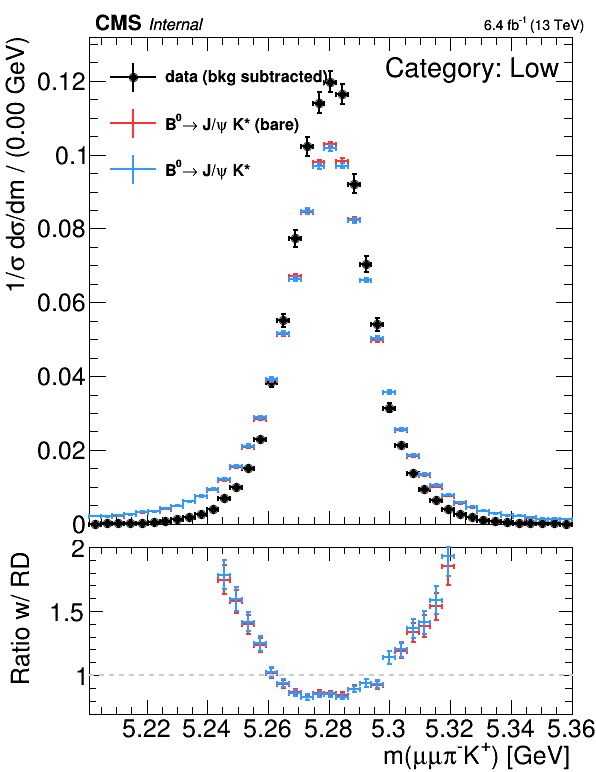

In [25]:
b=[41, m_min, m_max]
hRD = create_TH1D(dfRD[mB_var], name='hRD', title='RD',
                  weights=dfRD['sigSW'],
                  axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                  binning=b,
                  scale_histo='norm',
                 )
hRD.SetMarkerStyle(15)

hMCbare = create_TH1D(dfMC[mB_var], name='hMCbare',
                  title = 'Pythia Hard b#bar{b}',
                  scale_histo='norm', color=1,
                  binning=hRD.binning)
    
hMC = create_TH1D(dfMC[mB_var], name='hMC',
                  weights=dfMC['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning)

leg = rt.TLegend(0.17, 0.75, 0.6,0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hRD, 'data (bkg subtracted)', 'lep')
leg.AddEntry(hMCbare, 'B^{0}#rightarrow J/#psi K* (bare)', 'le')
leg.AddEntry(hMC, 'B^{0}#rightarrow J/#psi K*', 'le')

CMS_lumi.extraText = 7*' ' + 'Internal'
CMS_lumi.integrated_lumi = lumi_tot
c = make_ratio_plot([hRD, hMCbare, hMC], leg_pos=None, ratio_bounds=[0.7,2])
c.pad1.SetTopMargin(0.07)
CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
catText.DrawLatexNDC(0.95, 0.9, 'Category: {}'.format(cat.name))
leg.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/massComaprison_' + cat.name + '_' + version + '.png')

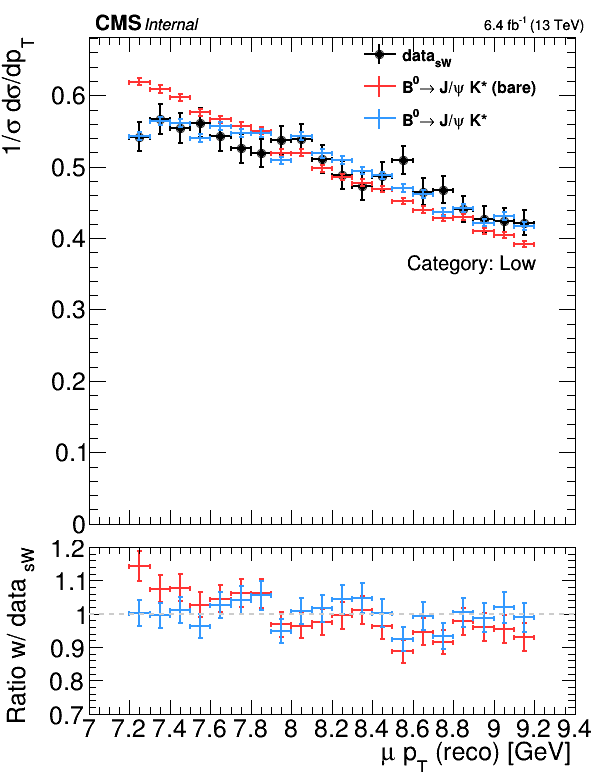

In [26]:
b = {'Low': array('d', list(np.arange(7, 9.4, 0.1)) + [9.4]),
     'Mid': array('d', list(np.arange(9, 12.2, 0.1)) +[12.2]),
     'High': array('d', list(10+np.logspace(np.log10(12.2-10), np.log10(50), 30)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRD['trgMu_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['#mu p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T}'],
                  binning=b[cat.name],
                  scale_histo='norm',
                  widthNorm=True,
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['trgMu_pt'], name='hMCb',
                  title = 'B^{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm',
                  widthNorm=True,
                  color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['trgMu_pt'], name='hMC', 
                  weights=dfMC['w'],
#                   weights=dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF'],
#                   weights=dfMC['trgSF'],
                  title = 'B^{0}#rightarrow J/#psi K*',
                  scale_histo='norm',
                  widthNorm=True,
                  color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 1.2], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
if cat.name == 'High':
    cr.pad1.SetLogx()
    cr.pad2.SetLogx()
cr.leg.SetY2(0.93)
cr.leg.SetY1(0.75)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/trgMuPtComaprison_' + cat.name + '_' + version + '.png')

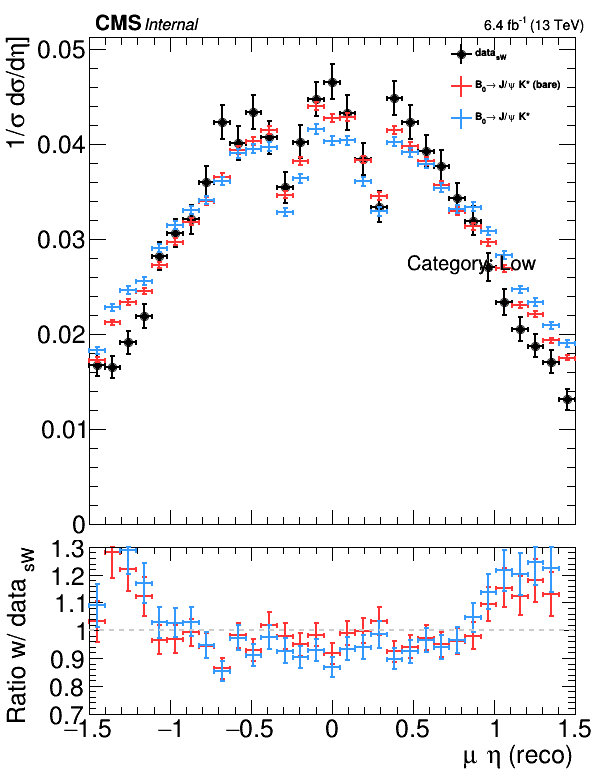

In [27]:
hRD = create_TH1D(dfRD['trgMu_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['#mu #eta (reco)', 
                              '1/#sigma d#sigma/d#eta]'],
                  binning=[31,-1.5,1.5],
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['trgMu_eta'], name='hMCb',
                  title = 'B_{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['trgMu_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   weights=dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF'],
#                   weights=dfMC['trgSF'],
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 1.3], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
# cr.pad2.SetLogy()
cr.leg.SetY2(0.93)
cr.leg.SetY1(0.75)
cr.leg.SetX1(0.75)
cr.leg.SetX2(0.94)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/trgMuEtaComaprison_' + cat.name + '_' + version + '.png')

### The true B spectrum

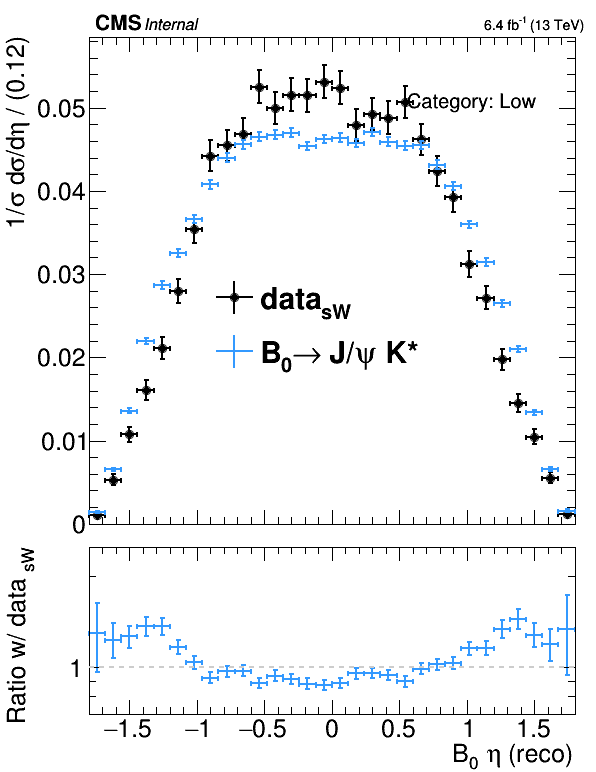

In [28]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRD['B_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_eta'], name='hMCb',
                  title = 'MC',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   title = 'MC (weights)',
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/B0etaComaprison_' + cat.name + '_' + version + '.png')

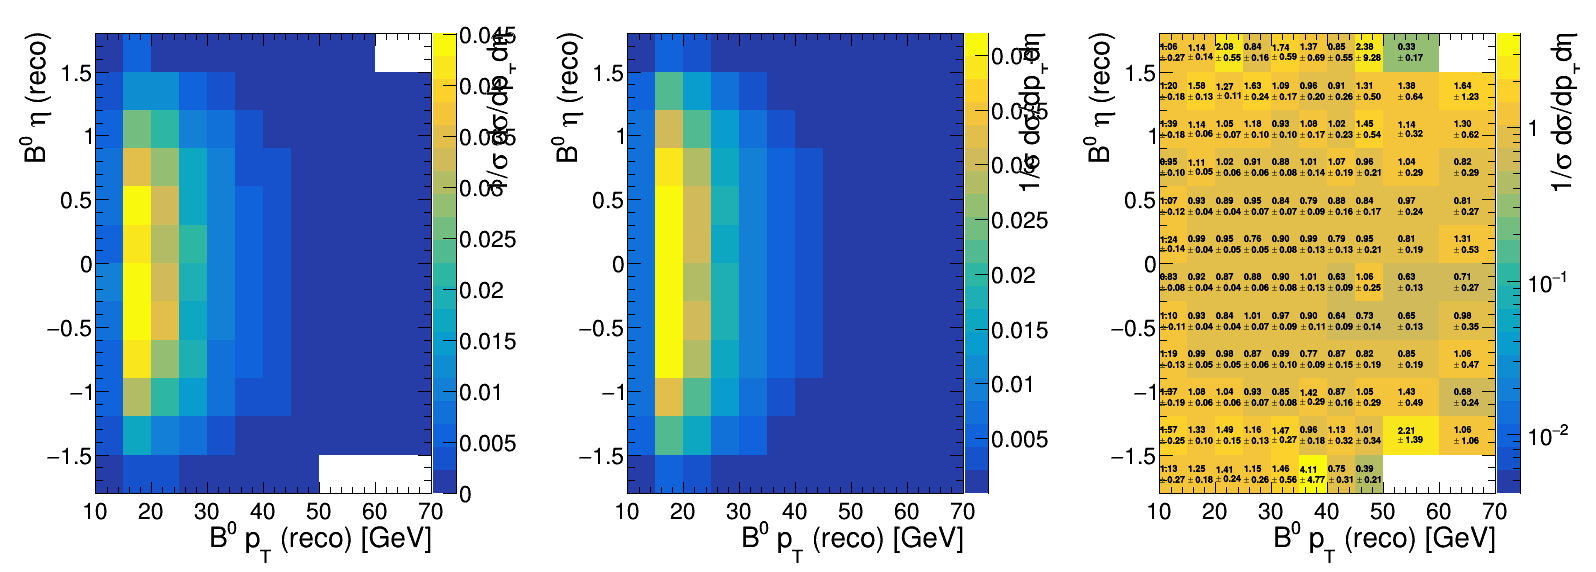

In [29]:
b = {'Low': array('d', list(np.arange(10, 50, 5)) + list(np.arange(50, 80, 10))),
     'Mid': array('d', list(np.arange(10, 60, 4)) + list(np.arange(60, 90, 8))),
     'High': array('d', list(np.arange(10, 90, 4)) + list(np.arange(90, 120, 15)))
    }
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH2D(dfRD[['B_pt', 'B_eta']].values, name='hRD_2D',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 'B^{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  binning=[b[cat.name], np.arange(-1.8,1.81, 0.3)],
                  scale_histo='norm',
                 )

hMC = create_TH2D(dfMC[['B_pt', 'B_eta']].values, name='hMC_2D',
                  weights=dfMC['w'],
                  binning=hRD.binning,
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 'B^{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  scale_histo='norm',
                  )

hRatio = hMC.Clone('hRatio')
hRatio.Divide(hRD)

cc = rt.TCanvas('c2D', 'c2D', 50, 50, 1600, 600)
cc.SetTickx(0)
cc.SetTicky(0)
cc.Divide(3)

pad = cc.cd(1)
pad.SetRightMargin(0.17)
hRD.Draw('colz')

pad = cc.cd(2)
pad.SetRightMargin(0.17)
hMC.Draw('colz')

pad = cc.cd(3)
pad.SetRightMargin(0.17)
hRatio.Draw('colz')
rt.gStyle.SetPaintTextFormat('.2f')
hRatio.Draw('texte same')
pad.SetLogz()

cc.Draw()

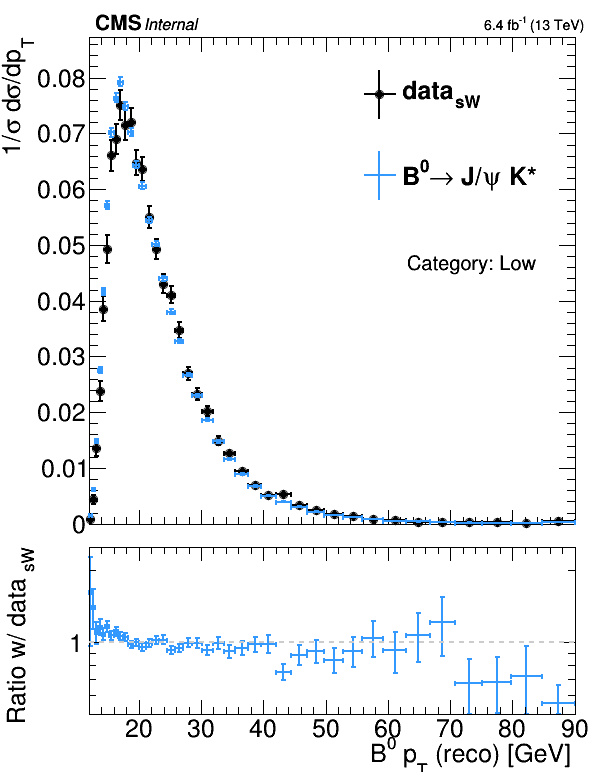

In [30]:
lowOff = 5
midOff = 10
highOff = 5
b = {'Low': array('d', list( lowOff+np.logspace(np.log10(12-lowOff), np.log10(90-lowOff), 40) )),
     'Mid': array('d', list( midOff+np.logspace(np.log10(14-midOff), np.log10(100-midOff), 45) )),
     'High': array('d', list( highOff+np.logspace(np.log10(18-highOff), np.log10(125-highOff), 50) )),
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRD['B_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T}'],
                  binning=b[cat.name],
                  scale_histo='norm',
                  widthNorm=True,
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_pt'], name='hMCb',
                  title = 'B^{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm', color=1,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_pt'], name='hMC', 
                  weights=dfMC['w'],
                  title = 'B^{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRD, hMC], ratio_bounds=[0.5, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 10], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
cr.pad2.SetLogy()
cr.leg.SetY2(0.9)
cr.leg.SetY1(0.6)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/B0pTcomaprison_' + cat.name + '_' + version + '.png')

In [31]:
### Create

In [32]:
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb_2(x, pivFrac=0.3, lamToEnd=3):
    xPiv = pivFrac*(hRD.binning[-1] + hRD.binning[0])
    if x <= xPiv:
        dx = xPiv - x
        lam = (xPiv - hRD.binning[0])/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return -sf
    elif x > xPiv:
        dx = x - xPiv
        lam = (hRD.binning[-1] - xPiv)/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return sf

fout = open('../data/calibration/B0pTspectrum/pwWeights_{}_{}.txt'.format(cat.name, version), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    if d == 0:
        dic['w'].append(1)
        dic['w_err'].append(0)
        dic['wUp'].append(1)
        dic['wDown'].append(1)
        continue
        
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    dic['wUp'].append(max(0, r + dr *f_arb_2(pt)))
    dic['wDown'].append(max(0, r - dr * f_arb_2(pt)))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, dic['wUp'][-1], dic['wDown'][-1]]))+'\n')
fout.close()

for k,v in dic.iteritems():
    dic[k] = np.array(v)
    
pickle.dump(dic, 
            open('../data/calibration/B0pTspectrum/RatioPtSpectrum_data_over_MC_{}_{}.pkl'.format(cat.name, version), 'wb'))

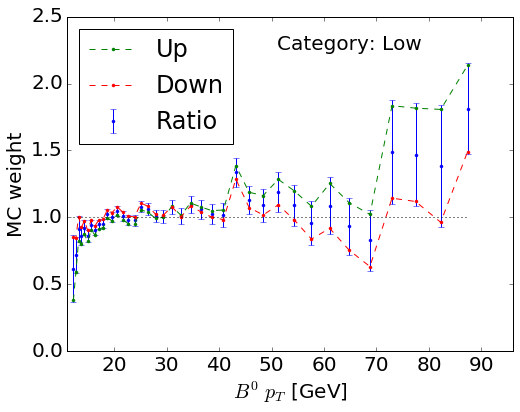

In [33]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1)
plt.xlabel('$B^0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
# plt.xscale('log')
plt.savefig('../data/calibration/B0pTspectrum/fig/ratioVSpt_' + cat.name + '_' + version + '.png')


Chi2/dof = 28.94/35 (75.5%)


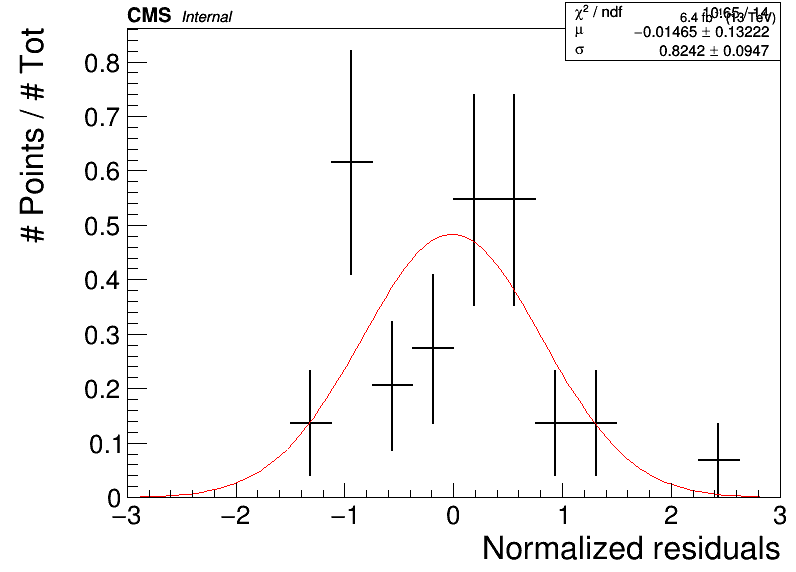

In [34]:
deg = 3
# beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov=True)
beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov='unscaled')

res = (dic['w'] - np.polyval(beta, dic['pt']))/dic['w_err']

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[16, -3,3],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals')

In [35]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('../data/calibration/B0pTspectrum/polyCoeffWeights_{}_{}.pkl'.format(cat.name, version), 'wb'))

Beta:  8.15e-06, -1.07e-03, 4.55e-02, 4.41e-01
Error: 2.49e-06, 3.03e-04, 1.08e-02, 1.14e-01


eigSigma: 1.14e-01
eigVect: 0.00, -0.00, 0.09, -1.00
Variation: 2.22e-06, -2.87e-04, 1.06e-02, -1.14e-01


eigSigma: 1.83e-03
eigVect: -0.00, 0.05, -0.99, -0.09
Variation: -1.01e-06, 9.48e-05, -1.82e-03, -1.70e-04


eigSigma: 1.99e-07
eigVect: -1.00, -0.02, -0.00, -0.00
Variation: -1.99e-07, -3.65e-09, -7.93e-11, -2.09e-12


eigSigma: 2.53e-05
eigVect: -0.02, 1.00, 0.05, 0.00
Variation: -4.64e-07, 2.53e-05, 1.31e-06, 5.88e-08


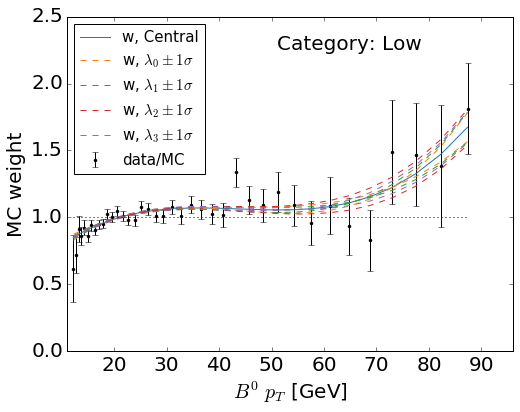

In [36]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.k', label='data/MC')

plt.plot(dic['pt'], np.polyval(beta, dic['pt']), '-', color='#1f77b4', label='w, Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], dic['pt'])
    yM = np.polyval(beta-betaVar[i], dic['pt'])
    plt.plot(dic['pt'], yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(dic['pt'], yM, '--', color=colors[i])
    
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B^0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
plt.savefig('../data/calibration/B0pTspectrum/fig/polyCal_weightsVSpt_' + cat.name + '_' + version + '.png')

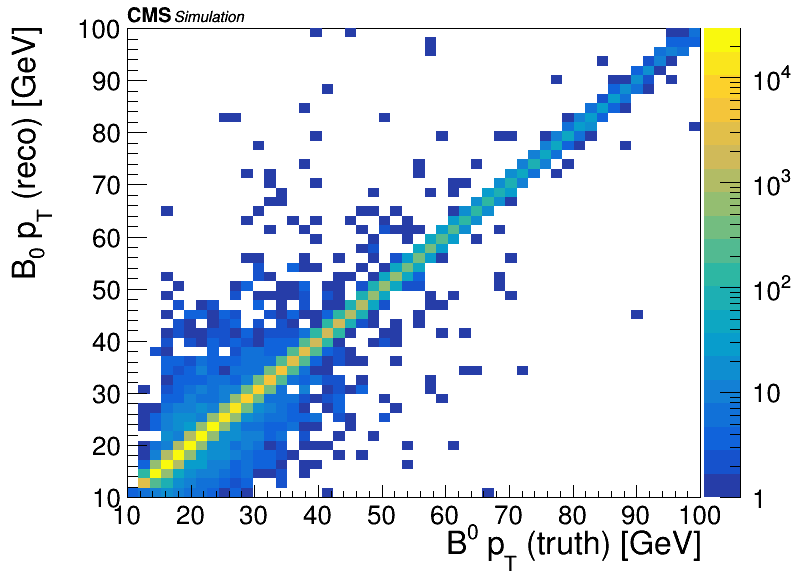

In [37]:
hMC2D = create_TH2D(dfMC[['B_pt', 'MC_B_pt']].values, name='hMC', title='',
                axis_title=['B^{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=[50, 10, 100, 50, 10, 100]
               )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

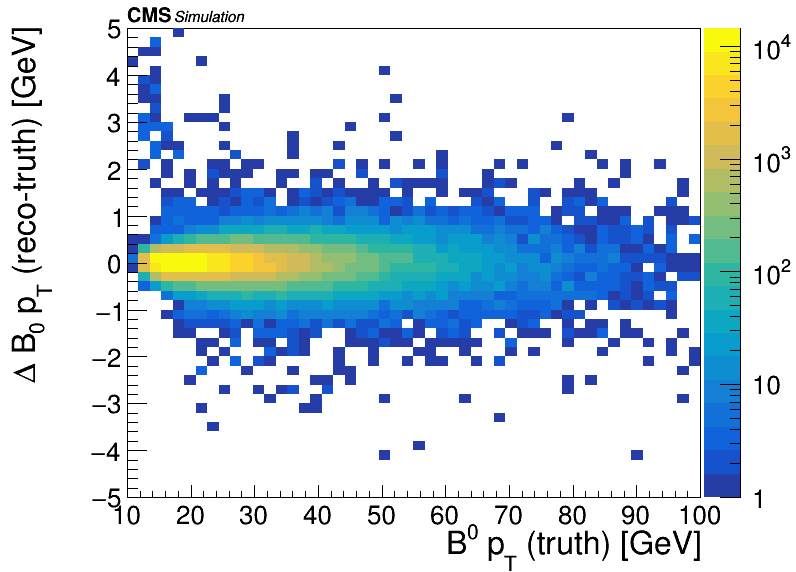

In [38]:
hMC2D = create_TH2D(np.column_stack((dfMC['MC_B_pt'], dfMC['B_pt'] - dfMC['MC_B_pt'])),
                    name='hMC', title='',
                    axis_title=['B^{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', 'Events'],
                    binning=[50, 10, 100, 50, -5, 5],
                    weights=dfMC['MC_idxMatch']
                   )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

In [39]:
from pT_calibration_reader import pTCalReader
cal_pT = pTCalReader(
    calibration_file='../data/calibration/B0pTspectrum/polyCoeffWeights_{}_{}.pkl'.format(cat.name, version)
)

In [40]:
h_var = {}
h_var['C'] = create_TH1D(dfMC['B_pt'], name='h_var_C', binning=hRD.binning, opt='underflow+overflow',
                         weights=cal_pT.getWeights(dfMC['MC_B_pt'], 0)*dfMC['w'])
norm = float(h_var['C'].Integral())
h_var['C'].Scale(1./norm, 'width')

mVar = np.array(betaVar)
nIter = 1000
binContent = np.zeros((nIter, hRD.GetNbinsX()))
pb = ProgressBar(nIter)
for itx in range(nIter):
    pb.show(itx)
    p = beta + np.sum(np.random.normal(size=(4,1))*mVar, axis=0)
    
    wPt = np.polyval(p, dfMC['B_pt'])
    hAux = create_TH1D(dfMC['B_pt'], name='hAux', binning=hRD.binning, opt='underflow+overflow', 
                       weights=wPt*dfMC['w'])
    hAux.Scale(1./norm, 'width')
    
    for i in range(1, binContent.shape[1]+1):
        binContent[itx, i-1] = hAux.GetBinContent(i)

for n, var in {'Down':-1, 'Up':1}.iteritems():
    h_var[n] = h_var['C'].Clone('h_var_'+n)
    content = np.percentile(binContent, q=100*sps.norm.cdf(var), axis=0)
    for i in range(1, content.shape[0]+1):
        h_var[n].SetBinContent(i, content[i-1]) 

[####################]  100% - Tot. time: 16.0 s


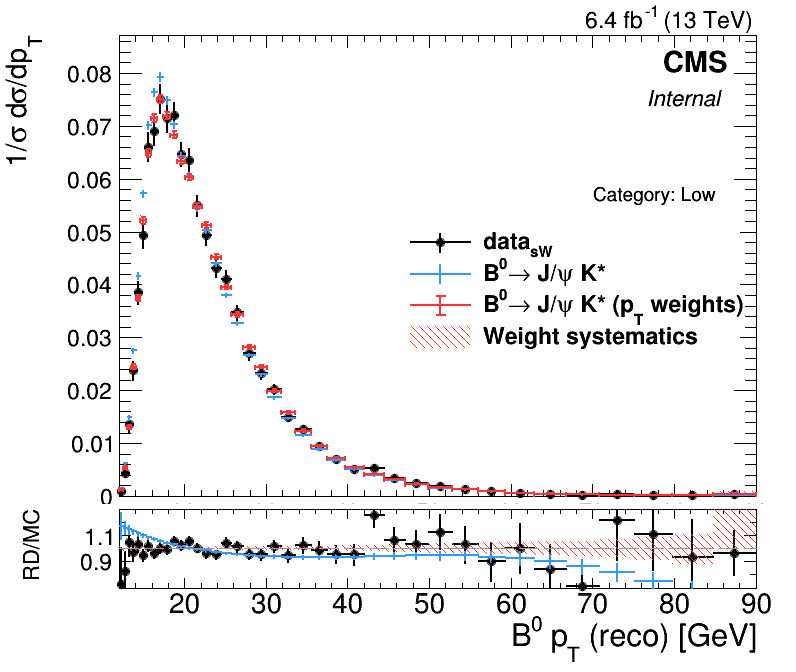

In [41]:
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kRed-4)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kRed-4)
gr_sys.SetFillColor(rt.kRed-4)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.5, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, 'B^{0}#rightarrow J/#psi K*', 'le')
leg.AddEntry(gr_stat, 'B^{0}#rightarrow J/#psi K* (p_{T} weights)', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name))
CMS_lumi.extraText = '     Internal'
CMS_lumi.integrated_lumi = lumi_tot
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.1
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kRed-4)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kRed-4)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/closure_' + cat.name + '_'+version+'.png')

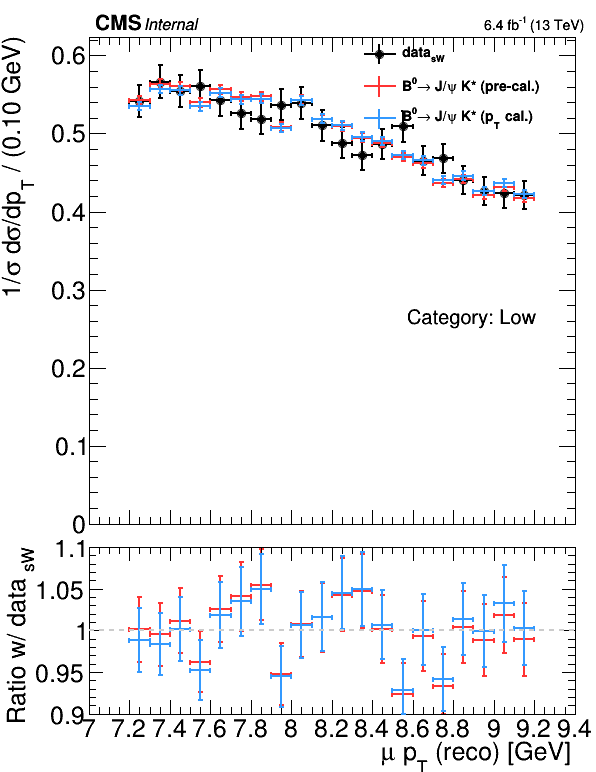

In [42]:
b = {'Low': array('d', list(np.arange(7, 9.4, 0.1)) + [9.4]),
     'Mid': array('d', list(np.arange(9, 12.2, 0.1)) +[12.2]),
     'High': array('d', list(10+np.logspace(np.log10(12.2-10), np.log10(60), 30)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRDaux = create_TH1D(dfRD['trgMu_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['#mu p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format(binWdith)],
                  binning=b[cat.name],
                  scale_histo='norm',
                  widthNorm=True,
                  opt='overflow'
#                   opt='overflow+underflow'
                 )
hRDaux.SetMarkerStyle(15)

hMCbaux = create_TH1D(dfMC['trgMu_pt'], name='hMCb',
                  title = 'B^{0}#rightarrow J/#psi K* (pre-cal.)',
                  scale_histo='norm', color=1,
                  weights=dfMC['w'],
                  widthNorm=True,
                  binning=hRDaux.binning, opt='overflow')
#                   binning=hRDaux.binning, opt='overflow+underflow')

hMCaux = create_TH1D(dfMC['trgMu_pt'], name='hMC', 
                  weights=cal_pT.getWeights(dfMC['MC_B_pt'], 0)*dfMC['w'],
                  title = 'B^{0}#rightarrow J/#psi K* (p_{T} cal.)',
                  scale_histo='norm', color=0,
                  widthNorm=True,
                  binning=hRDaux.binning, opt='overflow')
#                   binning=hRDaux.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRDaux, hMCbaux, hMCaux], ratio_bounds=[0.9,1.1], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
if cat.name == 'High':
    cr.pad1.SetLogx()
    cr.pad2.SetLogx()
cr.leg.SetY2(0.93)
cr.leg.SetY1(0.75)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.4, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/trgMuPtComaprison_' + cat.name + '_postCal' + '_' + version + '.png')